In [1]:
import numpy as np
import pandas as pd
from common import *

from matplotlib import pyplot as plt

from common_test import *
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 50em; }</style>"))

/tmp/ipykernel_115394/1612882624.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# df_mimic = get_datasets(dataset="MIMIC_final_push", model_name="model_492")
df_mimic, df_eicu = get_datasets()
df_mimic_raw = load_mat_files("../data/MIMIC_final_raw_push")

In [3]:
df_mimic_raw = pd.DataFrame(df_mimic_raw)
df_mimic_raw_state = df_mimic_raw[[_ for _ in range(47)]]
df_mimic_raw_state.columns = new_columns47
df_mimic_raw_state['age'] = df_mimic_raw_state['age'] / 365.25

/tmp/ipykernel_115394/3100342551.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mimic_raw_state['age'] = df_mimic_raw_state['age'] / 365.25


In [4]:
# df_eicu = get_datasets(dataset="eICU_final_push", model_name="model_492")
df_eicu_raw = load_mat_files("../data/eICU_final_push_raw")

In [5]:
df_mimic_raw_state['Shock_Index']

0         0.658106
1         0.632432
2         0.664395
3         0.674256
4         0.711712
            ...   
257157    0.819565
257158    0.636842
257159    0.578859
257160    0.570136
257161    0.470890
Name: Shock_Index, Length: 257162, dtype: float64

In [6]:
df_eicu_raw = pd.DataFrame(df_eicu_raw)
df_eicu_raw_state = df_eicu_raw[[_ for _ in range(47)]]
df_eicu_raw_state.columns = new_columns47

In [7]:
query_attributes = ["output_4hourly", "output_total", "BUN", "age", "cumulated_balance", "SpO2", "Temp_C", "RR", "HR", "Shock_Index", "WBC_count", "MeanBP", "DiaBP", "previous_dose", "prev_dose_vaso", "SOFA"]
phys_changes = []
rein_changes = []
temp = []

# action 0, 1, 2, 3, 4 를 1, 2, 3, 4, 5로
df_mimic['phys_iv'] = df_mimic['phys_iv'].apply(lambda x: x + 1)
df_mimic['rein_iv'] = df_mimic['rein_iv'].apply(lambda x: x + 1)
df_mimic['phys_vaso'] = df_mimic['phys_vaso'].apply(lambda x: x + 1)
df_mimic['rein_vaso'] = df_mimic['rein_vaso'].apply(lambda x: x + 1)

df_eicu['phys_iv'] = df_eicu['phys_iv'].apply(lambda x: x + 1)
df_eicu['rein_iv'] = df_eicu['rein_iv'].apply(lambda x: x + 1)
df_eicu['phys_vaso'] = df_eicu['phys_vaso'].apply(lambda x: x + 1)
df_eicu['rein_vaso'] = df_eicu['rein_vaso'].apply(lambda x: x + 1)

In [8]:
def set_bins_ax(ax, dataframe, dataframe_raw, query_atttribute, bins_attribute, whose, which):
    whose_which = '_'.join([whose, which]) ## phys_iv phys_vaso rein_iv rein_vaso
    
    bins = pd.concat([dataframe[['death', whose_which]], dataframe_raw[[query_atttribute]]], axis=1).groupby([bins_attribute, whose_which], as_index=False).size()
    if which == 'iv':
        bins['value_sum'] = bins.apply(lambda row: row['size'] * row[whose_which], axis=1)

    elif which == 'vaso':
        bins['value_sum'] = bins.apply(lambda row: row['size'] * row[whose_which], axis=1)
    else:
        raise NotImplementedError()
    
    bins = bins.groupby([query_atttribute], as_index=False).agg({'value_sum': 'sum', 'size': 'sum'})
    bins['mean'] = bins['value_sum'] / bins['size']

    if whose == 'phys':
        ax.bar(np.arange(len(bins[query_atttribute])) - 0.2, bins['mean'], width=0.38, label='Clinician')
    elif whose == 'rein':
        ax.bar(np.arange(len(bins[query_atttribute])) + 0.2, bins['mean'], width=0.38, label='AI')
    else:
        raise NotImplementedError()

In [9]:
def track_bins_changes(ax, dataframe, dataframe_raw, query_atttribute, bins_attribute, whose, which):
    whose_which = '_'.join([whose, which]) ## phys_iv phys_vaso rein_iv rein_vaso
    
    bins = pd.concat([dataframe[['death', whose_which]], dataframe_raw[[query_atttribute]]], axis=1).groupby([bins_attribute, whose_which], as_index=False).size()
#     print(bins)
    if which == 'iv':
        bins['value_sum'] = bins.apply(lambda row: row['size'] * row[whose_which], axis=1)

    elif which == 'vaso':
        bins['value_sum'] = bins.apply(lambda row: row['size'] * row[whose_which], axis=1)
    else:
        raise NotImplementedError()
    temp.append(bins)
    
    bins = bins.groupby([query_atttribute], as_index=False).agg({'value_sum': 'sum', 'size': 'sum'})
    bins['mean'] = bins['value_sum'] / bins['size']

#     if whose == 'phys':
#         phys_changes.append(bins['mean'])
#         ax.bar(np.arange(len(bins[query_atttribute])) - 0.2, bins['mean'], width=0.38, label='Clinician')
#     elif whose == 'rein':
#         rein_changes.append(bins['mean'])
#         ax.bar(np.arange(len(bins[query_atttribute])) + 0.2, bins['mean'], width=0.38, label='AI')
#     else:
#         raise NotImplementedError()

len(phys_changes)
type(rein_changes[0])
for i in range(len(phys_changes)):
    print('{} correlation is {}'.format(query_attributes[i],
                                       phys_changes[i].corr(rein_changes[i], method='spearman')))
dataframe_raw['output_4hourly']


output_4hourly
q1: 0.0		q3: 3079.1950000001816
count    257162.000000
mean        316.722154
std         365.907426
min           0.000000
25%          80.000000
50%         220.000000
75%         440.000000
max       15100.000000
Name: output_4hourly, dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  from ipykernel import kernelapp as app


    output_4hourly  phys_iv   size
0                0        0  47260
1                0        1  29550
2                0        2  27404
3                0        3  27438
4                0        4  28763
5                1        0  11065
6                1        1  11865
7                1        2  12766
8                1        3  12561
9                1        4  11763
10               2        0   3829
11               2        1   4135
12               2        2   4988
13               2        3   4451
14               2        4   4321
15               3        0   1433
16               3        1   1602
17               3        2   2030
18               3        3   1829
19               3        4   1808
20               4        0    496
21               4        1    654
22               4        2    835
23               4        3    712
24               4        4    730
25               5        0    206
26               5        1    259
27               5  

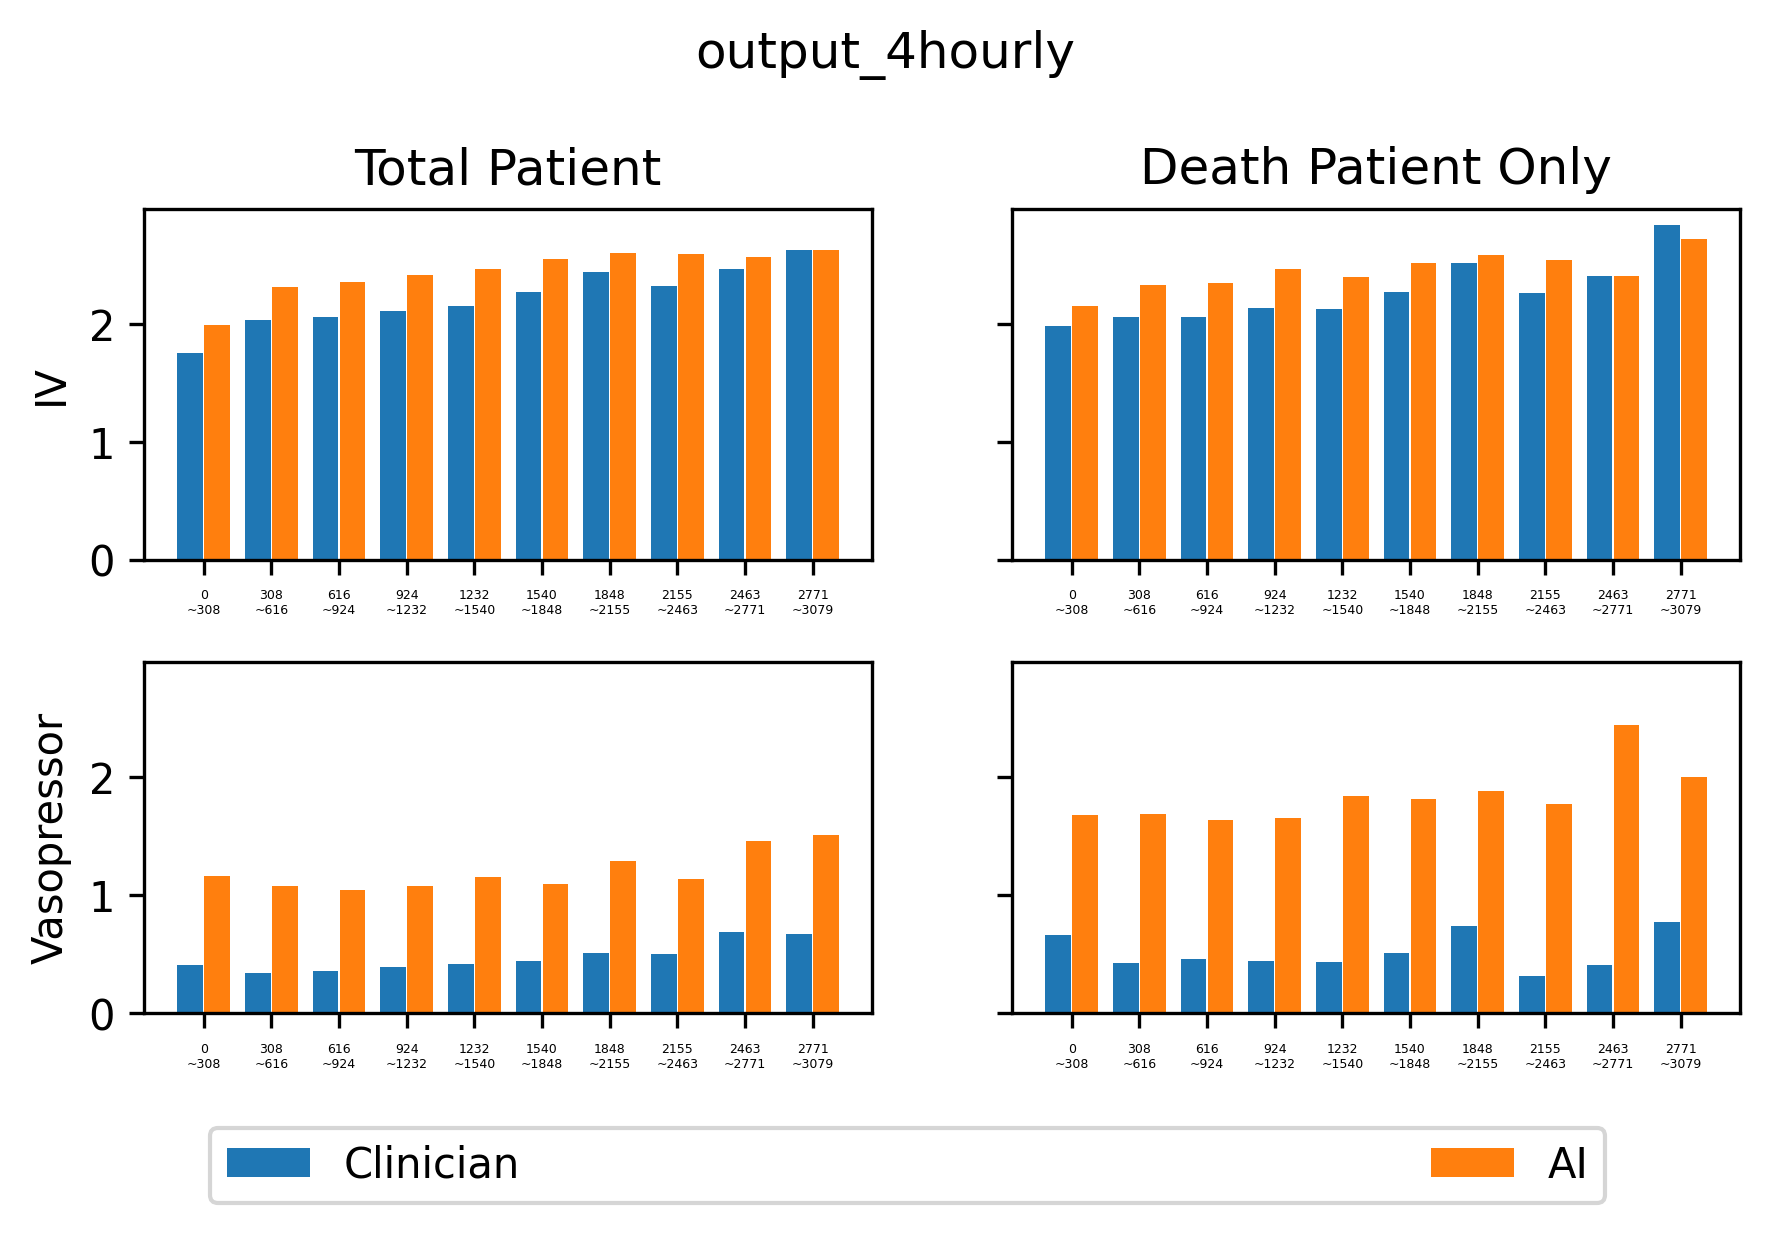

output_total
q1: 0.0		q3: 134198.68400001293
count    257162.000000
mean       6498.129430
std       12660.817868
min           0.000000
25%         870.000000
50%        2495.450001
75%        6465.000000
max      330130.000000
Name: output_total, dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  from ipykernel import kernelapp as app


    output_total  phys_iv   size
0              0        0  57475
1              0        1  41104
2              0        2  39016
3              0        3  42182
4              0        4  45113
5              1        0   4275
6              1        1   4248
7              1        2   5949
8              1        3   3472
9              1        4   1743
10             2        0   1516
11             2        1   1425
12             2        2   1861
13             2        3   1032
14             2        4    679
15             3        0    490
16             3        1    634
17             3        2    736
18             3        3    380
19             3        4    241
20             4        0    271
21             4        1    335
22             4        2    475
23             4        3    209
24             4        4    139
25             5        0    135
26             5        1    237
27             5        2    261
28             5        3    129
29        

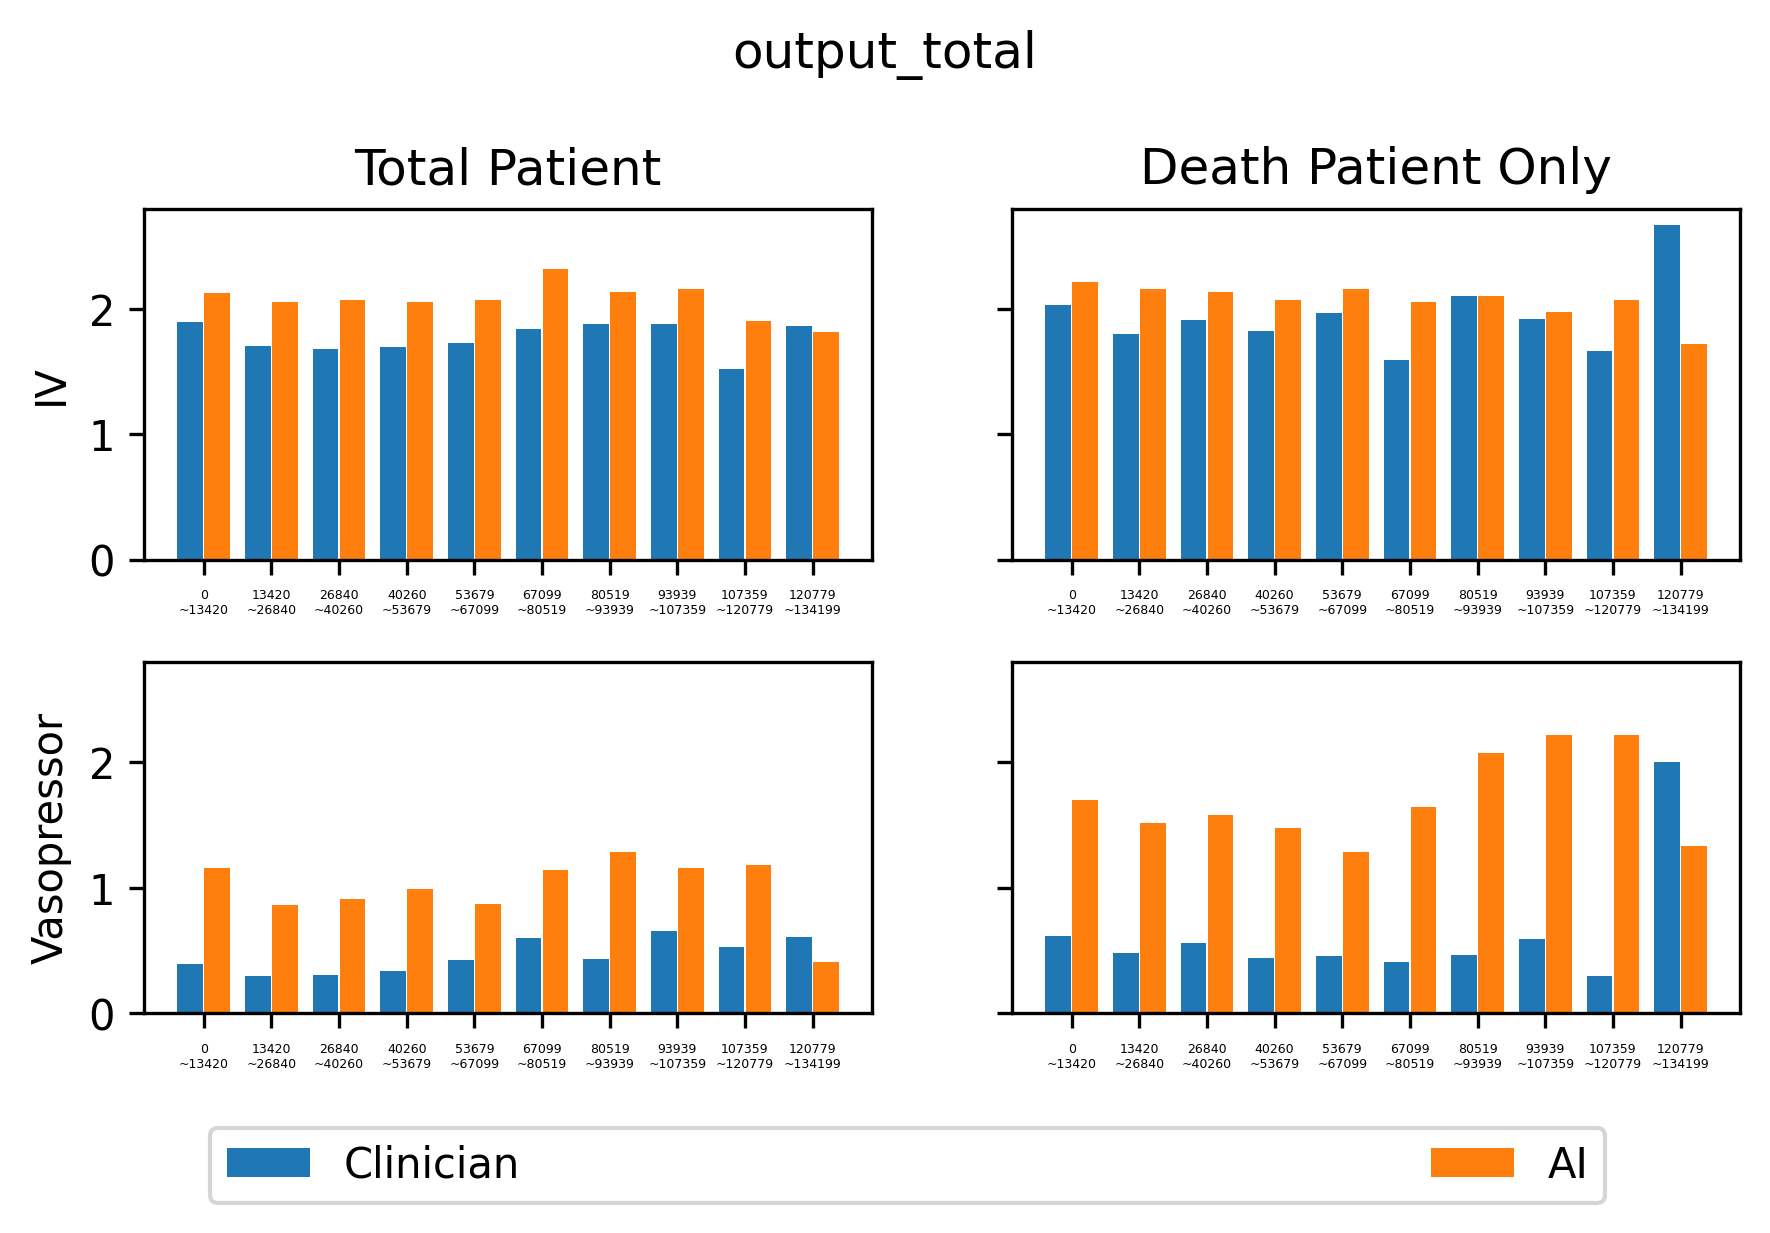

BUN
q1: 2.0		q3: 154.0
count    257162.000000
mean         29.227317
std          22.621707
min           0.000000
25%          14.000000
50%          22.000000
75%          37.000000
max         280.000000
Name: BUN, dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  from ipykernel import kernelapp as app


    BUN  phys_iv   size
0     0        0  22166
1     0        1  16071
2     0        2  16132
3     0        3  19523
4     0        4  20209
5     1        0  21722
6     1        1  16707
7     1        2  16233
8     1        3  14796
9     1        4  15280
10    2        0   9868
11    2        1   7401
12    2        2   7502
13    2        3   6273
14    2        4   5970
15    3        0   5002
16    3        1   3788
17    3        2   3844
18    3        3   3268
19    3        4   3226
20    4        0   2858
21    4        1   2008
22    4        2   2187
23    4        3   1727
24    4        4   1736
25    5        0   1402
26    5        1   1185
27    5        2   1360
28    5        3    931
29    5        4    852
30    6        0    710
31    6        1    534
32    6        2    644
33    6        3    486
34    6        4    446
35    7        0    394
36    7        1    272
37    7        2    361
38    7        3    284
39    7        4    223
40    8        0

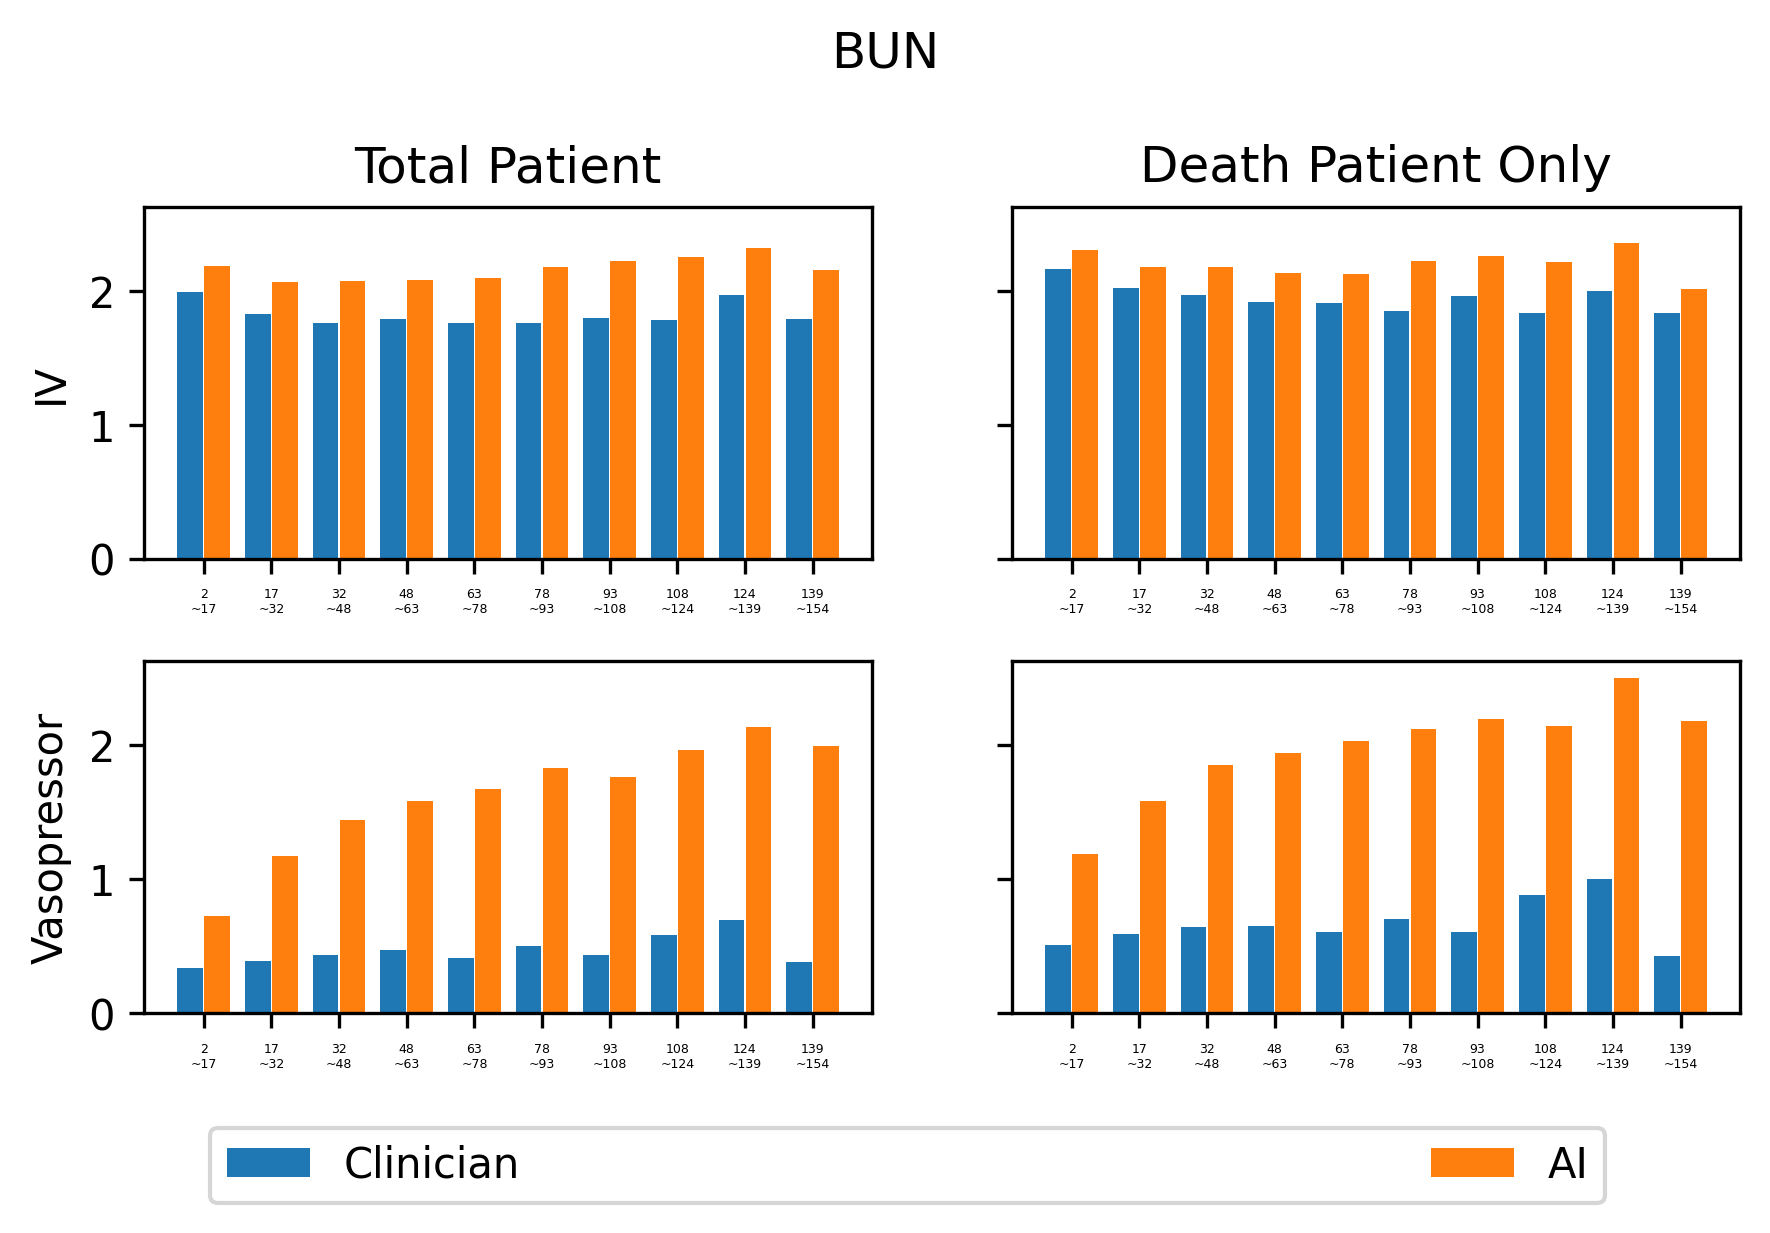

age
q1: 18.600597193702942		q3: 91.39999999999999
count    257162.000000
mean         64.528450
std          16.634035
min          18.021690
25%          53.520375
50%          66.000484
75%          77.713078
max          91.400000
Name: age, dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  from ipykernel import kernelapp as app


    age  phys_iv   size
0     0        0   1212
1     0        1    802
2     0        2    856
3     0        3   1325
4     0        4   1489
5     1        0   1430
6     1        1   1158
7     1        2   1193
8     1        3   1632
9     1        4   1763
10    2        0   2118
11    2        1   1517
12    2        2   1645
13    2        3   2281
14    2        4   2069
15    3        0   3930
16    3        1   2973
17    3        2   3441
18    3        3   3955
19    3        4   3924
20    4        0   6743
21    4        1   5240
22    4        2   5860
23    4        3   5952
24    4        4   6325
25    5        0   8787
26    5        1   6816
27    5        2   7009
28    5        3   6878
29    5        4   7625
30    6        0  10127
31    6        1   7642
32    6        2   8170
33    6        3   7648
34    6        4   7840
35    7        0  10337
36    7        1   7808
37    7        2   7481
38    7        3   6242
39    7        4   6213
40    8        0

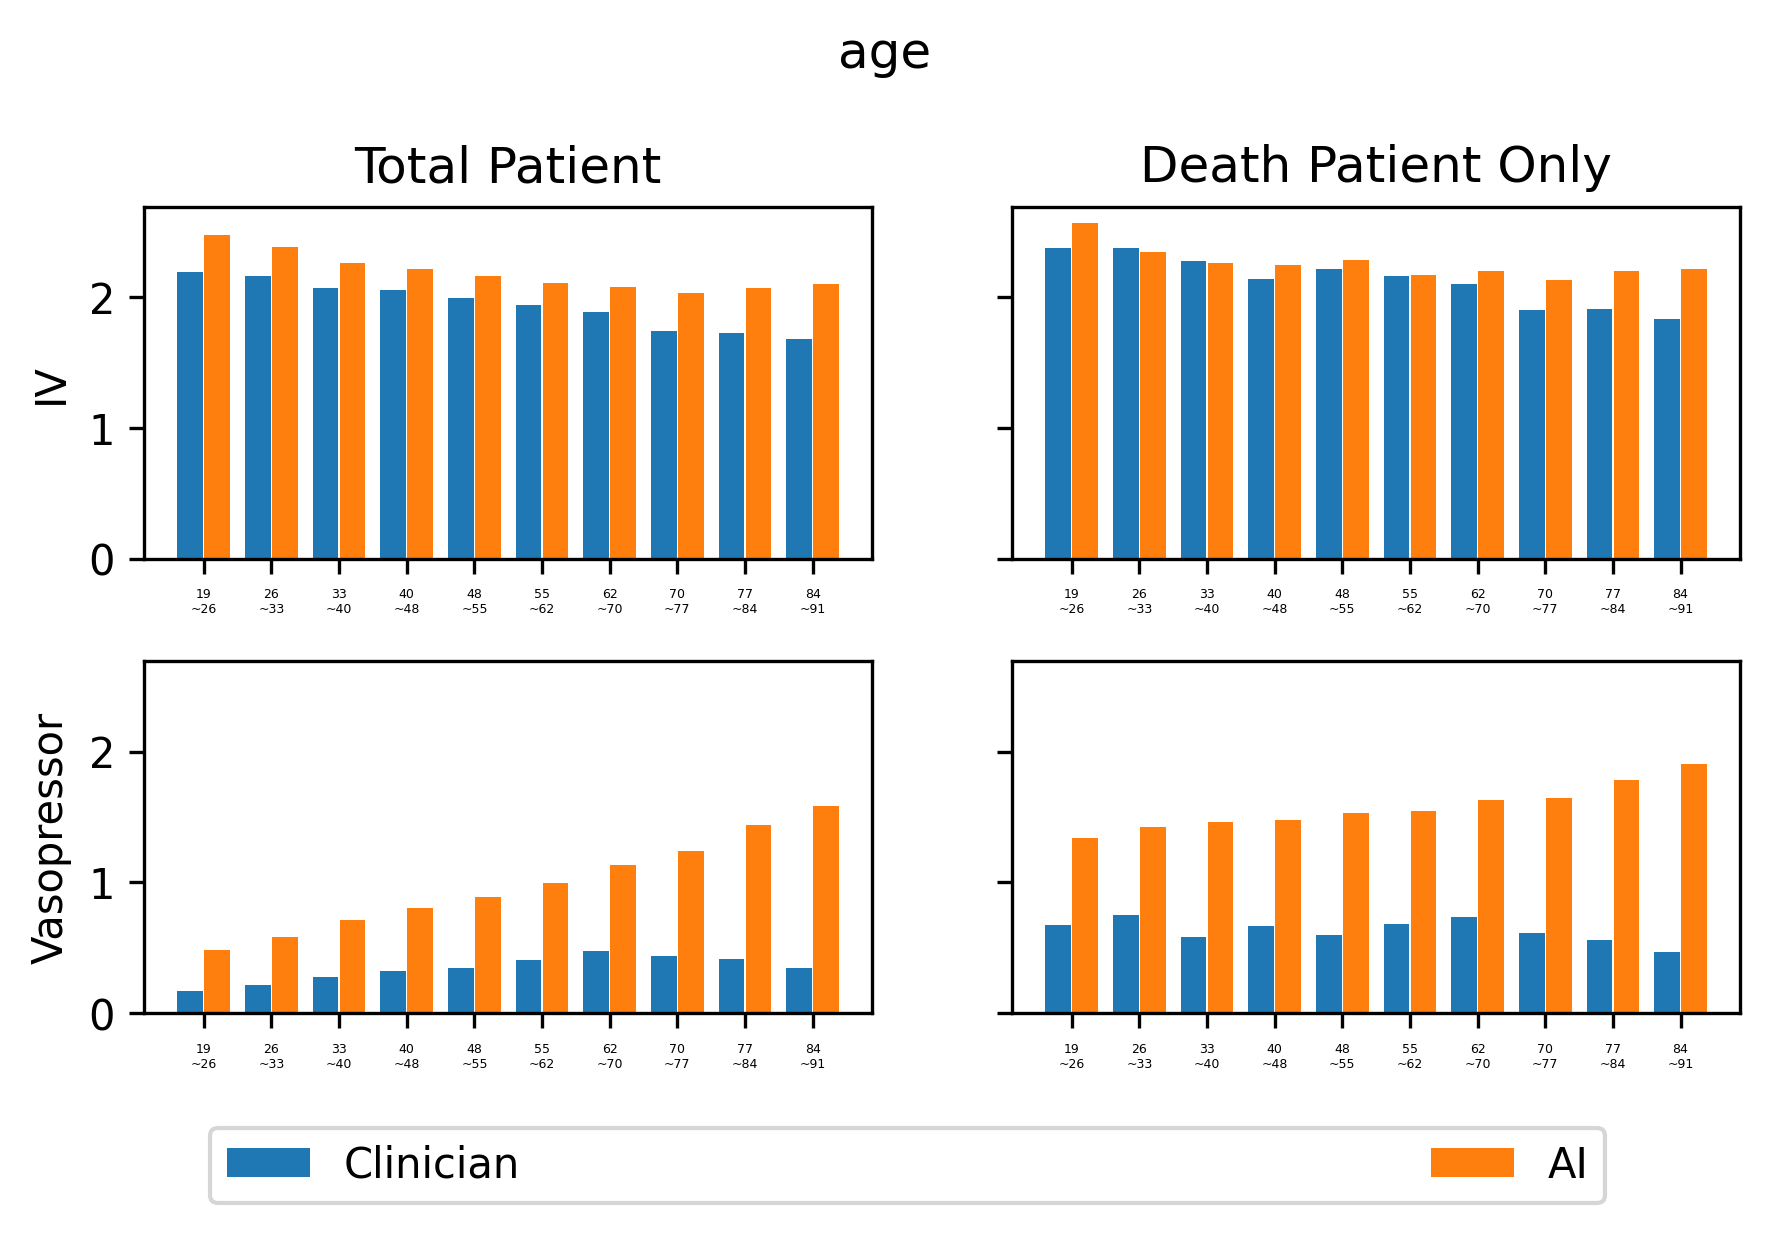

cumulated_balance
q1: -93891.50414899999		q3: 87808.92783334348
count    257162.000000
mean       1715.525229
std       12265.590502
min     -327907.283333
25%       -1209.334917
50%        1104.162492
75%        4946.873082
max      390393.885351
Name: cumulated_balance, dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  from ipykernel import kernelapp as app


    cumulated_balance  phys_iv   size
0                   0        0     64
1                   0        1     32
2                   0        2     16
3                   0        3     14
4                   0        4      3
5                   1        0     83
6                   1        1     72
7                   1        2    159
8                   1        3     44
9                   1        4     13
10                  2        0    262
11                  2        1    302
12                  2        2    382
13                  2        3    130
14                  2        4     56
15                  3        0    904
16                  3        1    949
17                  3        2   1200
18                  3        3    423
19                  3        4    153
20                  4        0  11701
21                  4        1   8316
22                  4        2   9725
23                  4        3   4115
24                  4        4   1482
25          

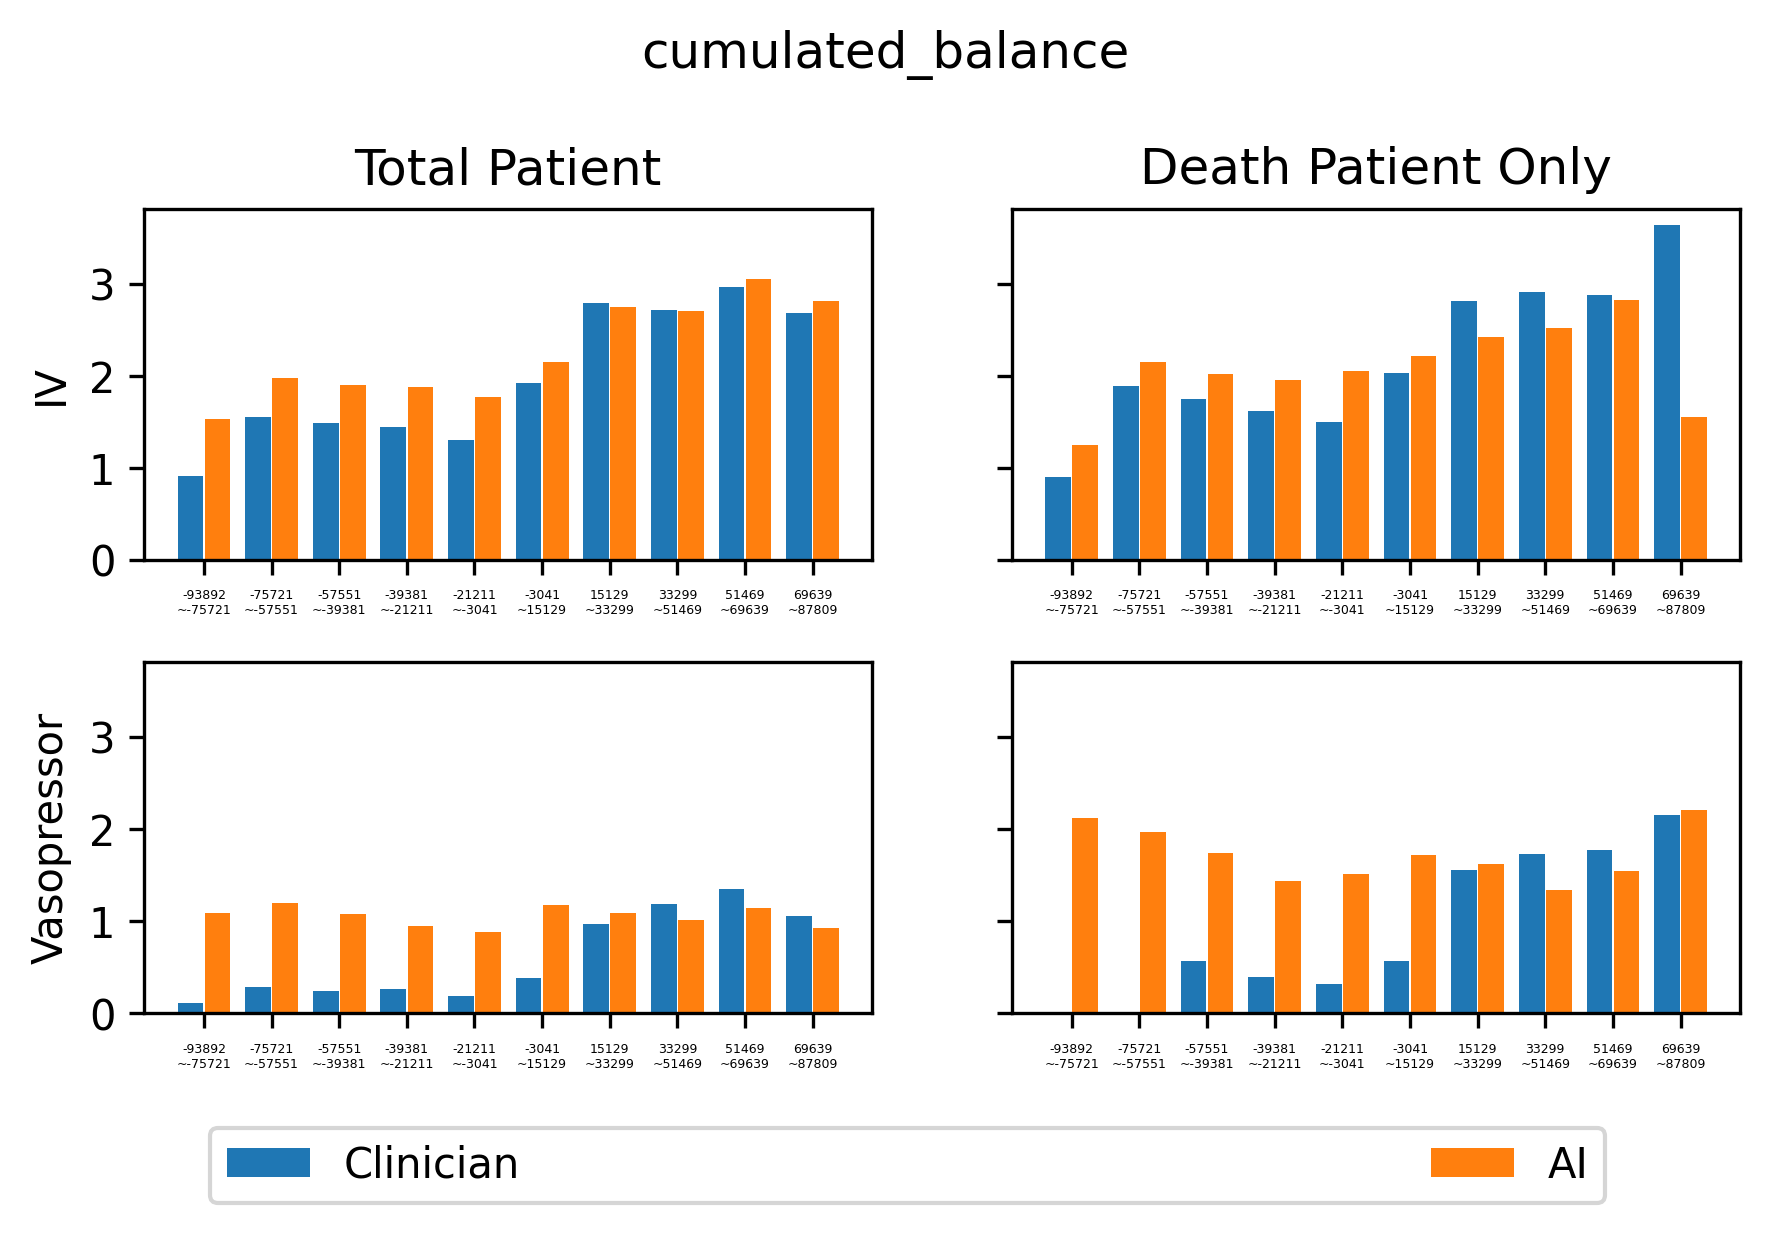

SpO2
q1: 74.0		q3: 100.0
count    257162.000000
mean         96.905366
std           2.647905
min          50.000000
25%          95.500000
50%          97.250000
75%          98.833333
max         100.000000
Name: SpO2, dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  from ipykernel import kernelapp as app


    SpO2  phys_iv   size
0      0        0     13
1      0        1     19
2      0        2      6
3      0        3      9
4      0        4     27
5      1        0     28
6      1        1     19
7      1        2     11
8      1        3     17
9      1        4     24
10     2        0     37
11     2        1     30
12     2        2     12
13     2        3     18
14     2        4     46
15     3        0     60
16     3        1     46
17     3        2     31
18     3        3     36
19     3        4     52
20     4        0    152
21     4        1    114
22     4        2     80
23     4        3     76
24     4        4    117
25     5        0    464
26     5        1    290
27     5        2    208
28     5        3    178
29     5        4    229
30     6        0   2356
31     6        1   1513
32     6        2   1190
33     6        3   1009
34     6        4    940
35     7        0  10091
36     7        1   7117
37     7        2   6367
38     7        3   5502


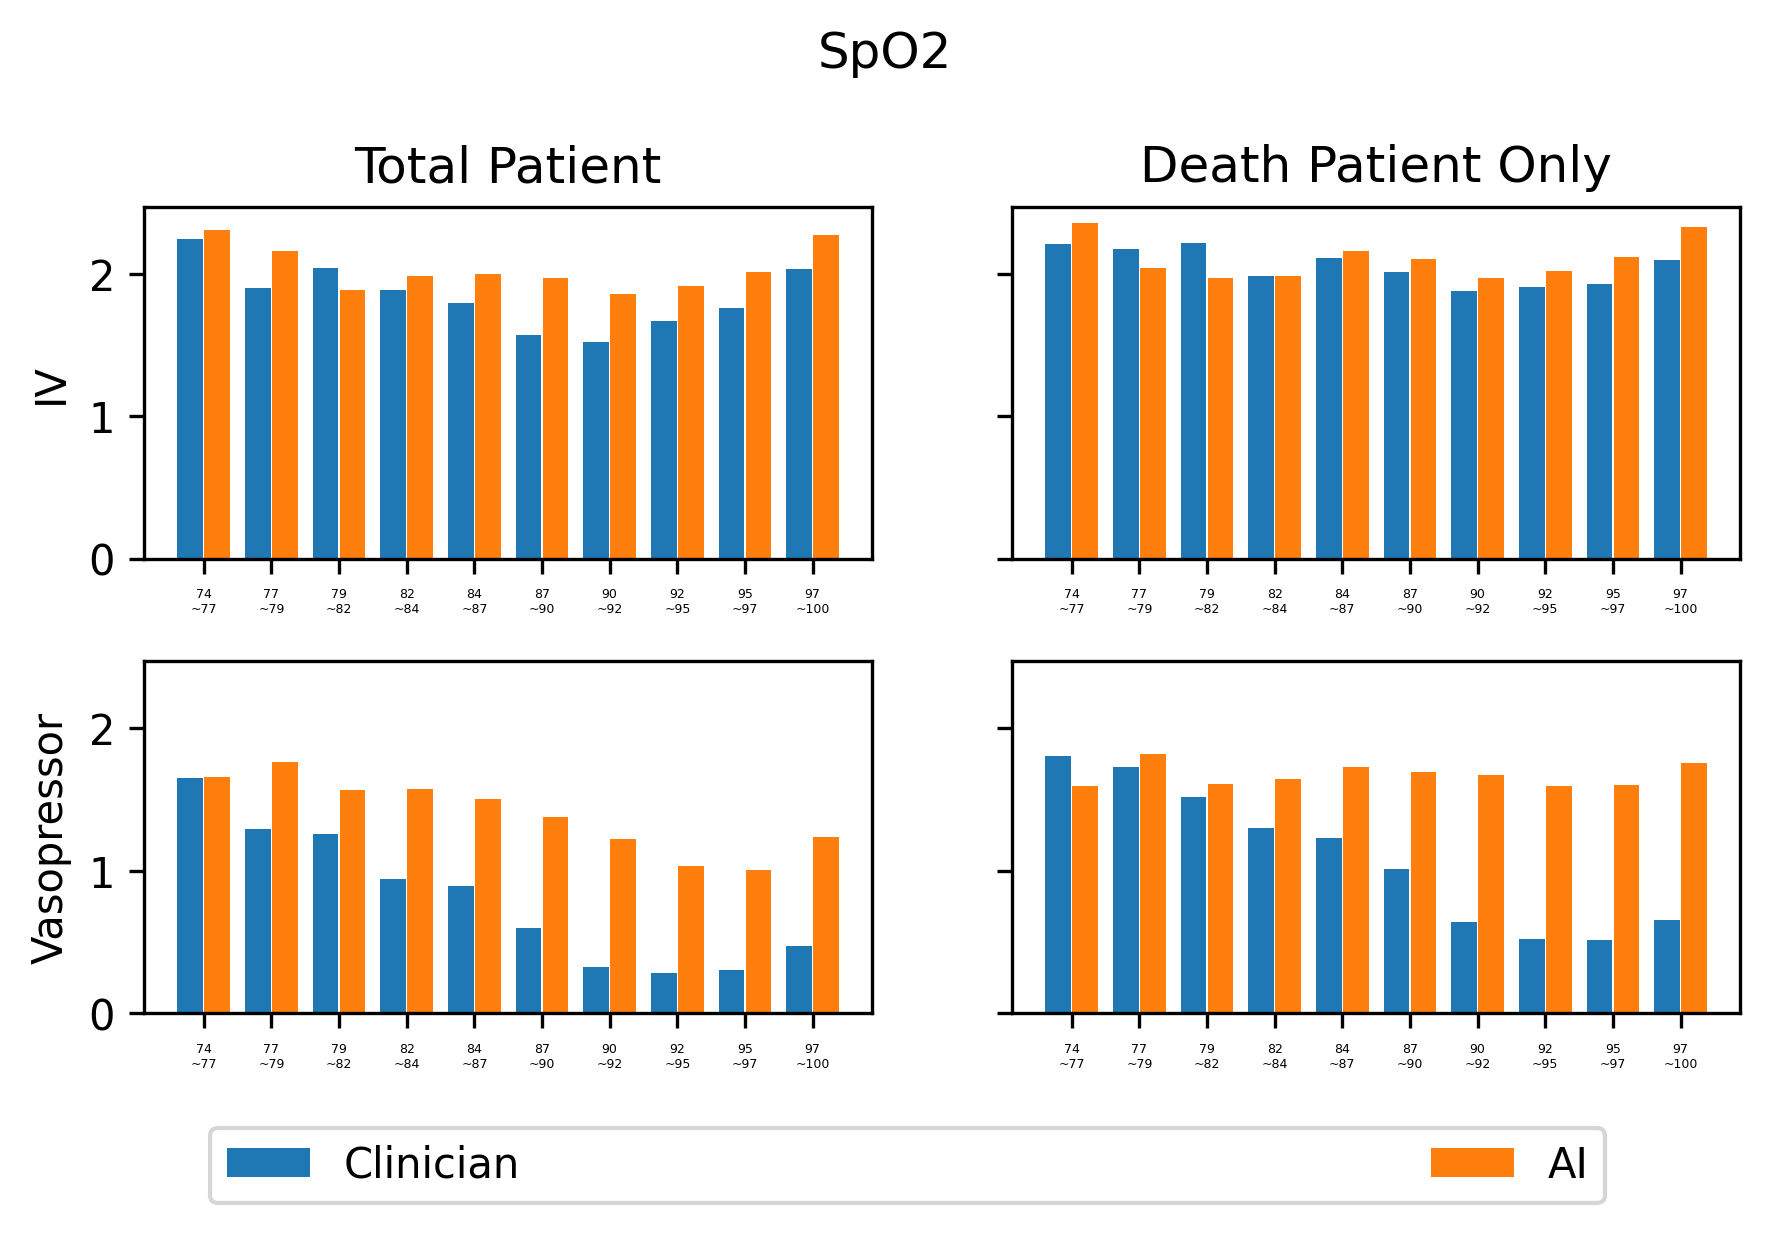

Temp_C
q1: 33.333333333333336		q3: 39.600000142245825
count    257162.000000
mean         36.910031
std           2.103498
min         -17.777778
25%          36.411110
50%          36.877778
75%          37.395062
max         536.111111
Name: Temp_C, dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  from ipykernel import kernelapp as app


    Temp_C  phys_iv   size
0        0        0     26
1        0        1     11
2        0        2     20
3        0        3     23
4        0        4     47
5        1        0     85
6        1        1     41
7        1        2     45
8        1        3     68
9        1        4    146
10       2        0    426
11       2        1    230
12       2        2    214
13       2        3    250
14       2        4    451
15       3        0   4190
16       3        1   2873
17       3        2   2646
18       3        3   2519
19       3        4   3137
20       4        0  15137
21       4        1  10808
22       4        2   9508
23       4        3   8942
24       4        4   9536
25       5        0  23942
26       5        1  17094
27       5        2  15687
28       5        3  15203
29       5        4  15023
30       6        0  13666
31       6        1  10974
32       6        2  12155
33       6        3  12044
34       6        4  11226
35       7        0   5306
3

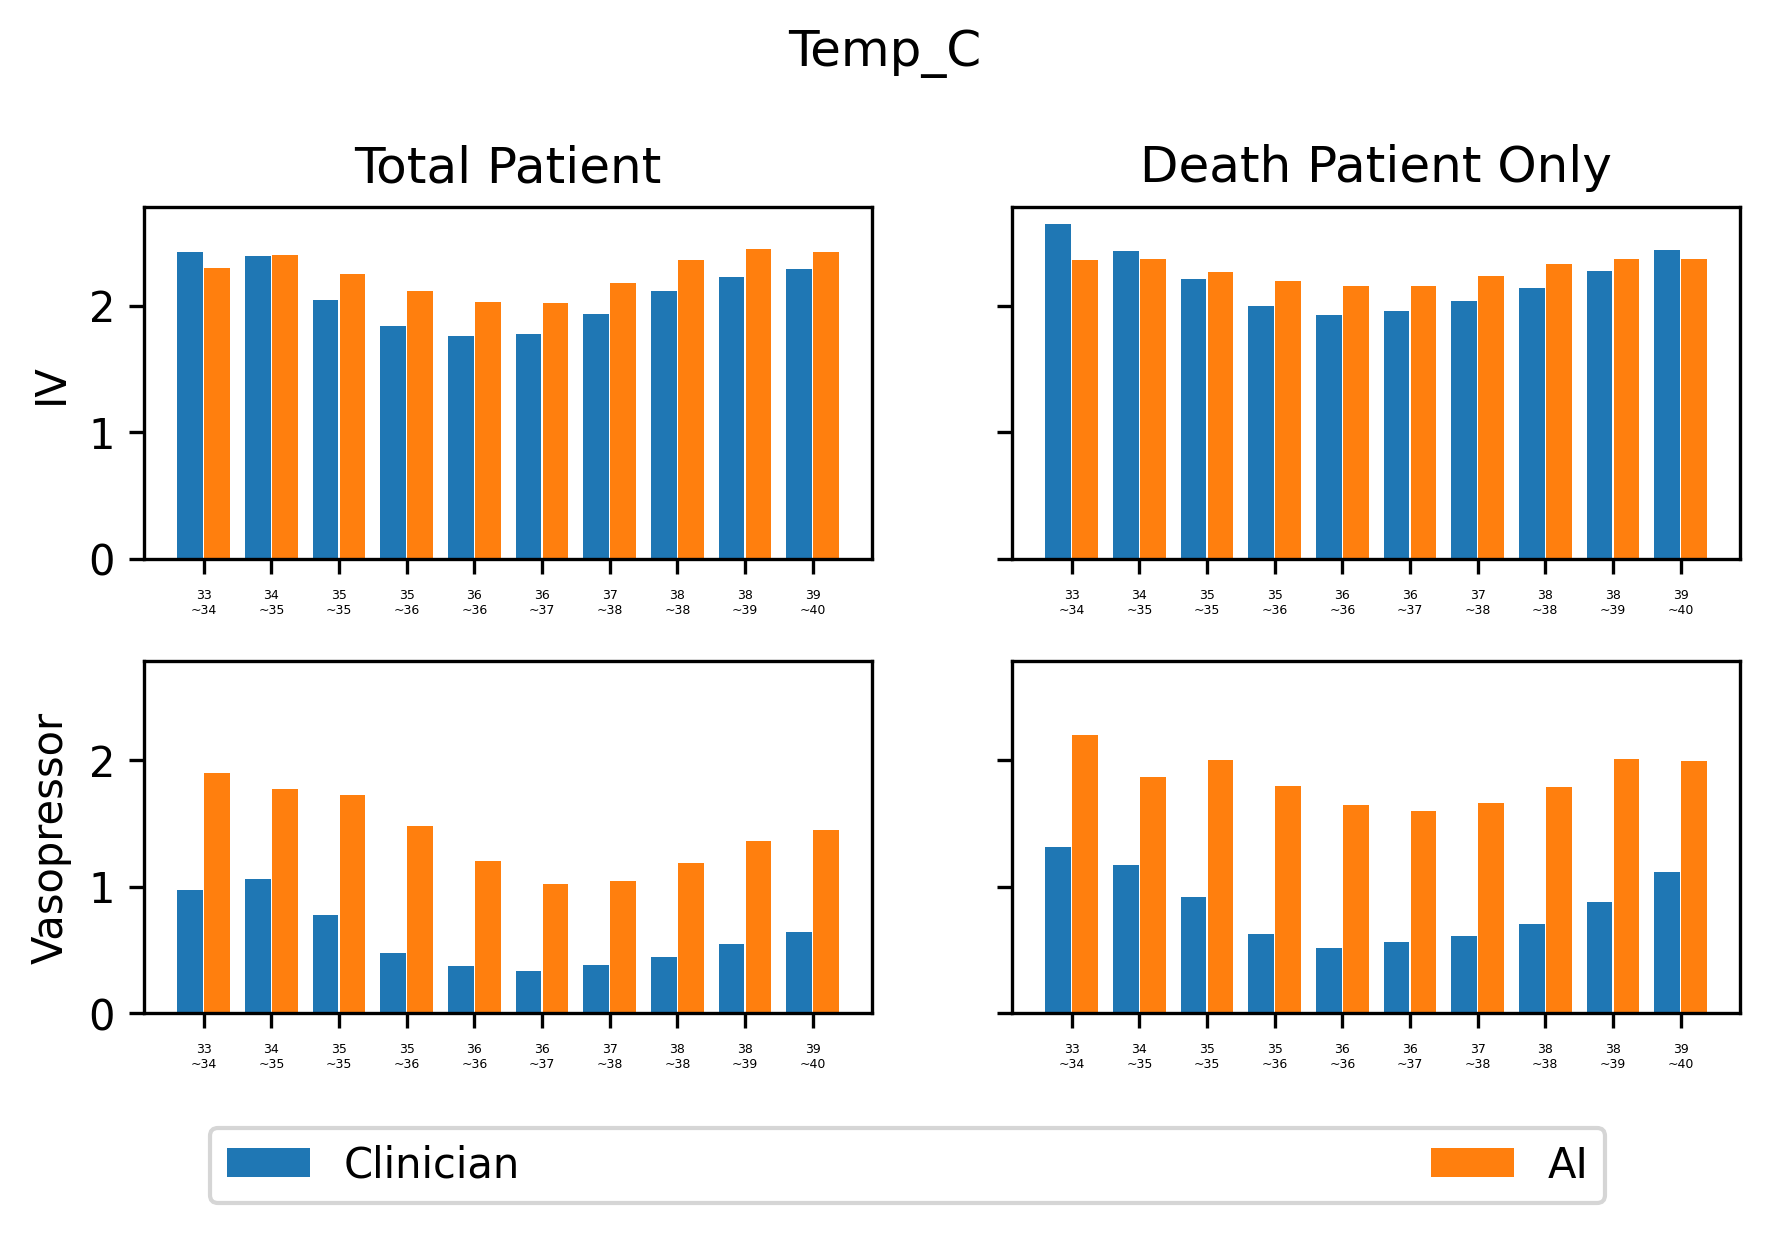

RR
q1: 6.0		q3: 42.142857142857146
count    257162.000000
mean         20.237743
std           5.197978
min           0.000000
25%          16.571429
50%          19.750000
75%          23.333333
max          65.000000
Name: RR, dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  from ipykernel import kernelapp as app


    RR  phys_iv   size
0    0        0    260
1    0        1    223
2    0        2    235
3    0        3    325
4    0        4    338
5    1        0   2977
6    1        1   2459
7    1        2   2809
8    1        3   3162
9    1        4   3469
10   2        0  11870
11   2        1   8998
12   2        2   9745
13   2        3  10606
14   2        4  11954
15   3        0  19220
16   3        1  13939
17   3        2  13579
18   3        3  13888
19   3        4  13745
20   4        0  16384
21   4        1  11766
22   4        2  11412
23   4        3  10211
24   4        4   9781
25   5        0   8129
26   5        1   6507
27   5        2   6357
28   5        3   5448
29   5        4   5071
30   6        0   3677
31   6        1   2888
32   6        2   2891
33   6        3   2511
34   6        4   2427
35   7        0   1281
36   7        1   1019
37   7        2   1088
38   7        3    982
39   7        4    928
40   8        0    417
41   8        1    302
42   8     

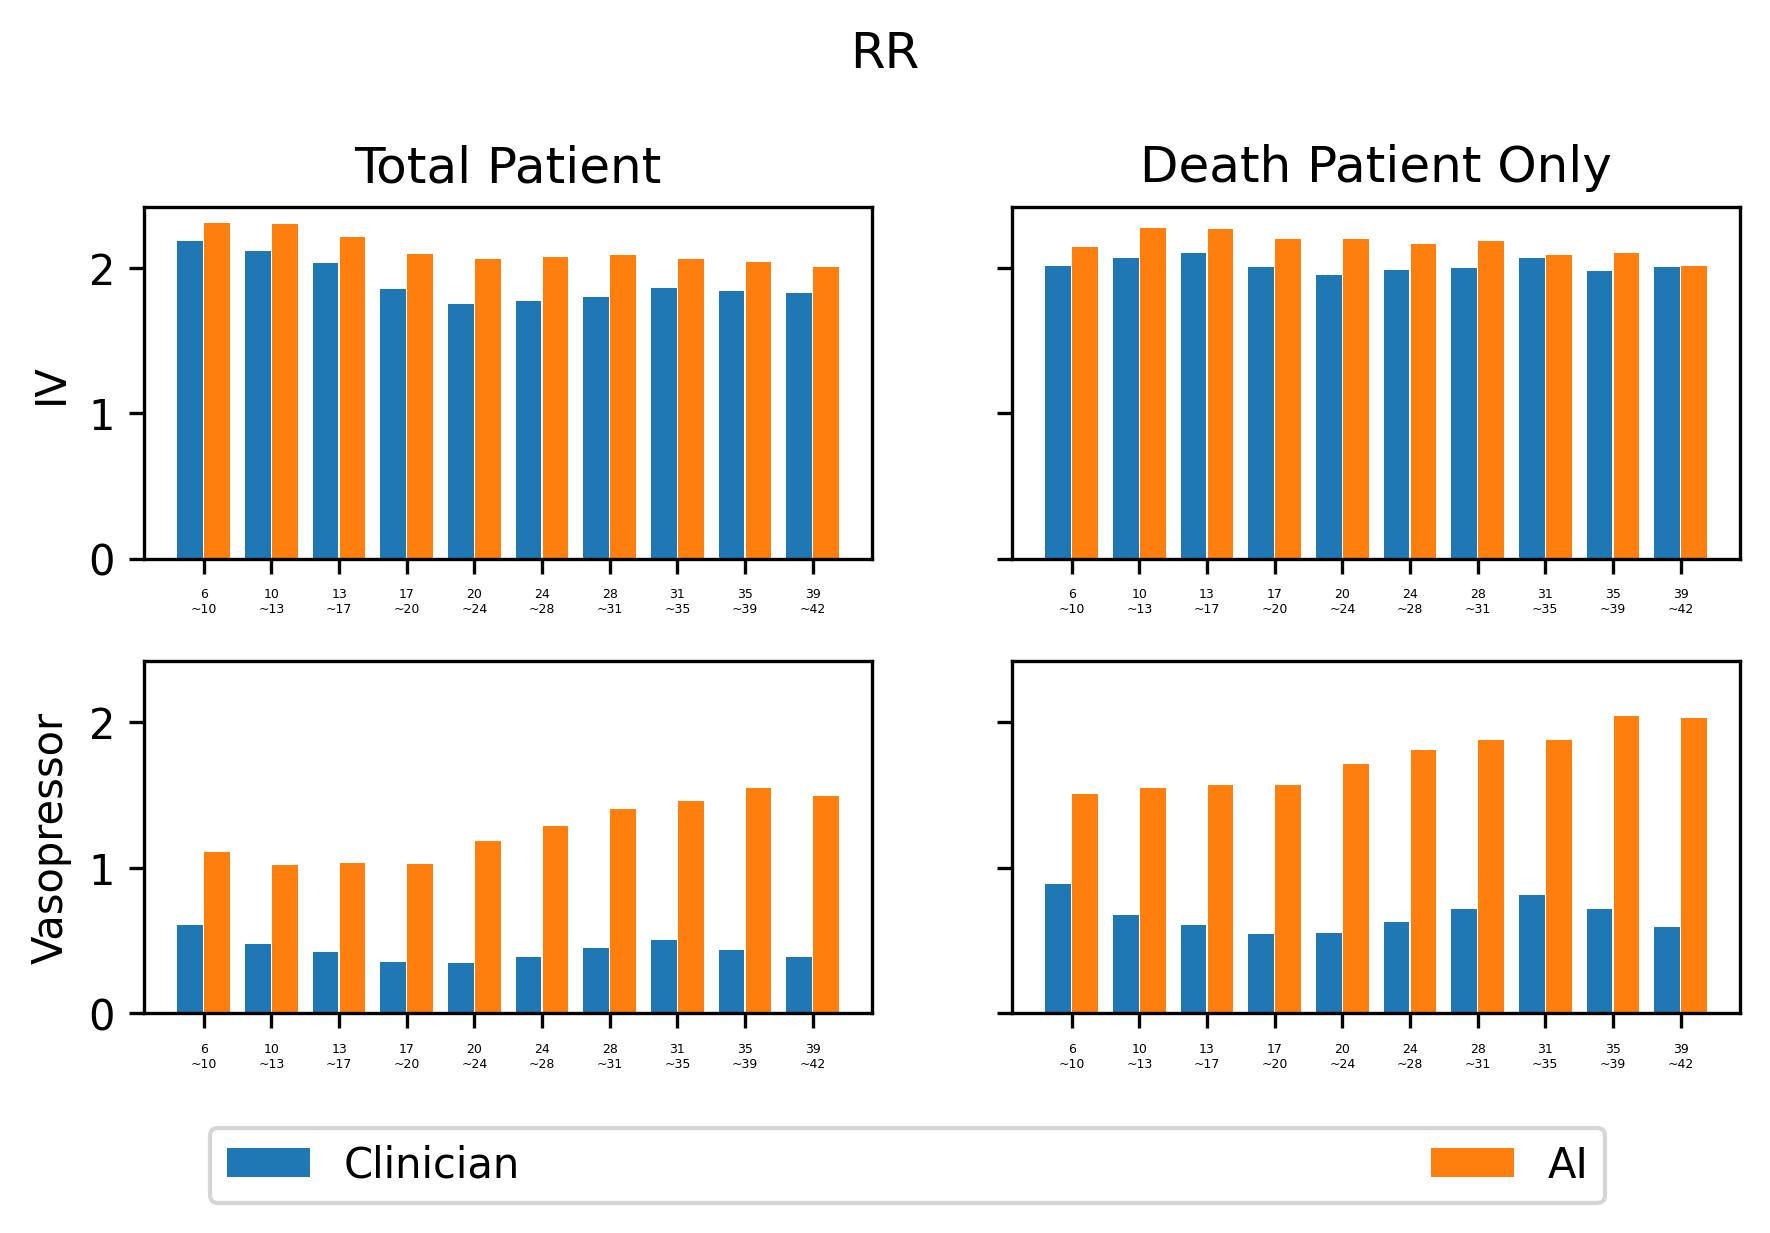

HR
q1: 42.3		q3: 145.4
count    257162.000000
mean         87.075723
std          16.745040
min           0.000000
25%          75.000000
50%          86.000000
75%          98.000000
max         190.000000
Name: HR, dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  from ipykernel import kernelapp as app


    HR  phys_iv   size
0    0        0    526
1    0        1    312
2    0        2    397
3    0        3    386
4    0        4    341
5    1        0   3858
6    1        1   2434
7    1        2   2679
8    1        3   2585
9    1        4   2239
10   2        0  11159
11   2        1   7323
12   2        2   7435
13   2        3   7130
14   2        4   5992
15   3        0  15477
16   3        1  11157
17   3        2  11054
18   3        3  10713
19   3        4  10249
20   4        0  14852
21   4        1  11570
22   4        2  11220
23   4        3  11134
24   4        4  10557
25   5        0  10171
26   5        1   8585
27   5        2   8404
28   5        3   8313
29   5        4   8461
30   6        0   5423
31   6        1   4392
32   6        2   4645
33   6        3   4532
34   6        4   5668
35   7        0   2038
36   7        1   1784
37   7        2   1966
38   7        3   1948
39   7        4   2971
40   8        0    671
41   8        1    512
42   8     

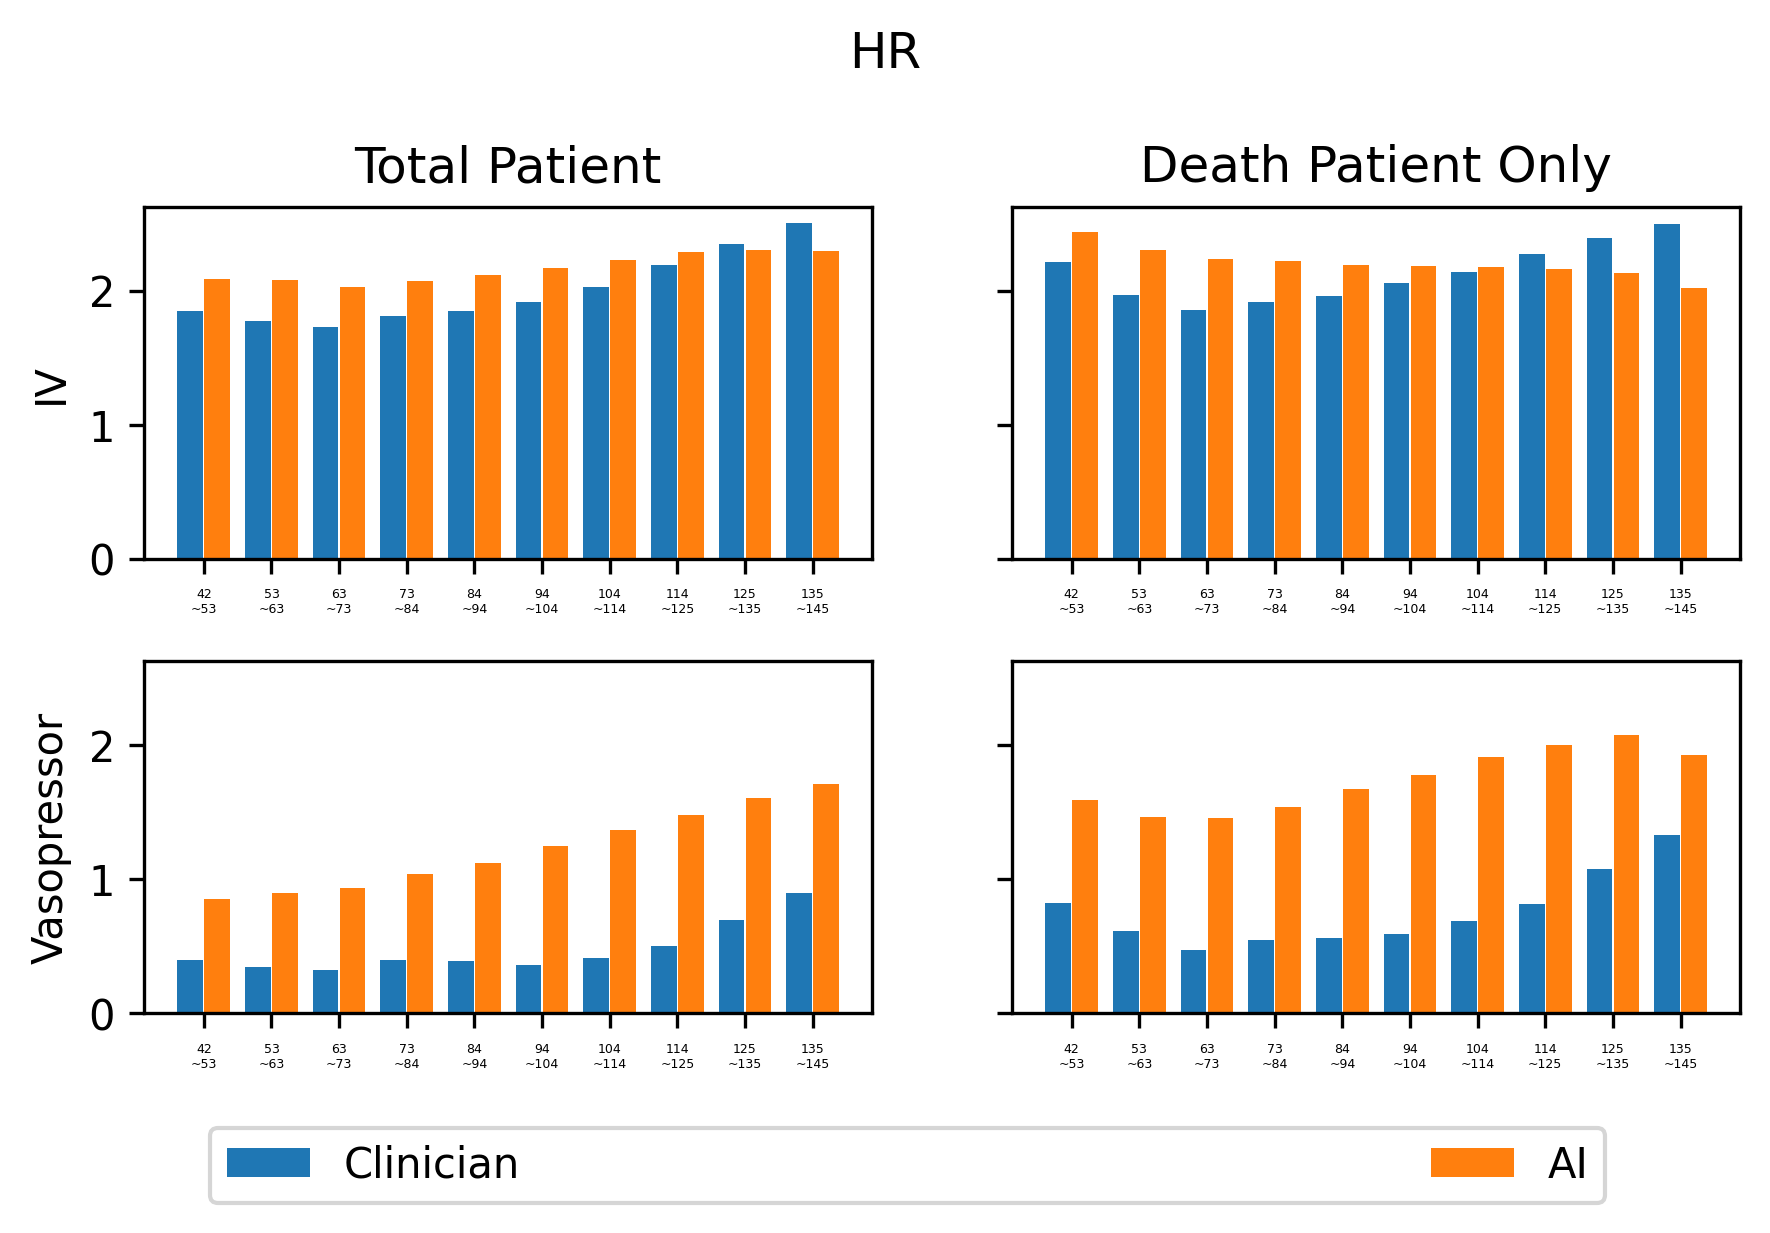

Shock_Index
q1: 0.3124463075722092		q3: 1.7119247533642534
count    257162.000000
mean          0.748039
std           0.195968
min           0.000000
25%           0.608696
50%           0.726786
75%           0.863188
max           1.712299
Name: Shock_Index, dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  from ipykernel import kernelapp as app


    Shock_Index  phys_iv   size
0             0        0   2600
1             0        1   1745
2             0        2   1923
3             0        3   1845
4             0        4   1222
5             1        0  13062
6             1        1   8904
7             1        2   9135
8             1        3   8972
9             1        4   6634
10            2        0  20030
11            2        1  14463
12            2        2  14415
13            2        3  14173
14            2        4  12175
15            3        0  15692
16            3        1  12504
17            3        2  12193
18            3        3  11875
19            3        4  12347
20            4        0   8430
21            4        1   6960
22            4        2   6764
23            4        3   6549
24            4        4   8327
25            5        0   3161
26            5        1   2476
27            5        2   2770
28            5        3   2668
29            5        4   4323
30      

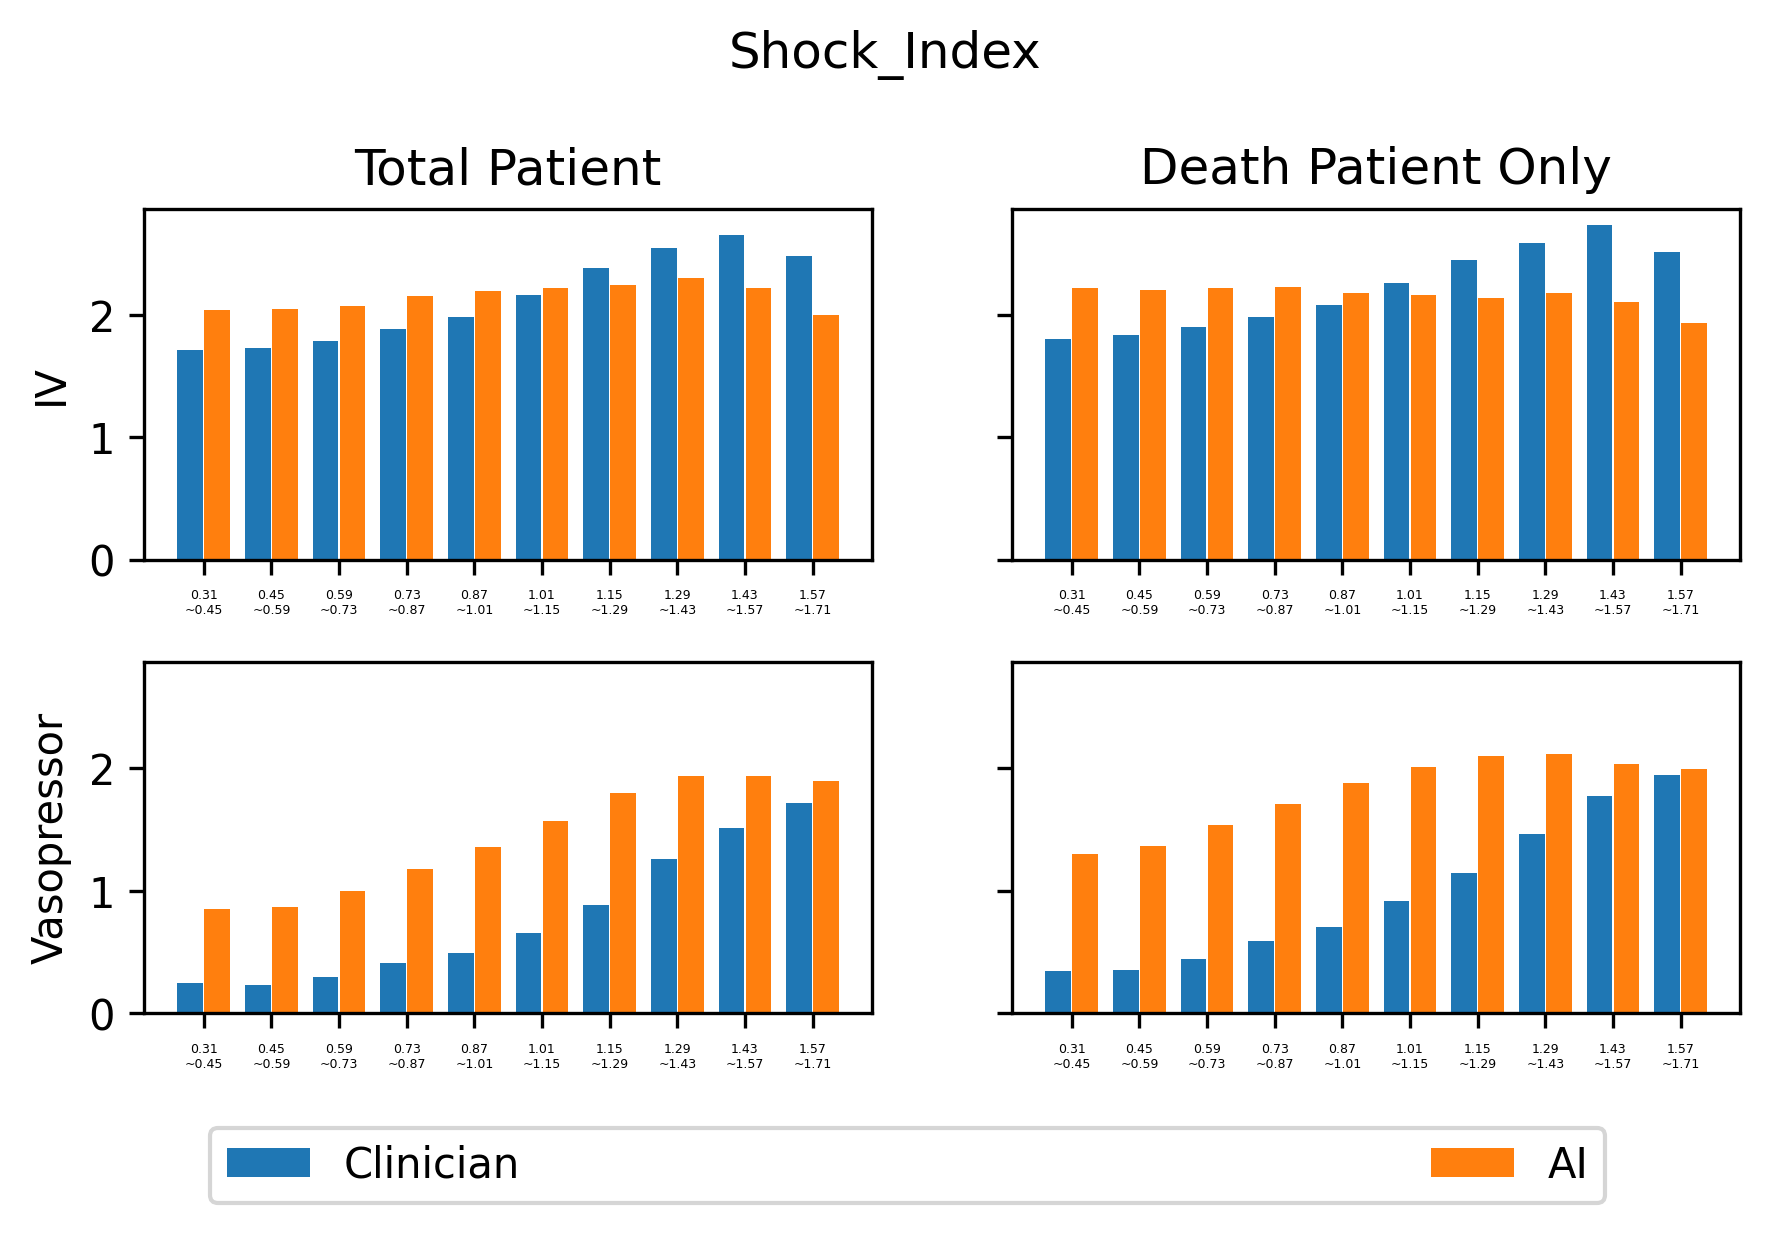

WBC_count
q1: 0.09999999999999999		q3: 84.3
count    257162.000000
mean         12.246891
std           8.120646
min           0.000000
25%           7.800000
50%          10.900000
75%          14.900000
max         462.600000
Name: WBC_count, dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  from ipykernel import kernelapp as app


    WBC_count  phys_iv   size
0           0        0  22394
1           0        1  14987
2           0        2  14636
3           0        3  14183
4           0        4  13583
5           1        0  33506
6           1        1  25162
7           1        2  24963
8           1        3  24596
9           1        4  23881
10          2        0   6683
11          2        1   6386
12          2        2   6870
13          2        3   6591
14          2        4   7655
15          3        0   1324
16          3        1   1210
17          3        2   1460
18          3        3   1488
19          3        4   1963
20          4        0    276
21          4        1    309
22          4        2    407
23          4        3    421
24          4        4    641
25          5        0     85
26          5        1    100
27          5        2    133
28          5        3    144
29          5        4    178
30          6        0     59
31          6        1     34
32        

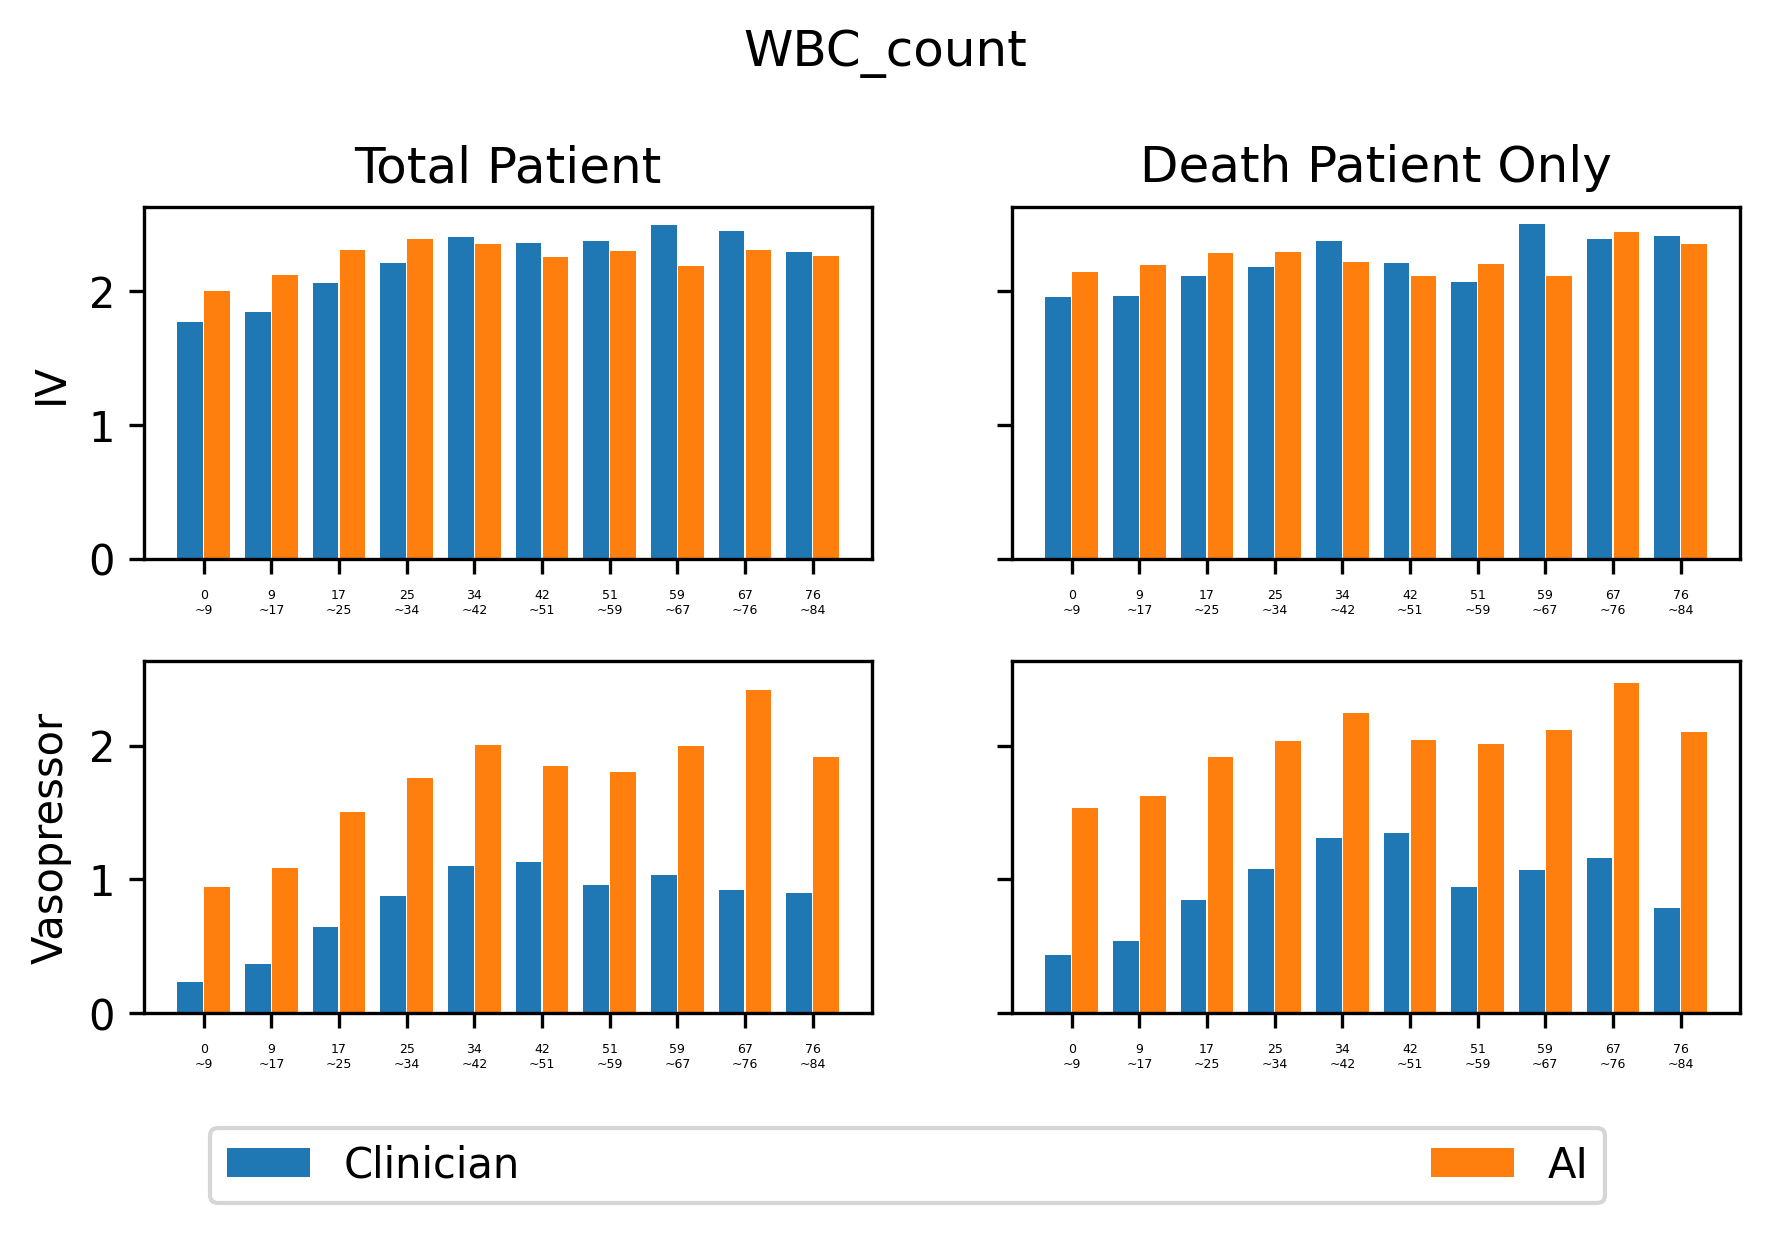

MeanBP
q1: 40.354802047220865		q3: 130.0
count    257162.000000
mean         78.092918
std          13.382012
min           0.000000
25%          68.611112
50%          76.500000
75%          86.000000
max         189.875000
Name: MeanBP, dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  from ipykernel import kernelapp as app


    MeanBP  phys_iv   size
0        0        0    237
1        0        1    200
2        0        2     98
3        0        3    119
4        0        4    263
5        1        0   2310
6        1        1   1631
7        1        2   1426
8        1        3   1484
9        1        4   2430
10       2        0  10935
11       2        1   7980
12       2        2   7911
13       2        3   7253
14       2        4   9487
15       3        0  18194
16       3        1  13592
17       3        2  13631
18       3        3  12918
19       3        4  14018
20       4        0  15880
21       4        1  11658
22       4        2  11670
23       4        3  11529
24       4        4  10861
25       5        0   9468
26       5        1   7211
27       5        2   7555
28       5        3   7626
29       5        4   5992
30       6        0   4621
31       6        1   3696
32       6        2   3941
33       6        3   4159
34       6        4   2976
35       7        0   1858
3

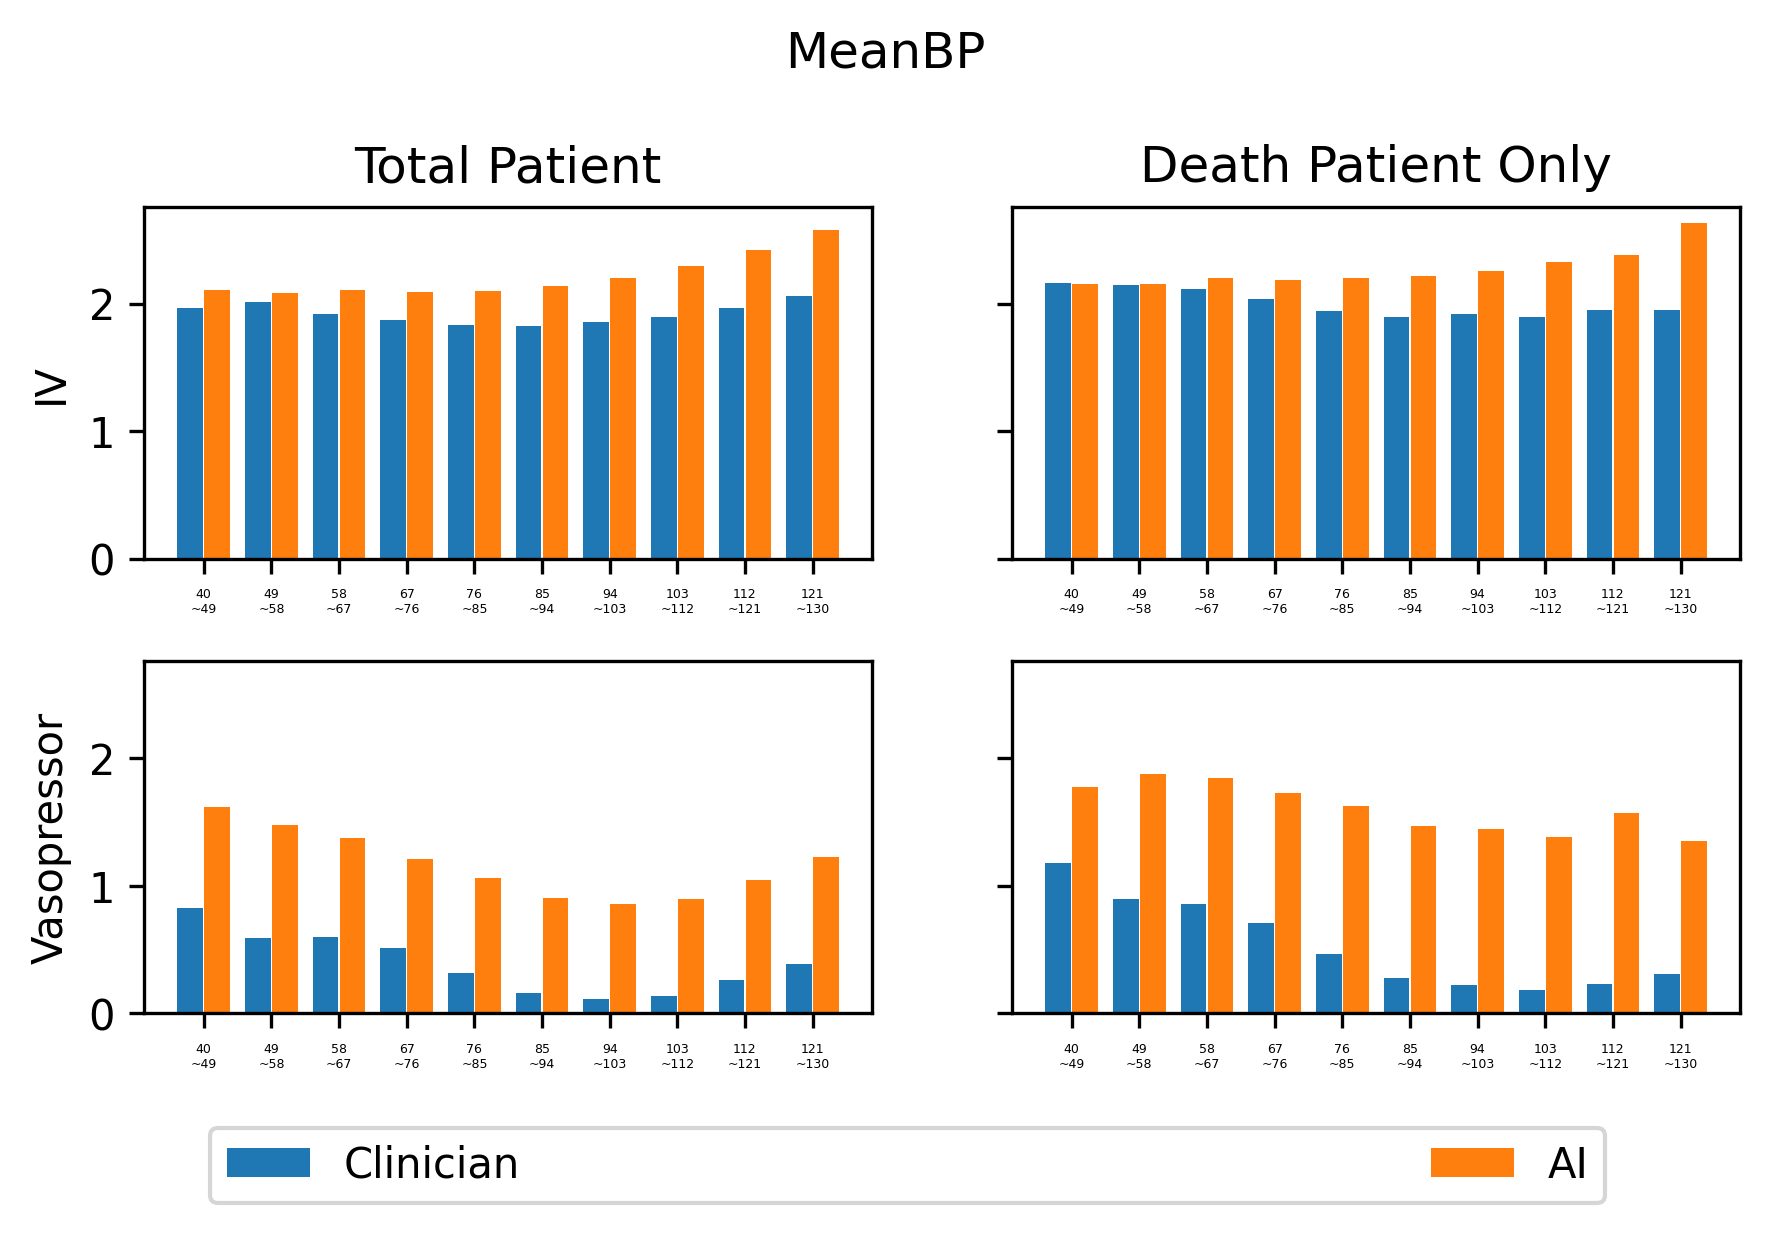

DiaBP
q1: 18.25575		q3: 107.66666666666667
count    257162.000000
mean         57.034662
std          13.249530
min         -58.000000
25%          48.090909
50%          56.250000
75%          65.062500
max         214.071429
Name: DiaBP, dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  from ipykernel import kernelapp as app


    DiaBP  phys_iv   size
0       0        0    413
1       0        1    274
2       0        2    253
3       0        3    261
4       0        4    384
5       1        0   2394
6       1        1   1802
7       1        2   1587
8       1        3   1673
9       1        4   2225
10      2        0   8745
11      2        1   6088
12      2        2   5933
13      2        3   5744
14      2        4   6996
15      3        0  16583
16      3        1  12601
17      3        2  12209
18      3        3  11639
19      3        4  12859
20      4        0  16847
21      4        1  12781
22      4        2  13317
23      4        3  12791
24      4        4  12486
25      5        0  11241
26      5        1   8567
27      5        2   8782
28      5        3   8718
29      5        4   7471
30      6        0   5257
31      6        1   3979
32      6        2   4280
33      6        3   4336
34      6        4   3591
35      7        0   2040
36      7        1   1534
37      7   

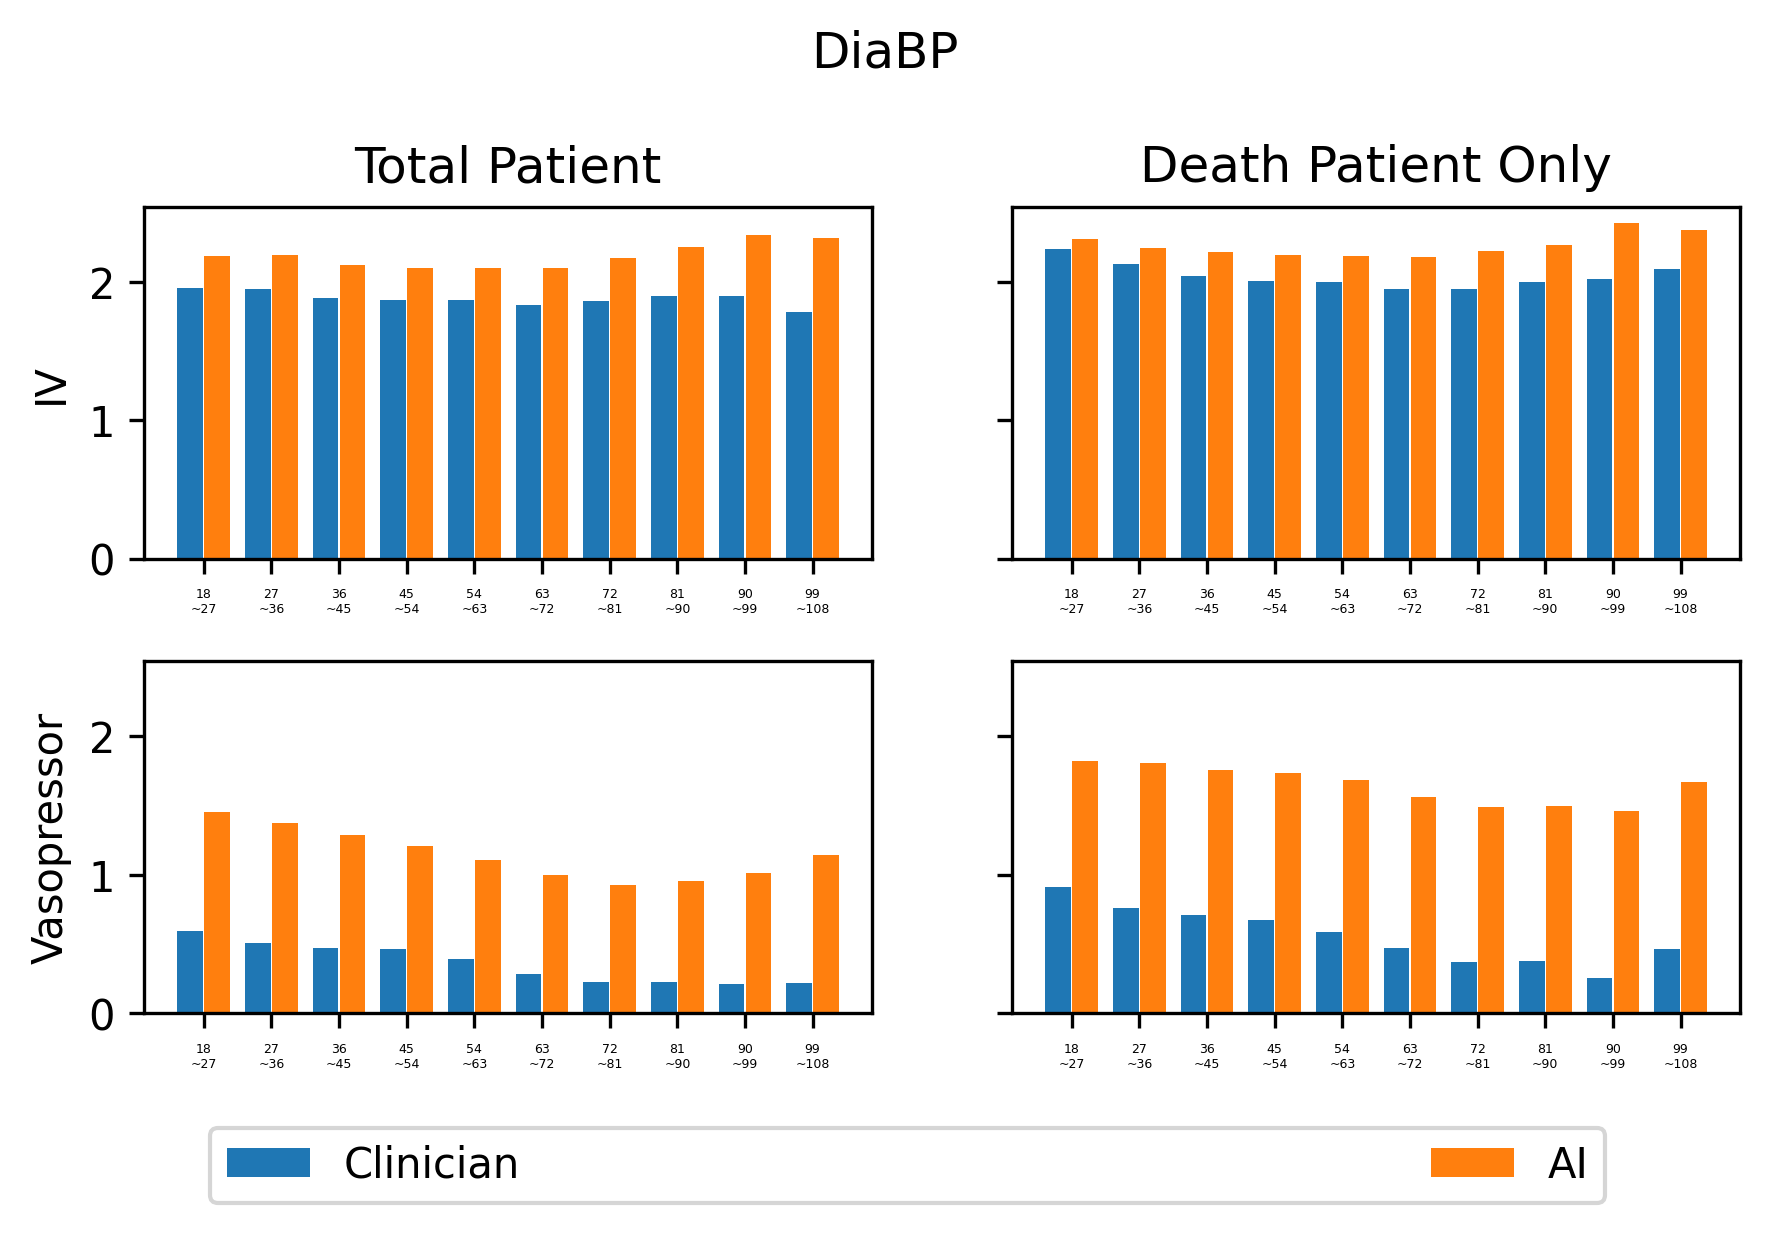

previous_dose
q1: 0.0		q3: 5488.004922217151
count    257162.000000
mean        292.611587
std         564.822459
min           0.000000
25%           0.000000
50%          64.500000
75%         346.855375
max       20359.642000
Name: previous_dose, dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  from ipykernel import kernelapp as app


    previous_dose  phys_iv   size
0               0        0  63291
1               0        1  45901
2               0        2  45241
3               0        3  39054
4               0        4  21269
5               1        0    832
6               1        1   1601
7               1        2   2342
8               1        3   6140
9               1        4  15263
10              2        0    184
11              2        1    347
12              2        2    631
13              2        3   1449
14              2        4   5678
15              3        0     90
16              3        1    236
17              3        2    219
18              3        3    421
19              3        4   2721
20              4        0     25
21              4        1     70
22              4        2     86
23              4        3    241
24              4        4   1327
25              5        0     17
26              5        1     52
27              5        2     60
28            

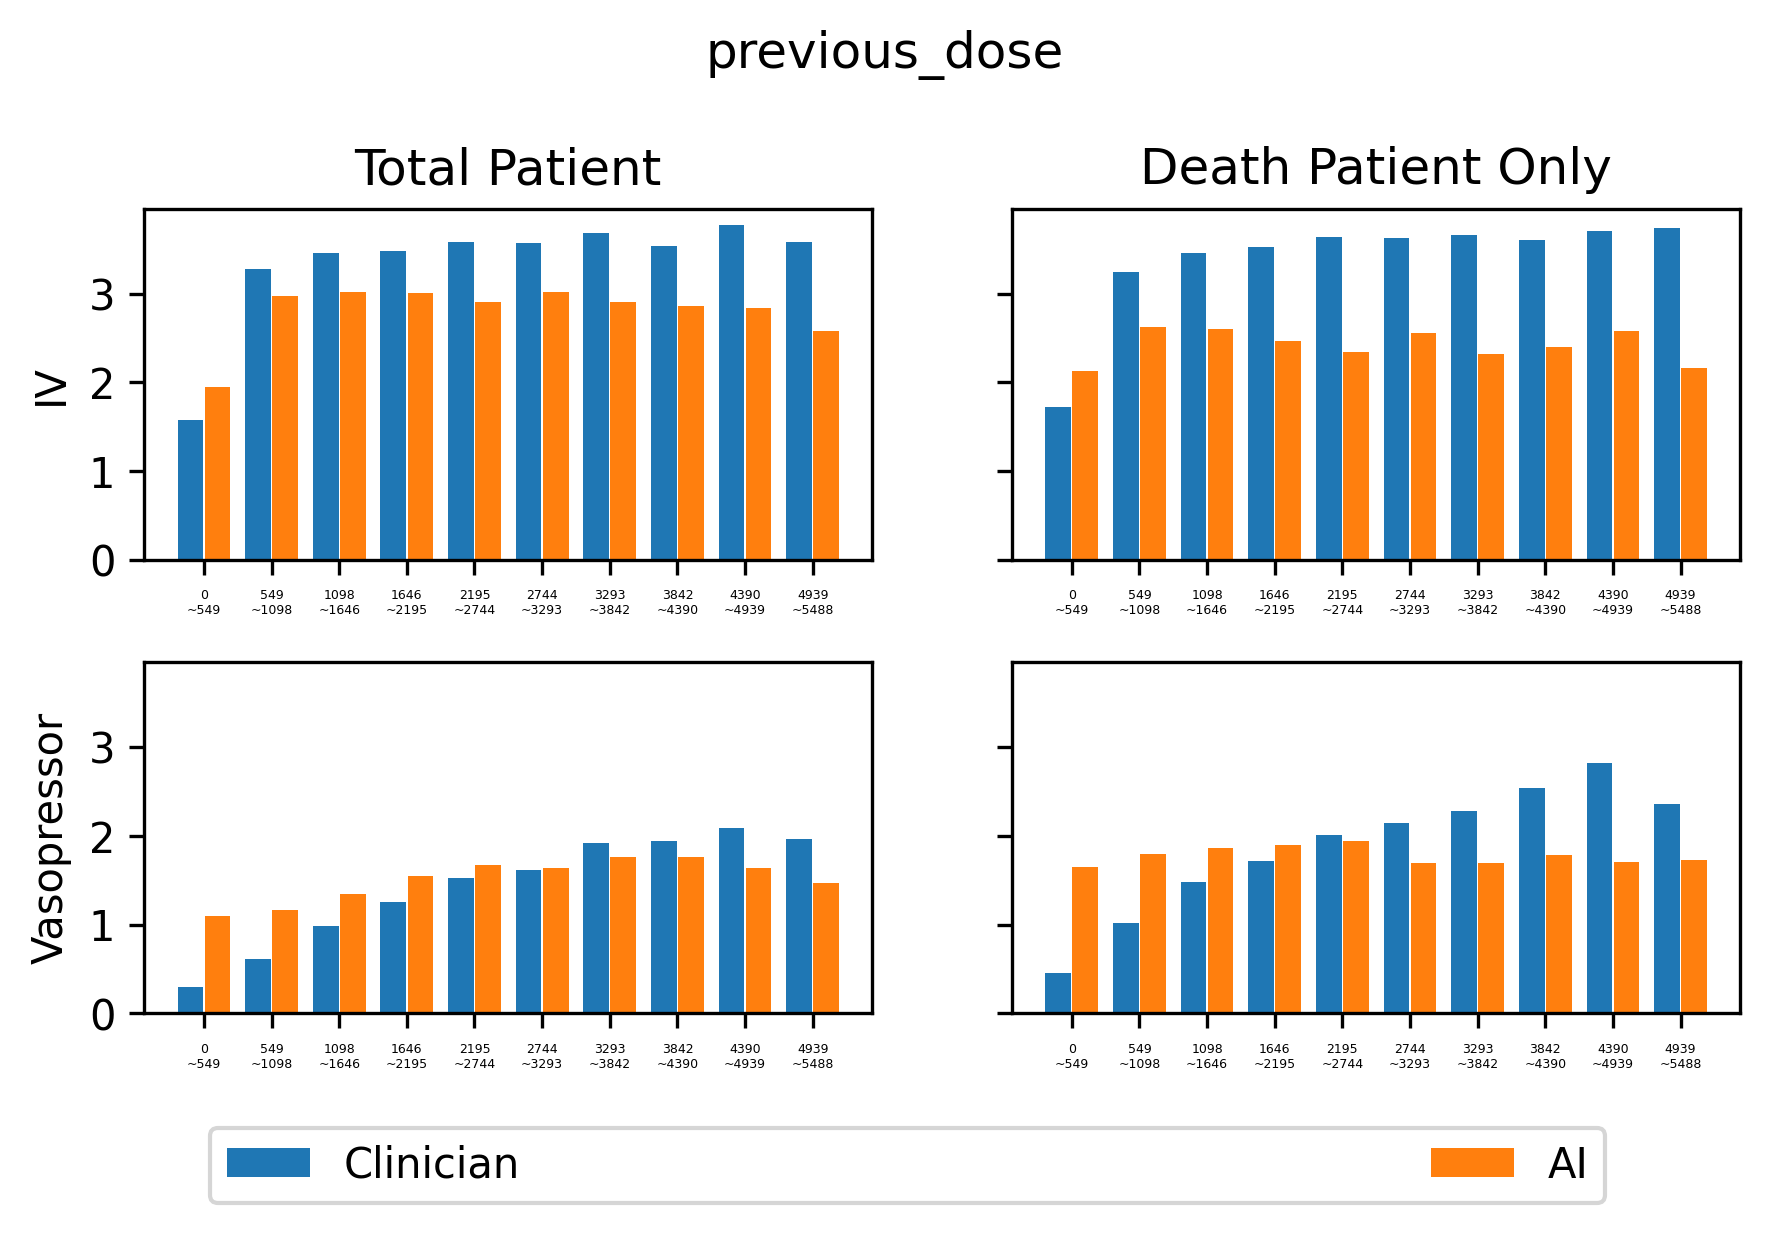

prev_dose_vaso
q1: 0.0		q3: 2.425
count    257162.000000
mean          0.060695
std           0.671397
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         189.076000
Name: prev_dose_vaso, dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  from ipykernel import kernelapp as app


    prev_dose_vaso  phys_iv   size
0                0        0  63540
1                0        1  46821
2                0        2  46386
3                0        3  43805
4                0        4  41499
5                1        0    484
6                1        1    825
7                1        2   1248
8                1        3   1853
9                1        4   2962
10               2        0    179
11               2        1    263
12               2        2    403
13               2        3    654
14               2        4   1126
15               3        0    107
16               3        1    143
17               3        2    235
18               3        3    463
19               3        4    771
20               4        0     49
21               4        1     53
22               4        2     73
23               4        3    218
24               4        4    360
25               5        0     33
26               5        1     47
27               5  

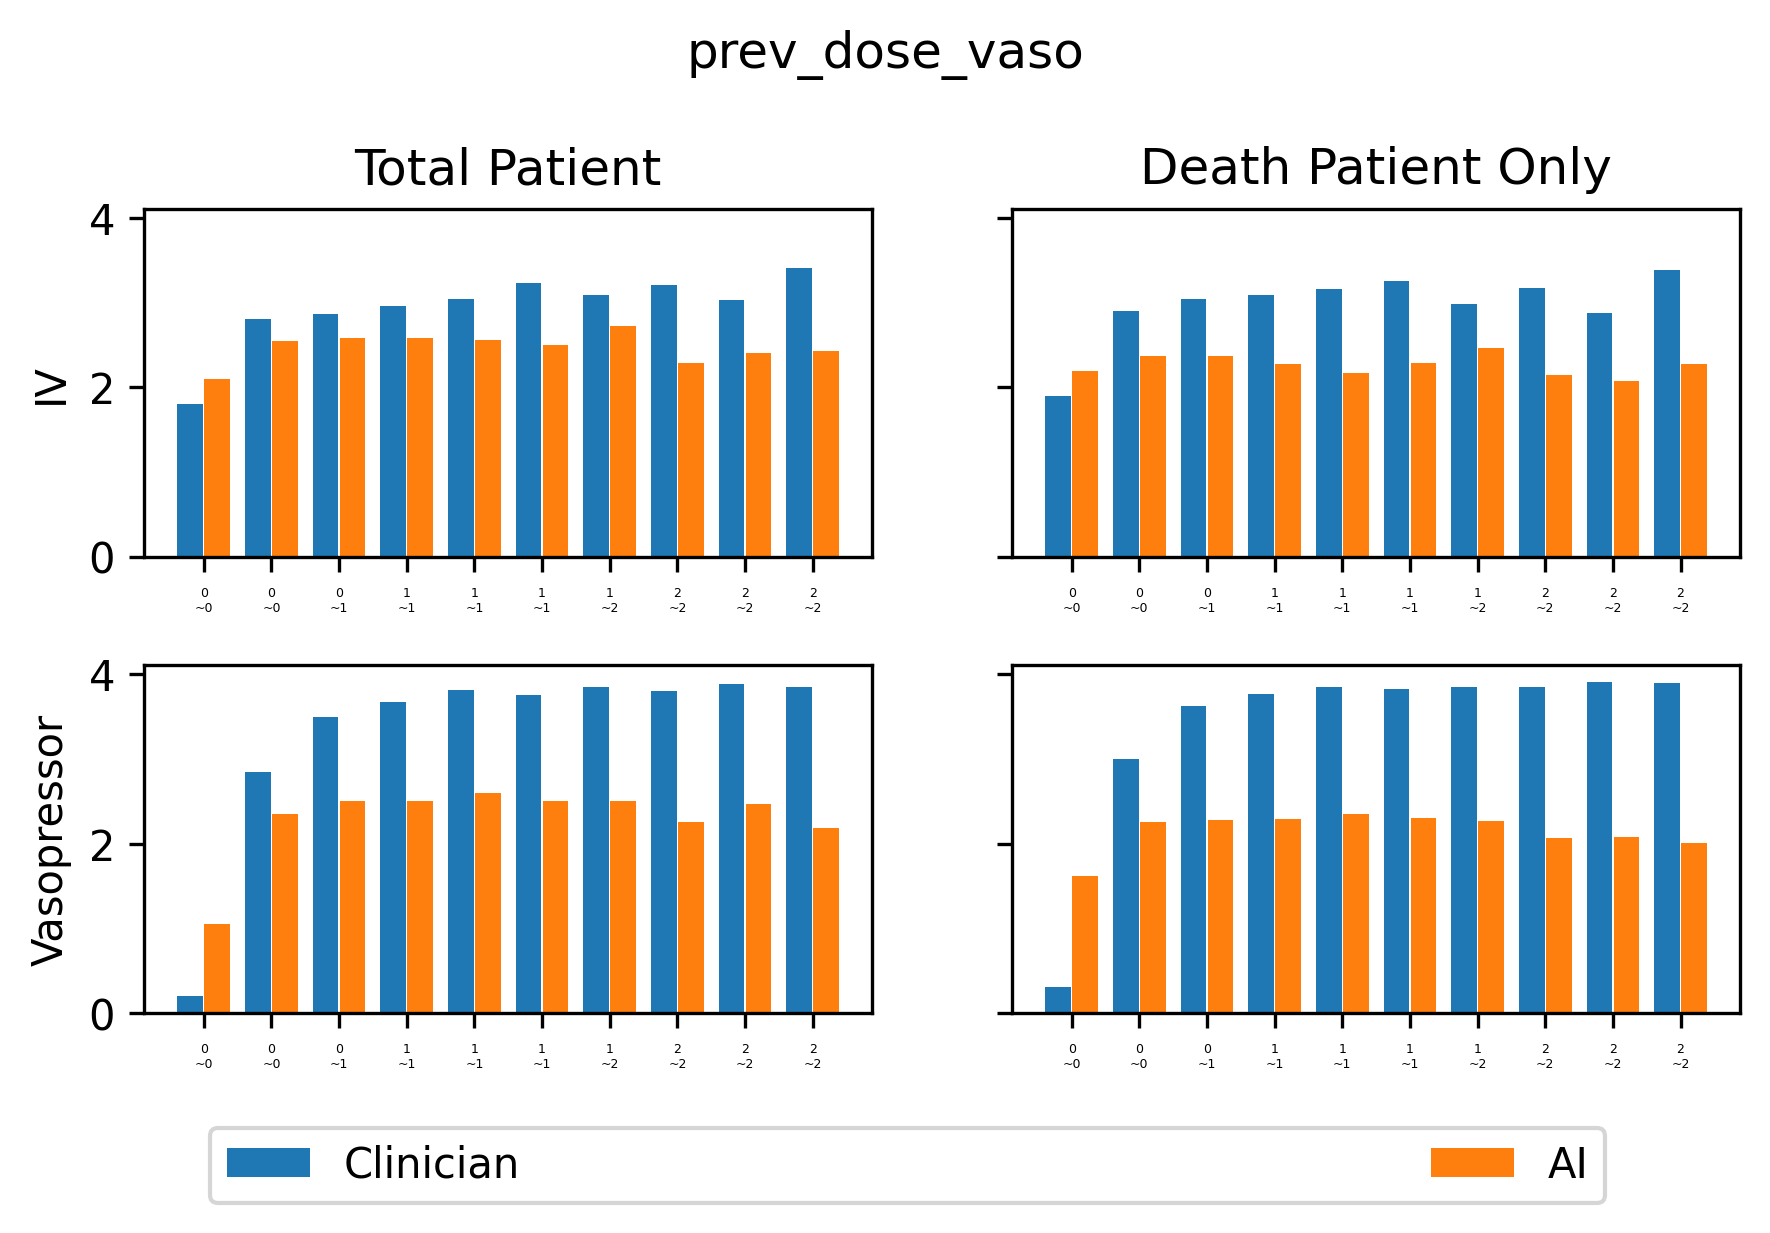

SOFA
q1: 0.0		q3: 20.0
count    257162.000000
mean          6.245876
std           3.510840
min           0.000000
25%           4.000000
50%           6.000000
75%           8.000000
max          24.000000
Name: SOFA, dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  from ipykernel import kernelapp as app


    SOFA  phys_iv   size
0      0        0   8624
1      0        1   6974
2      0        2   5808
3      0        3   6783
4      0        4   5571
5      1        0  13137
6      1        1  11415
7      1        2  10447
8      1        3  10295
9      1        4   8790
10     2        0  15651
11     2        1  11800
12     2        2  11812
13     2        3  10787
14     2        4   9977
15     3        0  13404
16     3        1   8816
17     3        2   9152
18     3        3   8284
19     3        4   8673
20     4        0   7965
21     4        1   5164
22     4        2   5965
23     4        3   5374
24     4        4   6562
25     5        0   3788
26     5        1   2499
27     5        2   2942
28     5        3   3026
29     5        4   4096
30     6        0   1357
31     6        1   1017
32     6        2   1452
33     6        3   1659
34     6        4   2355
35     7        0    413
36     7        1    356
37     7        2    669
38     7        3    763


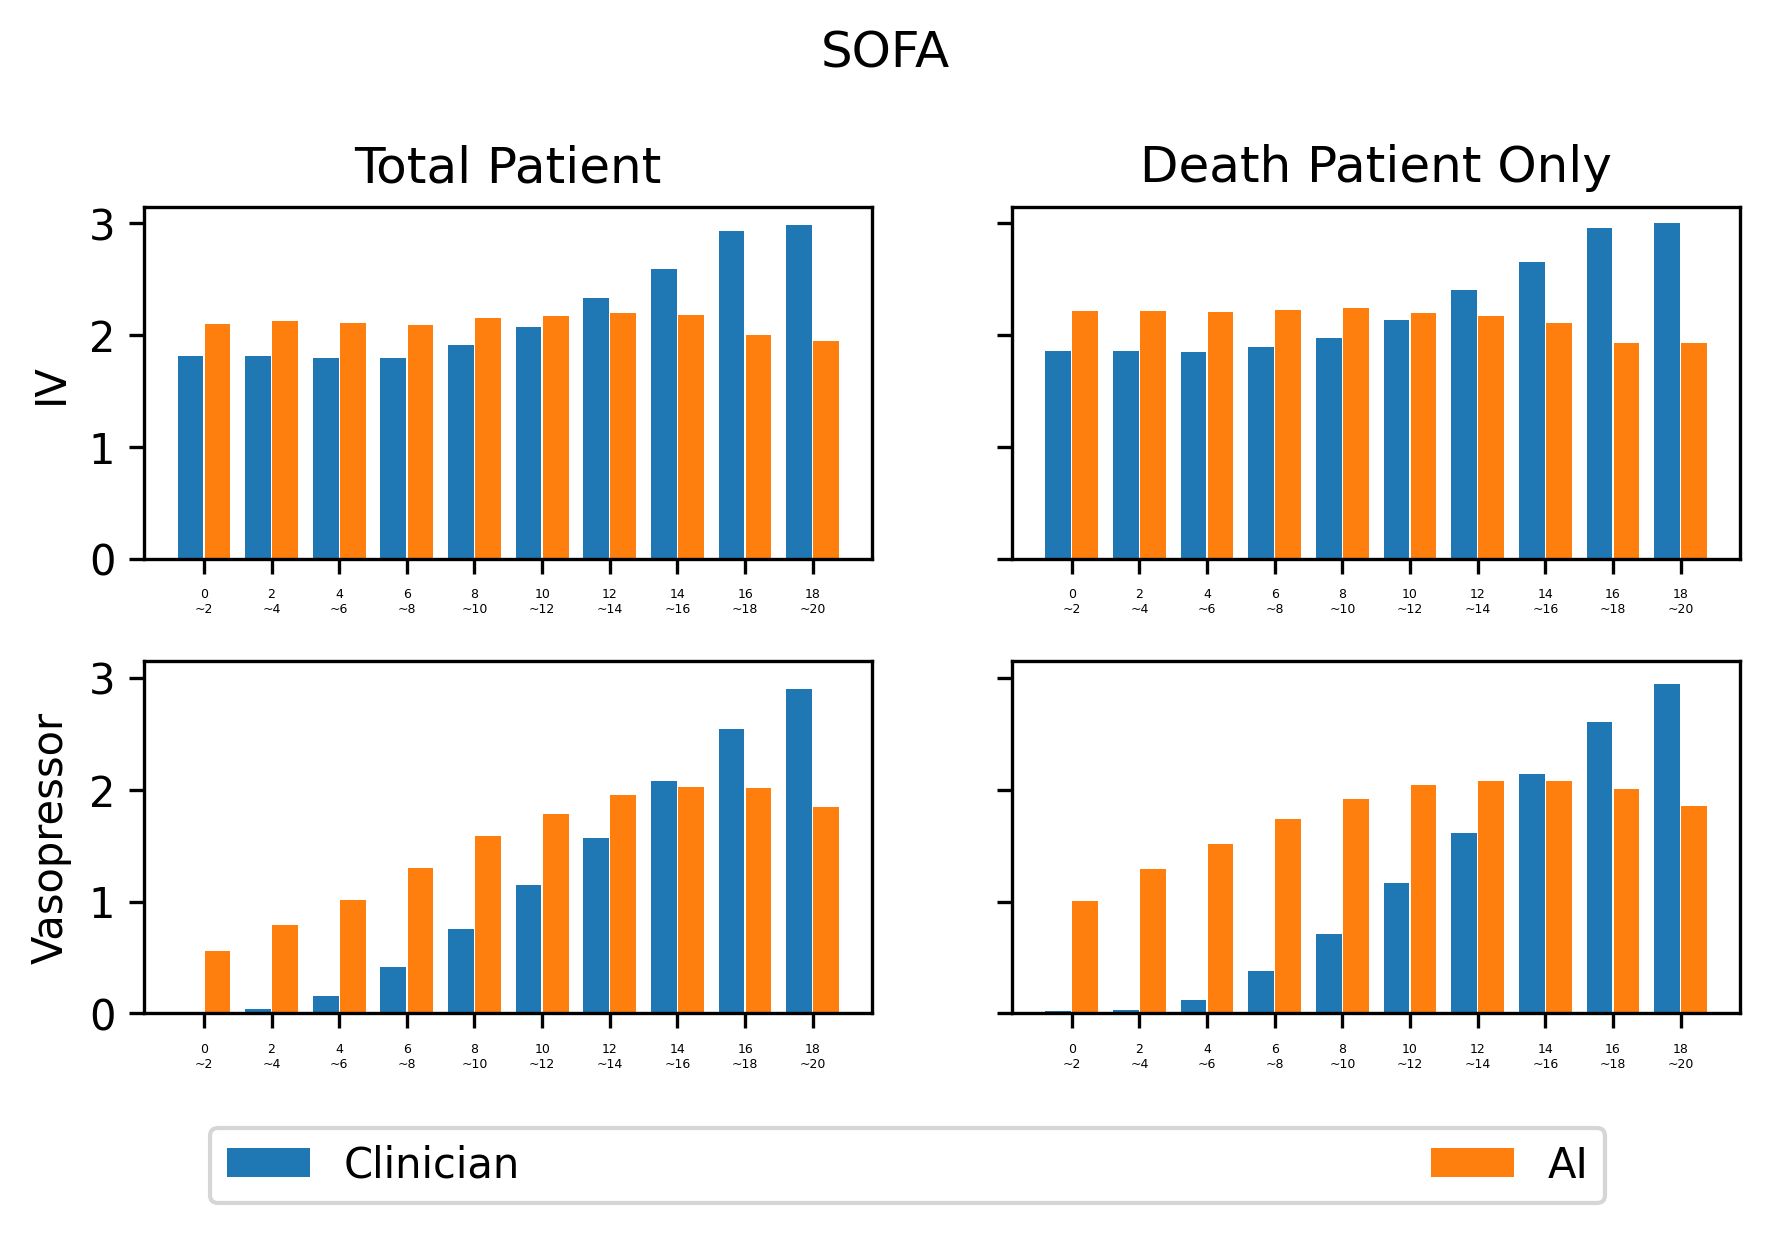

In [10]:
for attribute in query_attributes:
    dataframe = df_mimic
    dataframe_raw = df_mimic_raw_state

    fig, axes = plt.subplots(nrows=2, ncols=2, dpi=300, sharey=True)
    fig.suptitle(attribute)

    num_bins = 10
    q1, q3 = dataframe_raw[attribute].quantile(0.001), dataframe_raw[attribute].quantile(0.999)
    
    print('{}\nq1: {}\t\tq3: {}'.format(attribute, q1, q3))
    print(dataframe_raw[attribute].describe())
    
    dataframe = dataframe.loc[dataframe_raw[attribute].between(q1, q3, inclusive=True)]
    dataframe_raw = dataframe_raw.loc[dataframe_raw[attribute].between(q1, q3, inclusive=True)]
    
    bins_attribute = pd.cut(dataframe_raw[attribute], np.histogram_bin_edges([q1, q3], bins=num_bins), include_lowest=True, labels=False)
#     if attribute == 'age' or attribute == 'BUN':
#         xticks = ["{}\n~{}".format(round(x.left), round(x.right)) for x in sorted(pd.cut(dataframe_raw[attribute], np.histogram_bin_edges([q1, q3], bins=num_bins), include_lowest=True).unique())]
#     else:
#         xticks = ["{}\n~{}".format(x.left, x.right) for x in sorted(pd.cut(dataframe_raw[attribute], np.histogram_bin_edges([q1, q3], bins=num_bins), include_lowest=True).unique())]
#     xticks = ["{}\n~{}".format(x.left, x.right) for x in sorted(pd.cut(dataframe_raw[attribute], np.histogram_bin_edges([q1, q3], bins=num_bins), include_lowest=True).unique())]
    if attribute == 'Shock_Index':
        xticks = ["{}\n~{}".format(round(x.left, 2), round(x.right, 2)) for x in sorted(pd.cut(dataframe_raw[attribute], np.histogram_bin_edges([q1, q3], bins=num_bins), include_lowest=True).unique())]
    else:
        xticks = ["{}\n~{}".format(round(x.left), round(x.right)) for x in sorted(pd.cut(dataframe_raw[attribute], np.histogram_bin_edges([q1, q3], bins=num_bins), include_lowest=True).unique())]

    set_bins_ax(axes[0][0], dataframe, dataframe_raw, attribute, bins_attribute, 'phys', 'iv')
    set_bins_ax(axes[0][0], dataframe, dataframe_raw, attribute, bins_attribute, 'rein', 'iv')
    set_bins_ax(axes[0][1], dataframe.loc[dataframe['death'] == 1], dataframe_raw, attribute, bins_attribute, 'phys', 'iv')
    set_bins_ax(axes[0][1], dataframe.loc[dataframe['death'] == 1], dataframe_raw, attribute, bins_attribute, 'rein', 'iv')

    set_bins_ax(axes[1][0], dataframe, dataframe_raw, attribute, bins_attribute, 'phys', 'vaso')
    set_bins_ax(axes[1][0], dataframe, dataframe_raw, attribute, bins_attribute, 'rein', 'vaso')
    set_bins_ax(axes[1][1], dataframe.loc[dataframe['death'] == 1], dataframe_raw, attribute, bins_attribute, 'phys', 'vaso')
    set_bins_ax(axes[1][1], dataframe.loc[dataframe['death'] == 1], dataframe_raw, attribute, bins_attribute, 'rein', 'vaso')

    track_bins_changes(axes[0][0], dataframe, dataframe_raw, attribute, bins_attribute, 'phys', 'iv')
    track_bins_changes(axes[0][0], dataframe, dataframe_raw, attribute, bins_attribute, 'rein', 'iv')

    
    
    axes[0][0].set_xticks(ticks=range(len(xticks)))
    axes[0][0].set_xticklabels(xticks, fontsize=3)
    axes[0][1].set_xticks(ticks=range(len(xticks)))
    axes[0][1].set_xticklabels(xticks, fontsize=3)
    axes[1][0].set_xticks(ticks=range(len(xticks)))
    axes[1][0].set_xticklabels(xticks, fontsize=3)
    axes[1][1].set_xticks(ticks=range(len(xticks)))
    axes[1][1].set_xticklabels(xticks, fontsize=3)

    bbox = (fig.subplotpars.left, fig.subplotpars.bottom + 0.02,  fig.subplotpars.right - fig.subplotpars.left, -0.08)
    axes[1][0].legend(bbox_to_anchor=bbox, loc=9, ncol=2, mode="expand", borderaxespad=0., bbox_transform=fig.transFigure)

    axes[0][0].set_title('Total Patient')
    axes[0][1].set_title('Death Patient Only')

    axes[0][0].set_ylabel('IV')
    axes[1][0].set_ylabel('Vasopressor')
    plt.tight_layout()

    os.makedirs("result/average_iv_vaso_dose_over_patient/", exist_ok=True)
    plt.savefig("result/average_iv_vaso_dose_over_patient/{}.png".format(attribute))
    plt.show()

In [11]:
df_mimic['phys_iv'].unique()

array([2, 1, 0, 3, 4])

output_4hourly
q1: 0.0		q3: 1580.0
count    257162.000000
mean        316.722154
std         365.907426
min           0.000000
25%          80.000000
50%         220.000000
75%         440.000000
max       15100.000000
Name: output_4hourly, dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  from ipykernel import kernelapp as app


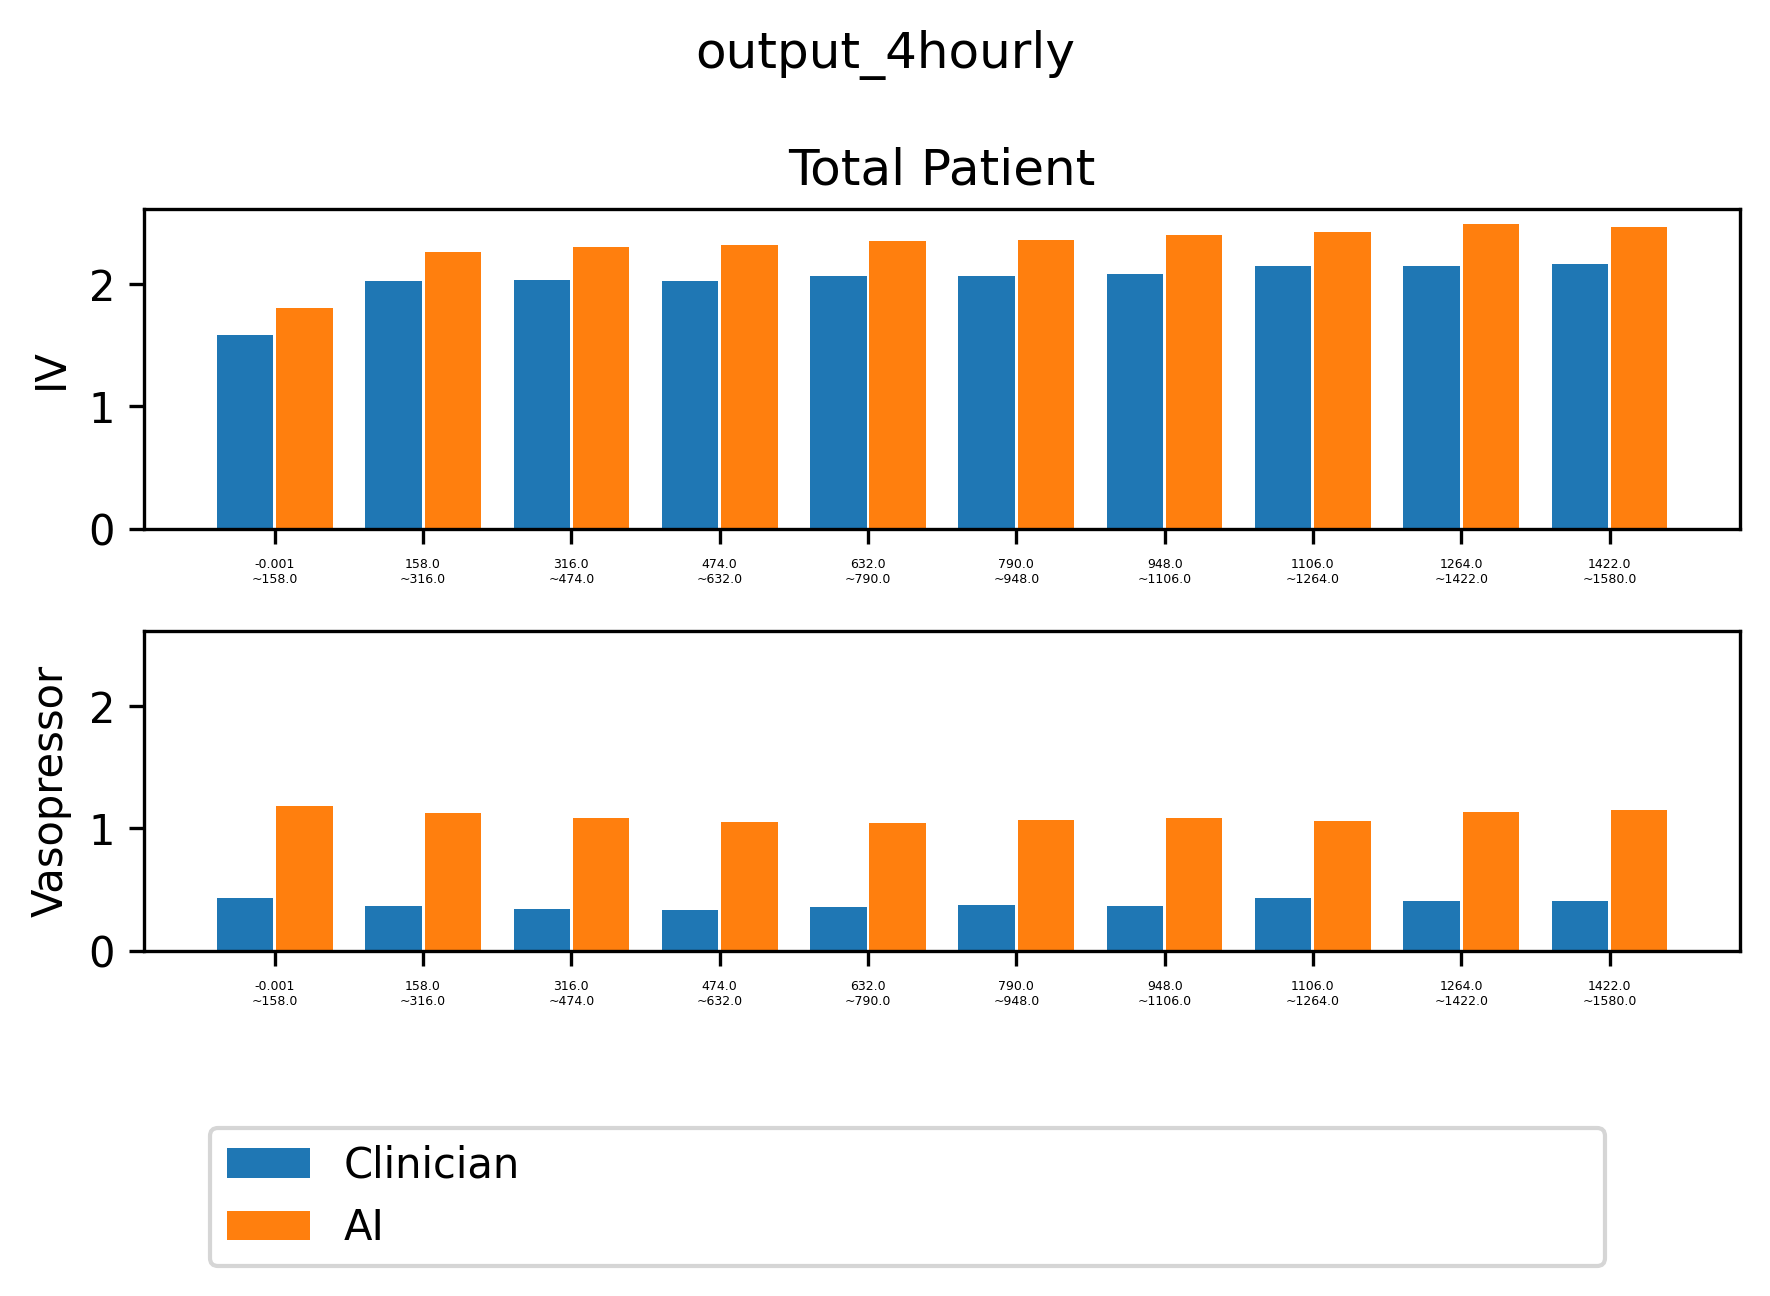

output_total
q1: 0.0		q3: 62207.01999999973
count    257162.000000
mean       6498.129430
std       12660.817868
min           0.000000
25%         870.000000
50%        2495.450001
75%        6465.000000
max      330130.000000
Name: output_total, dtype: float64


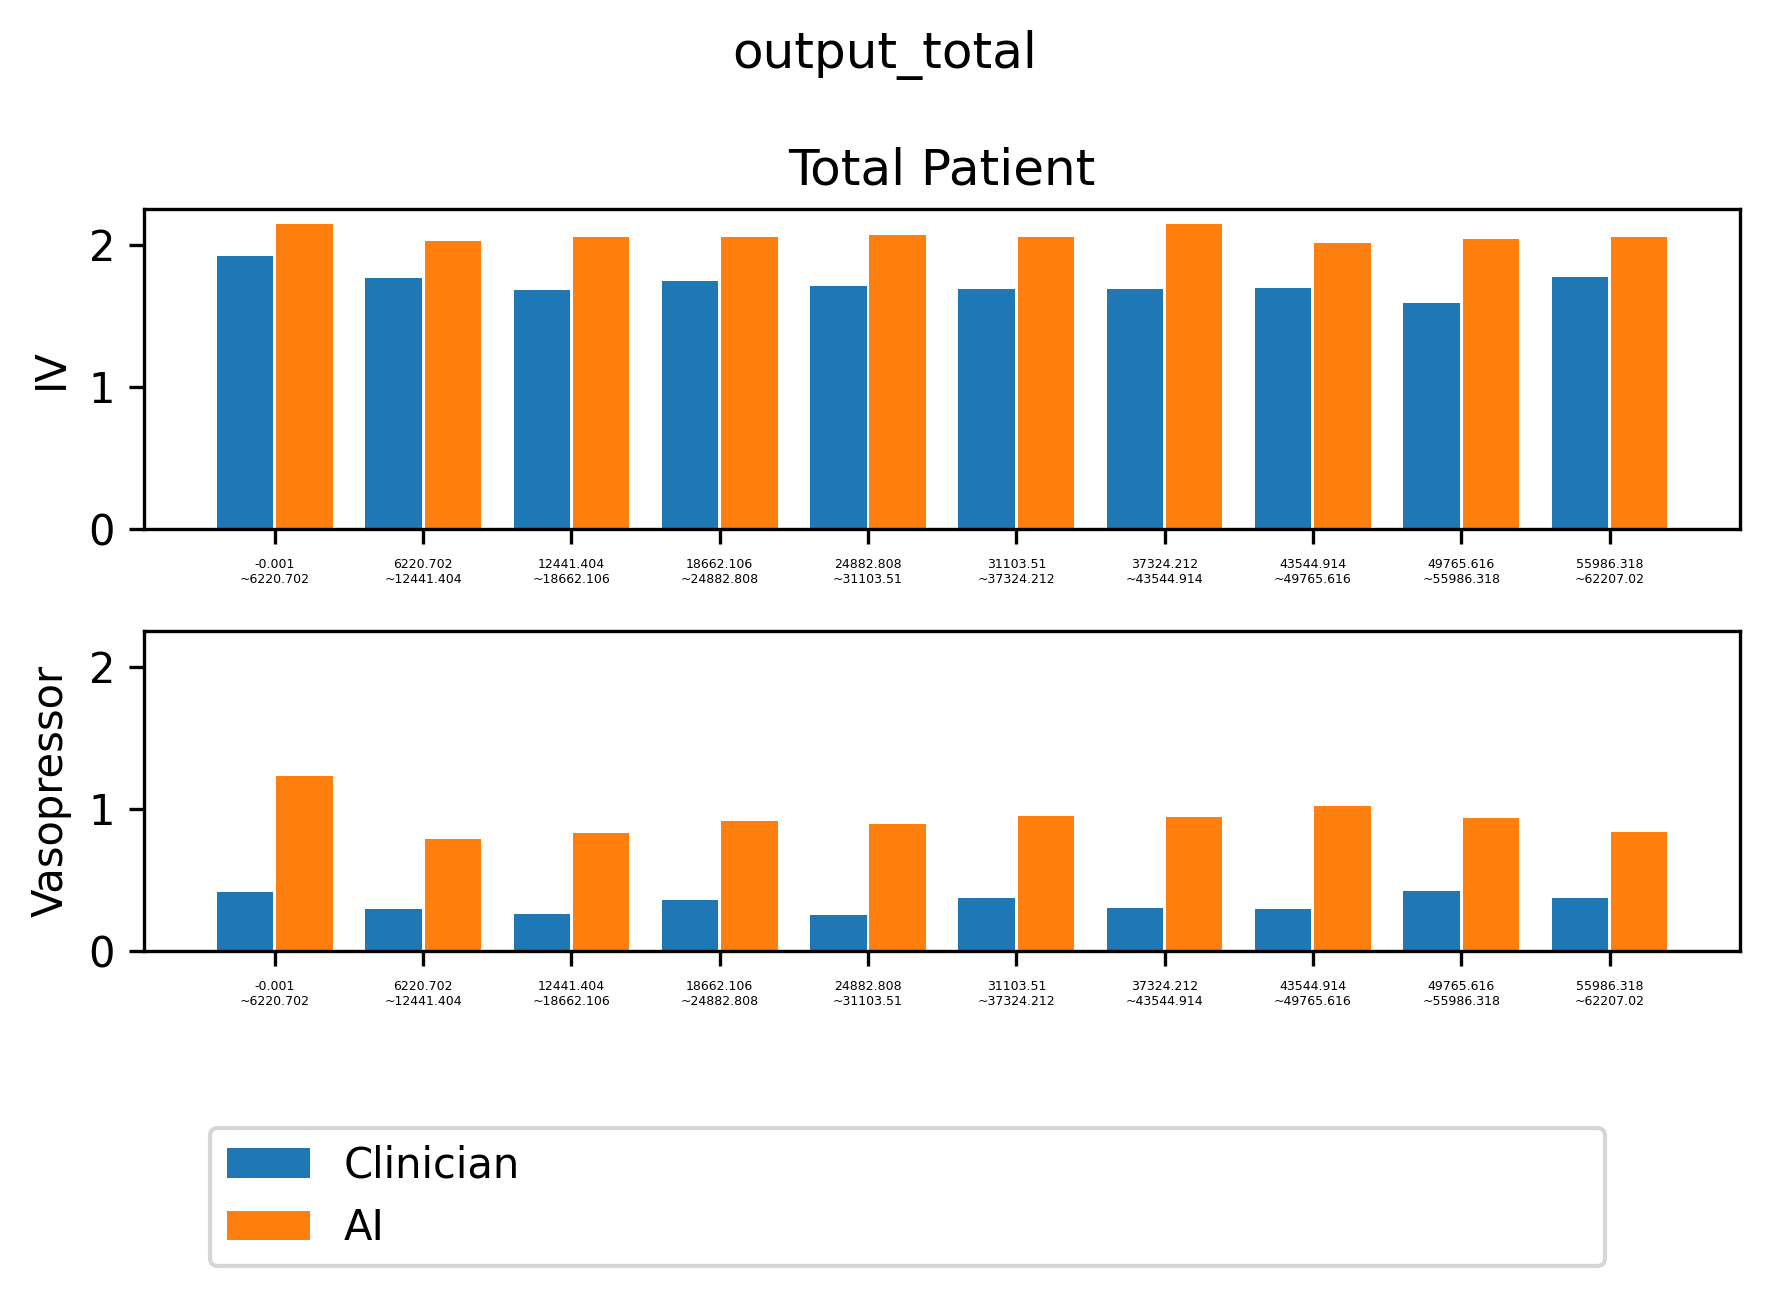

BUN
q1: 4.650416666666672		q3: 112.66666666666667
count    257162.000000
mean         29.227317
std          22.621707
min           0.000000
25%          14.000000
50%          22.000000
75%          37.000000
max         280.000000
Name: BUN, dtype: float64


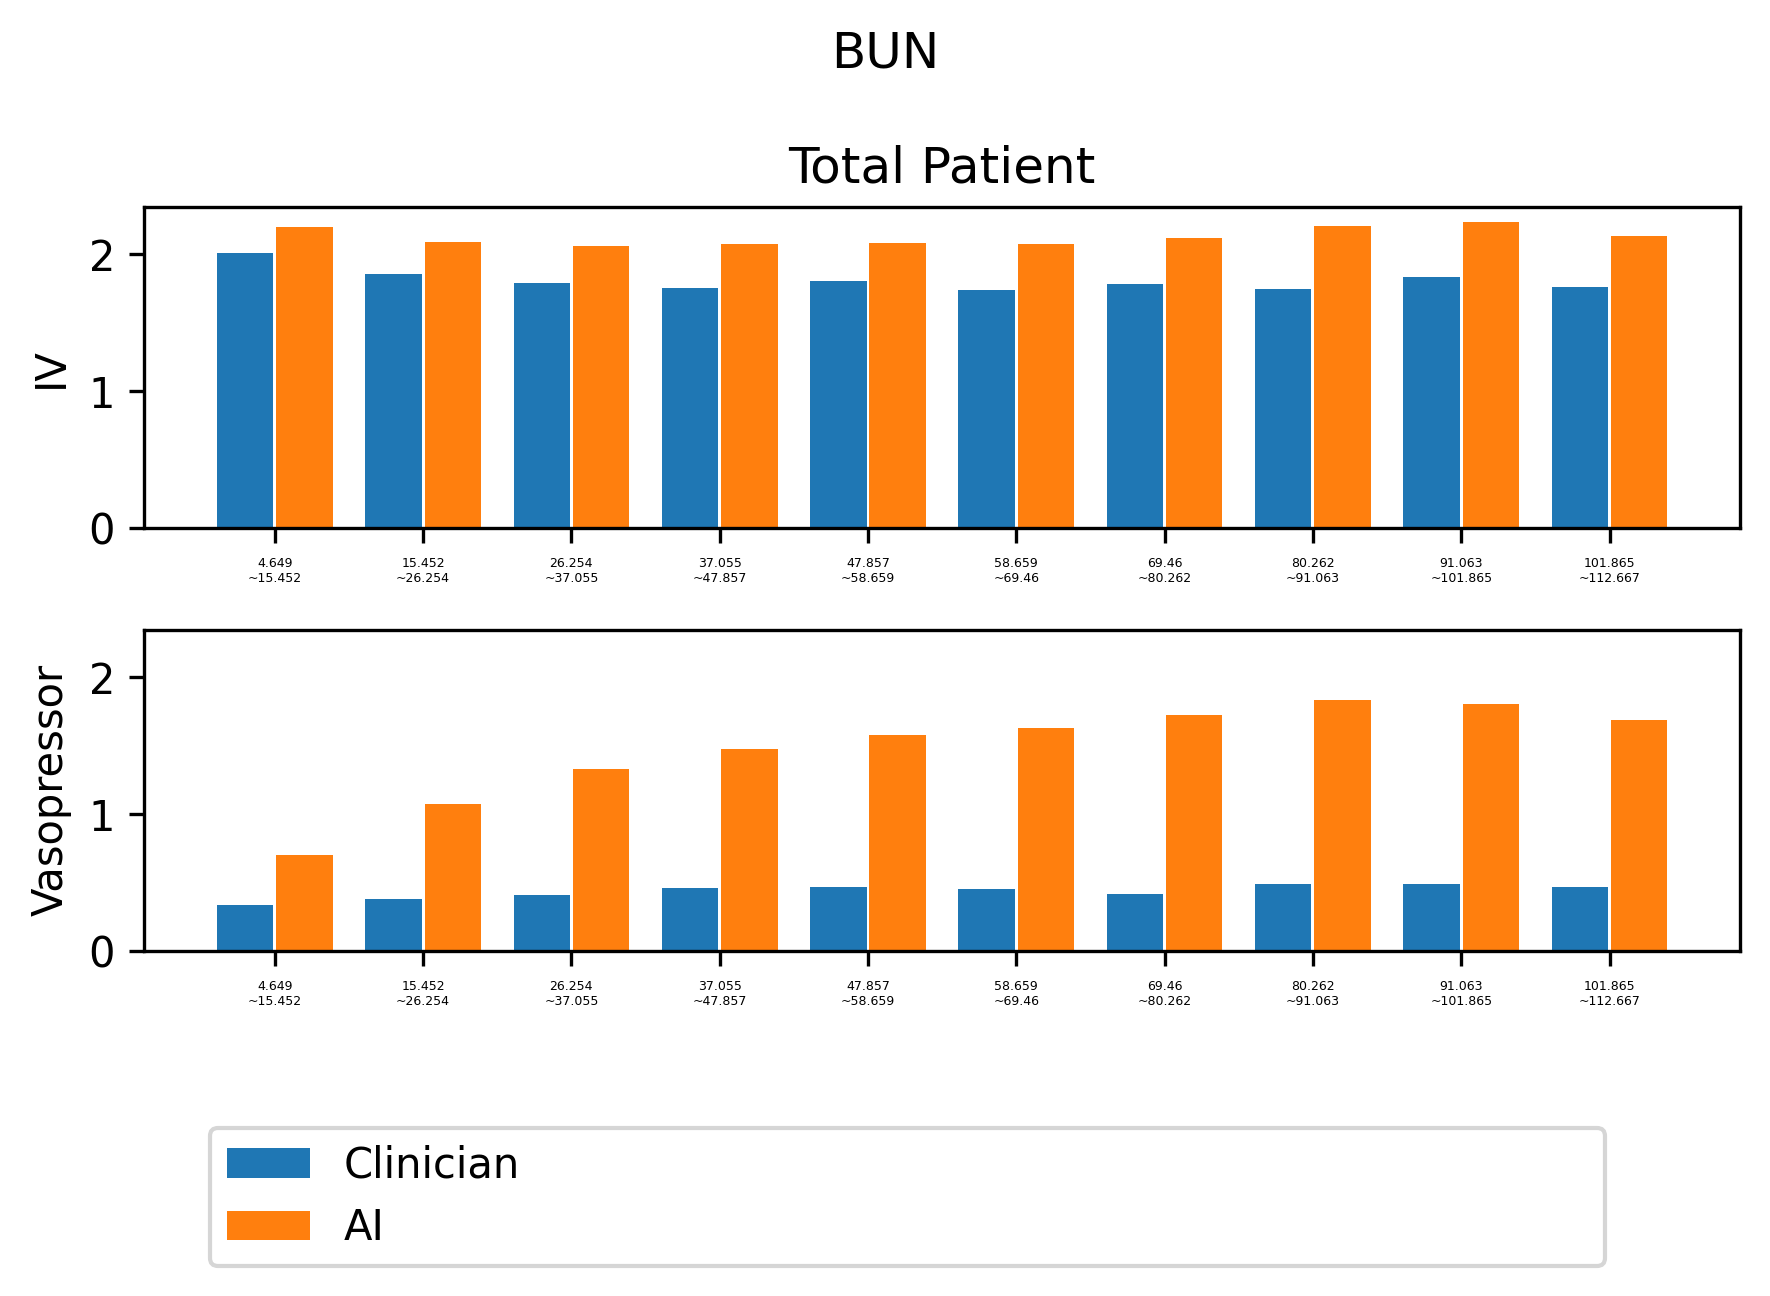

age
q1: 22.021847447207637		q3: 91.39999999999999
count    257162.000000
mean         64.528450
std          16.634035
min          18.021690
25%          53.520375
50%          66.000484
75%          77.713078
max          91.400000
Name: age, dtype: float64


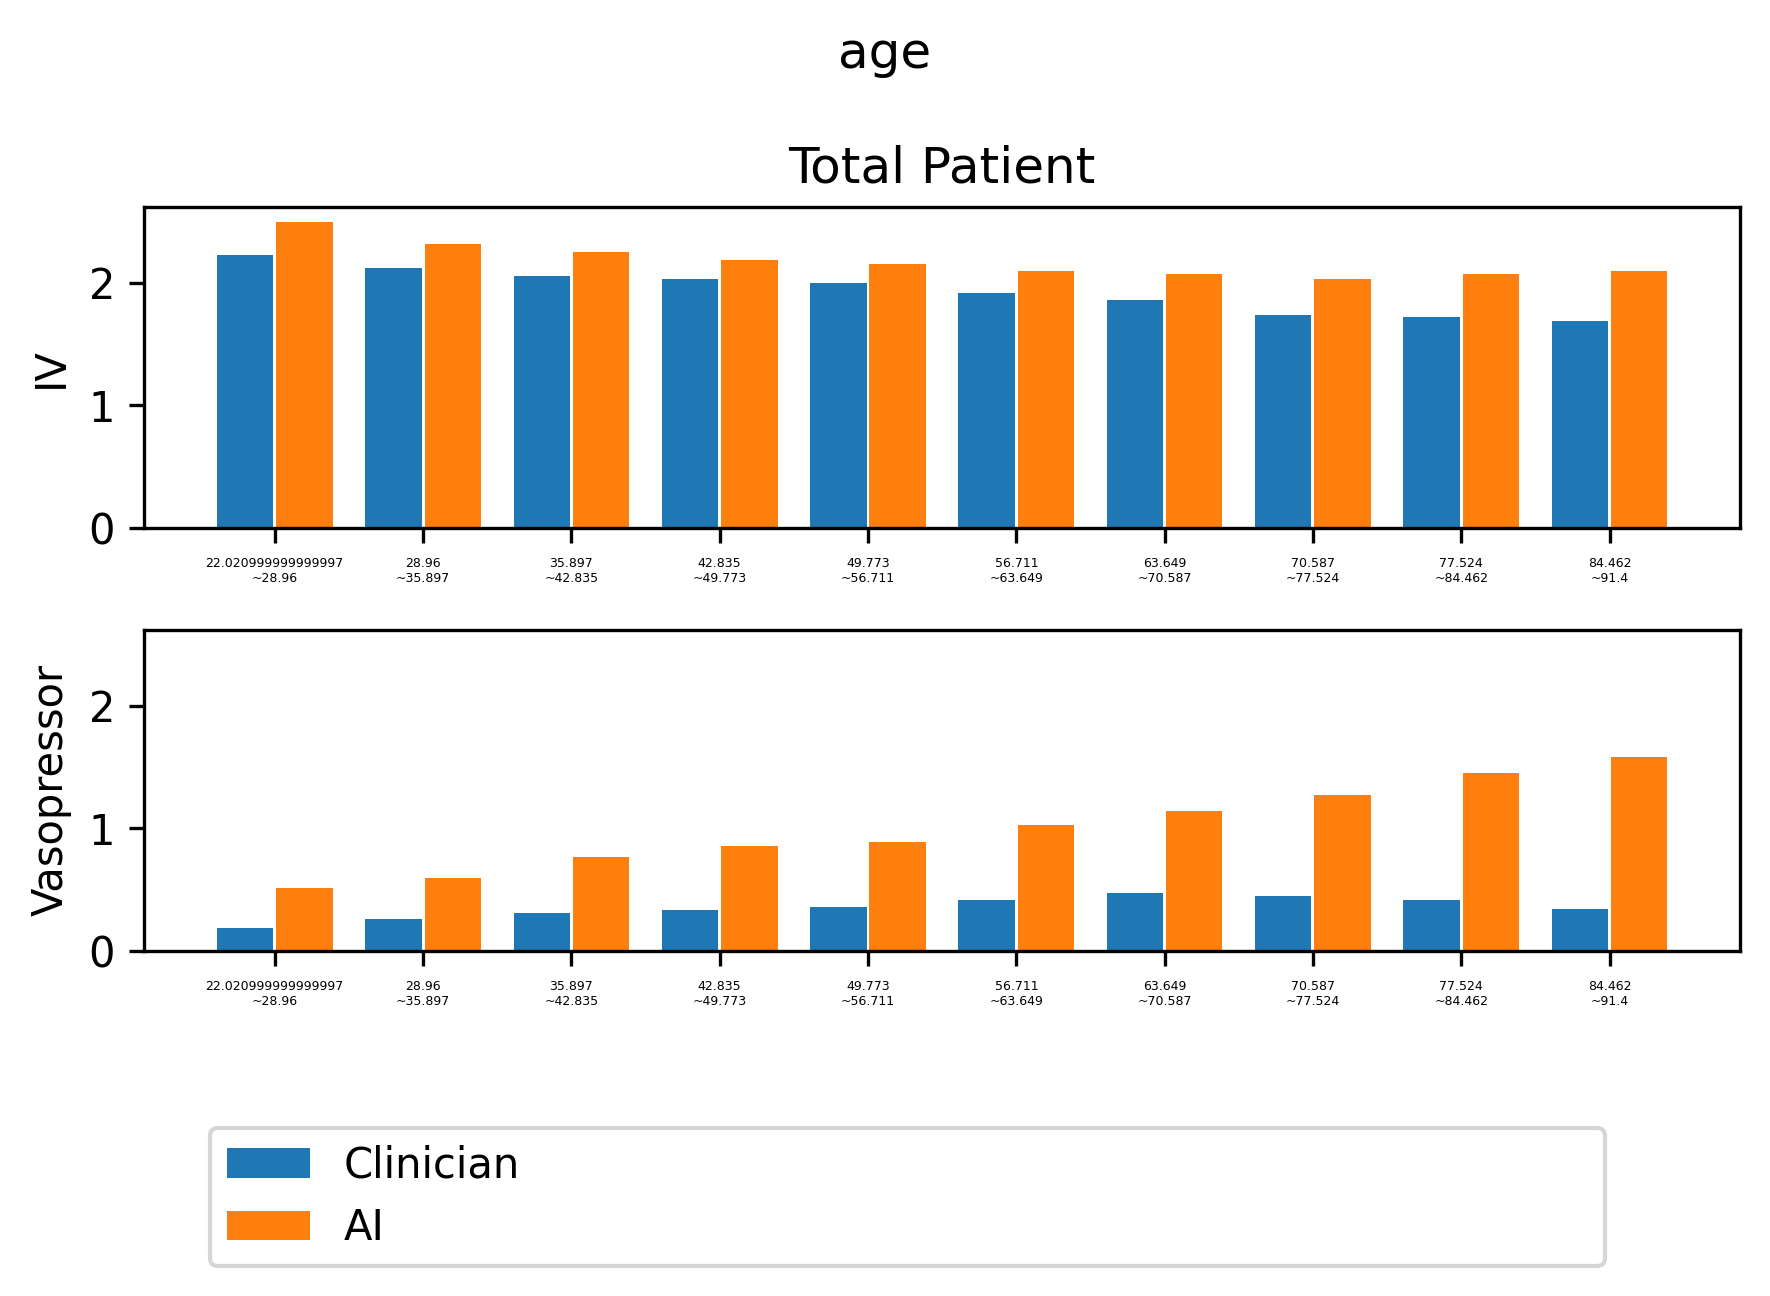

cumulated_balance
q1: -34133.49444150001		q3: 34702.42051033332
count    257162.000000
mean       1715.525229
std       12265.590502
min     -327907.283333
25%       -1209.334917
50%        1104.162492
75%        4946.873082
max      390393.885351
Name: cumulated_balance, dtype: float64


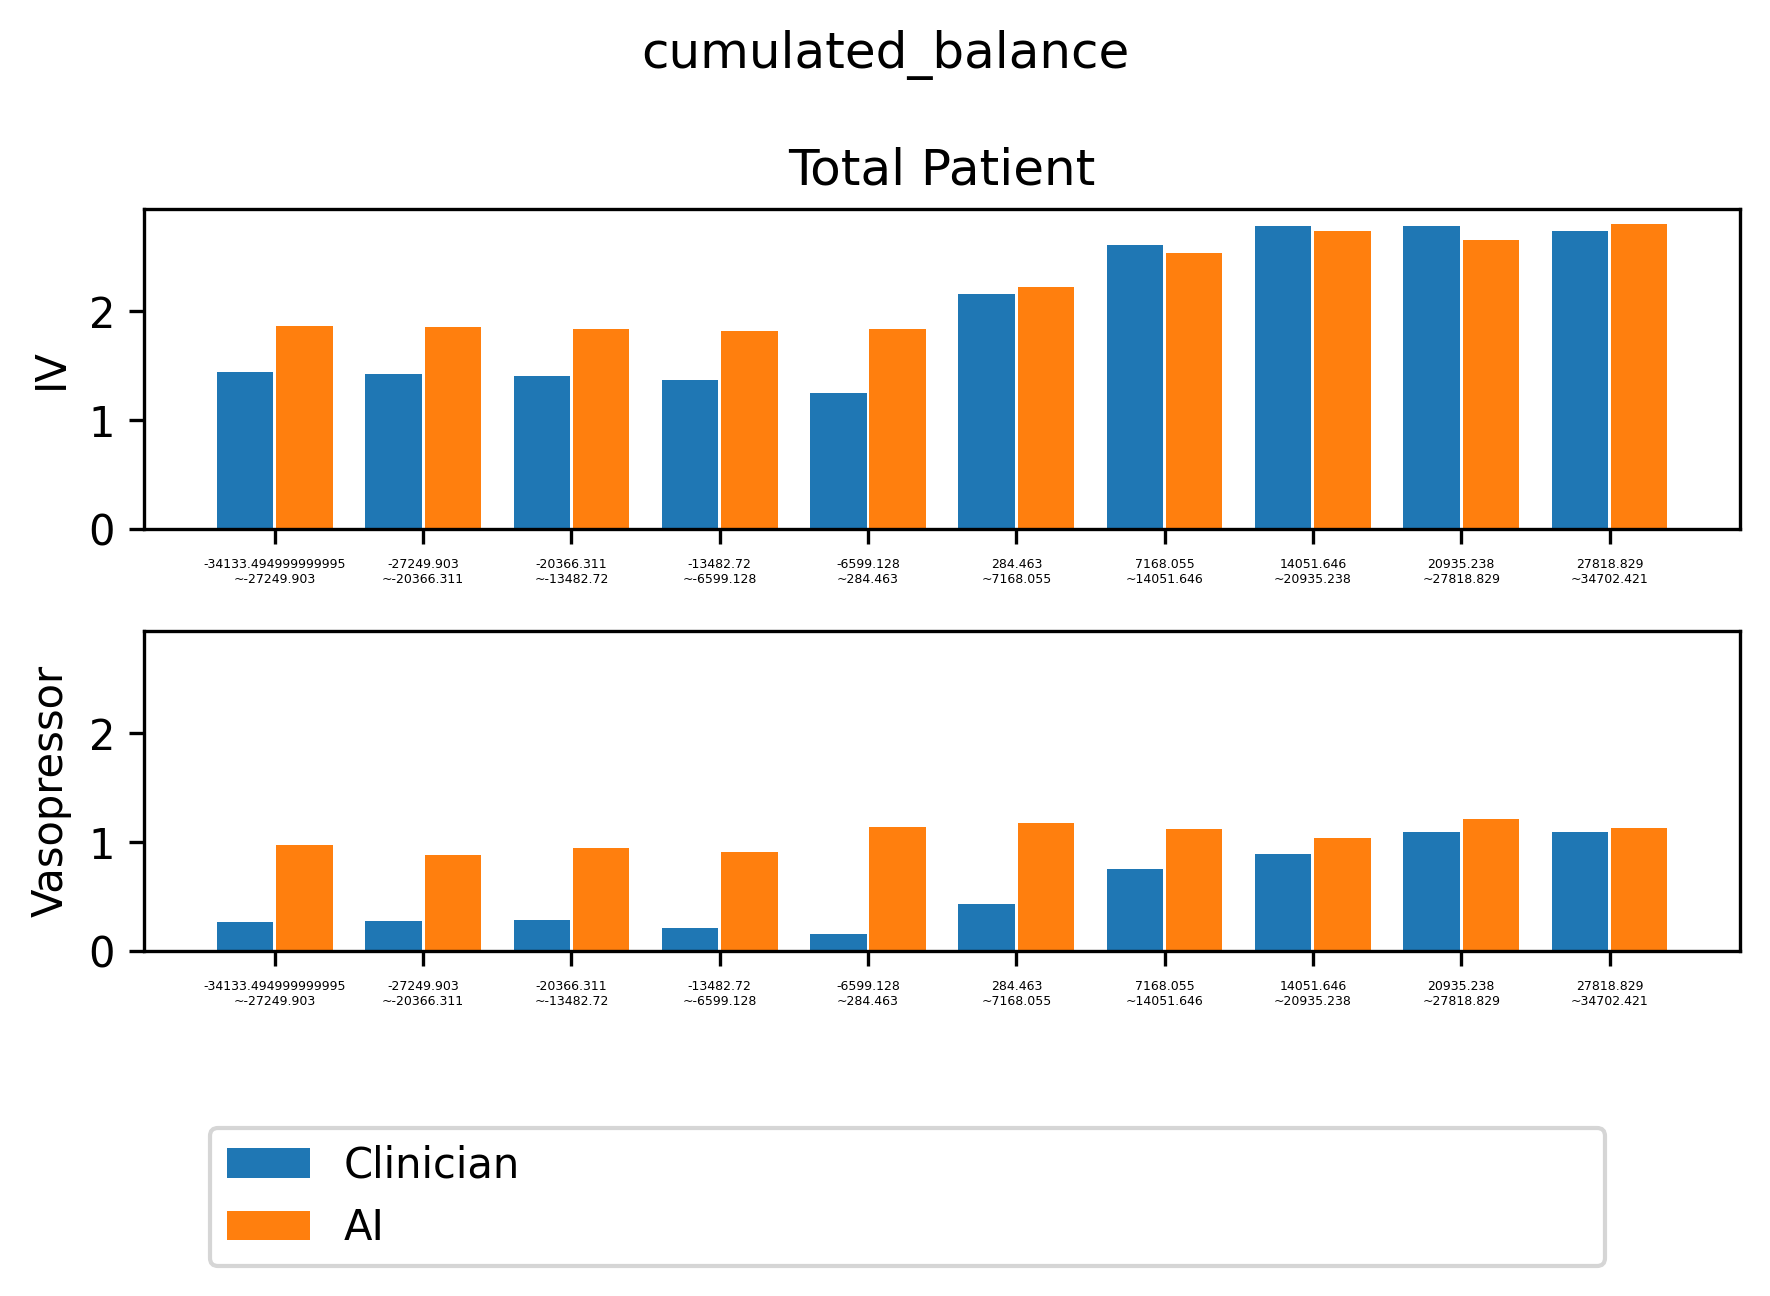

SpO2
q1: 89.5		q3: 100.0
count    257162.000000
mean         96.905366
std           2.647905
min          50.000000
25%          95.500000
50%          97.250000
75%          98.833333
max         100.000000
Name: SpO2, dtype: float64


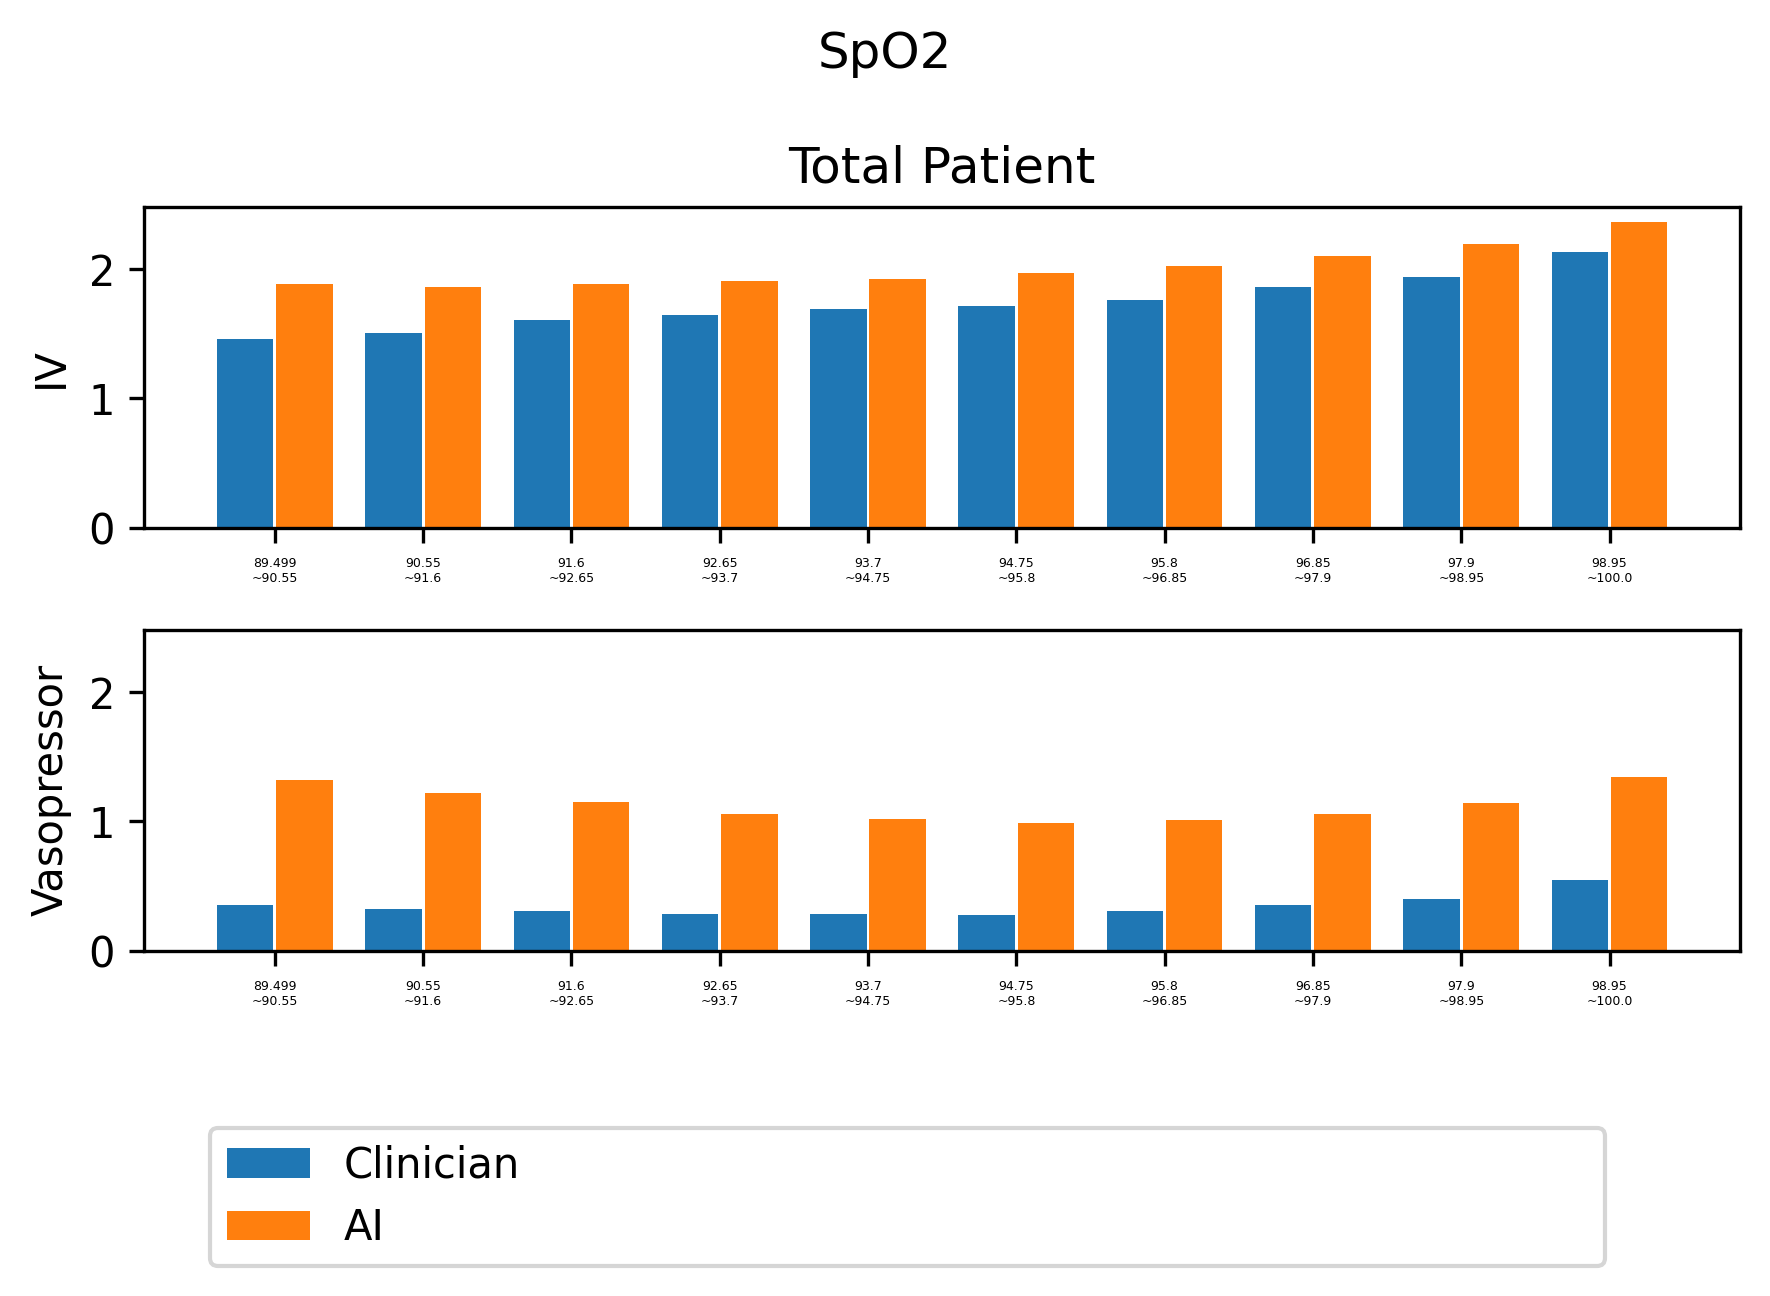

Temp_C
q1: 35.24074130588107		q3: 38.8399202614379
count    257162.000000
mean         36.910031
std           2.103498
min         -17.777778
25%          36.411110
50%          36.877778
75%          37.395062
max         536.111111
Name: Temp_C, dtype: float64


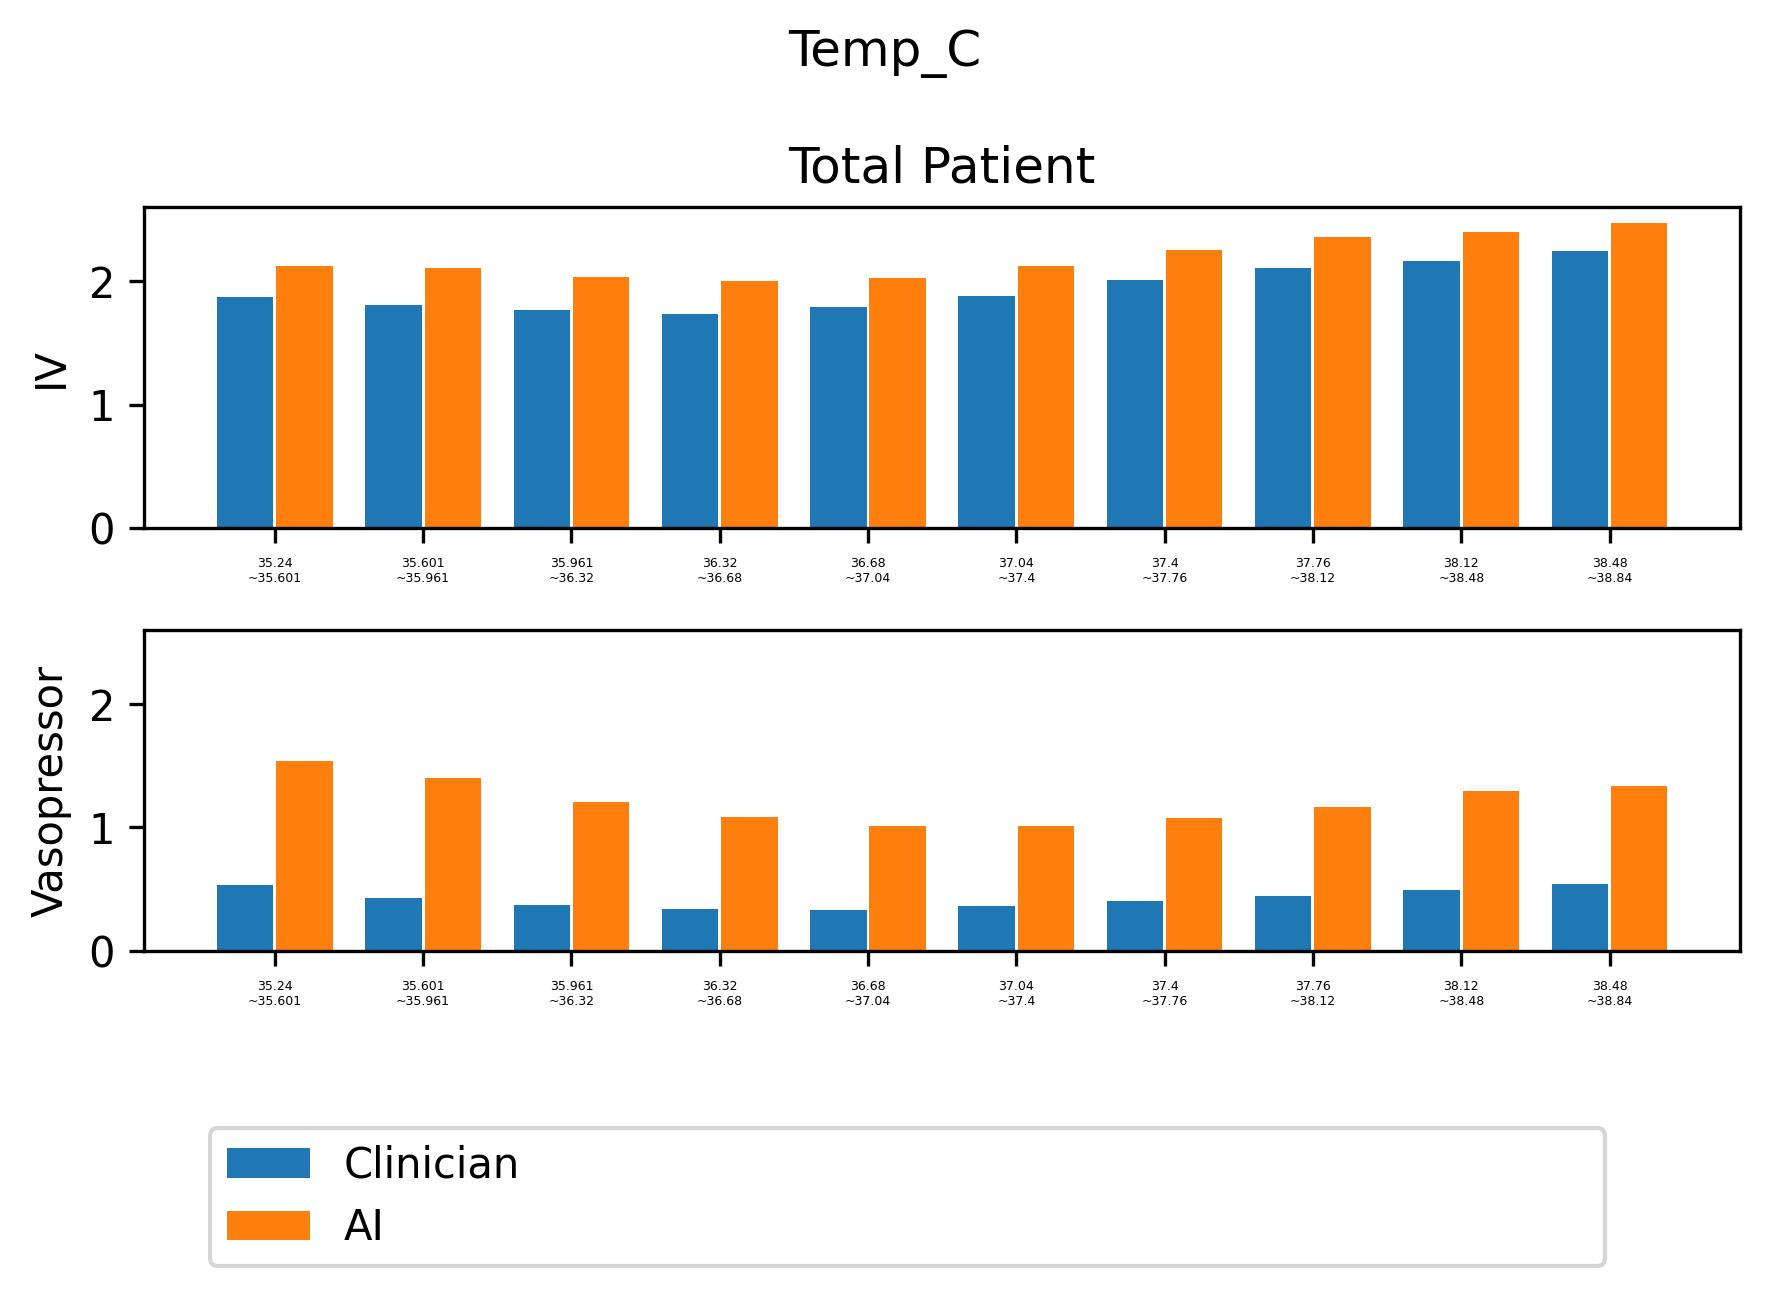

RR
q1: 10.2		q3: 34.666666666666664
count    257162.000000
mean         20.237743
std           5.197978
min           0.000000
25%          16.571429
50%          19.750000
75%          23.333333
max          65.000000
Name: RR, dtype: float64


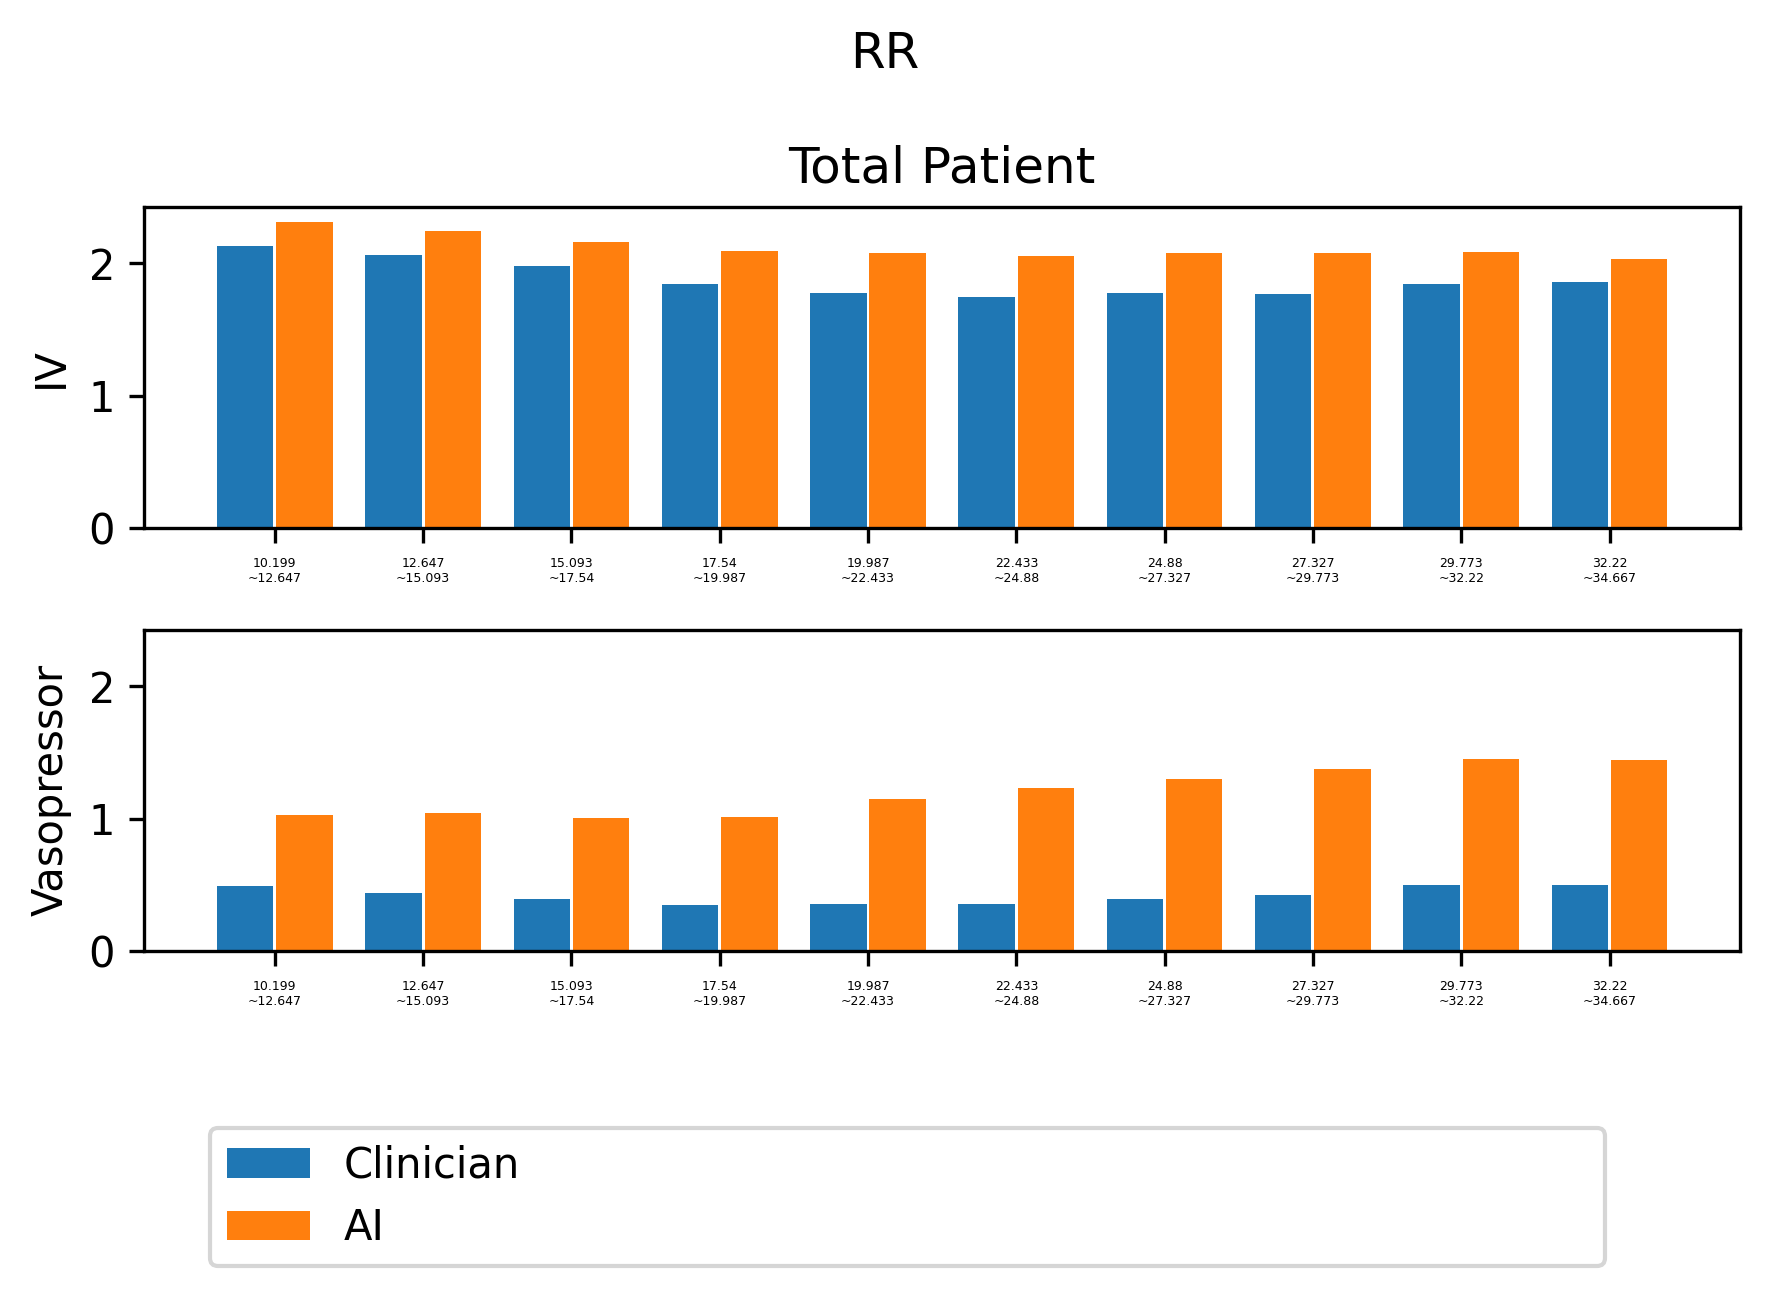

HR
q1: 53.333333333333336		q3: 129.5
count    257162.000000
mean         87.075723
std          16.745040
min           0.000000
25%          75.000000
50%          86.000000
75%          98.000000
max         190.000000
Name: HR, dtype: float64


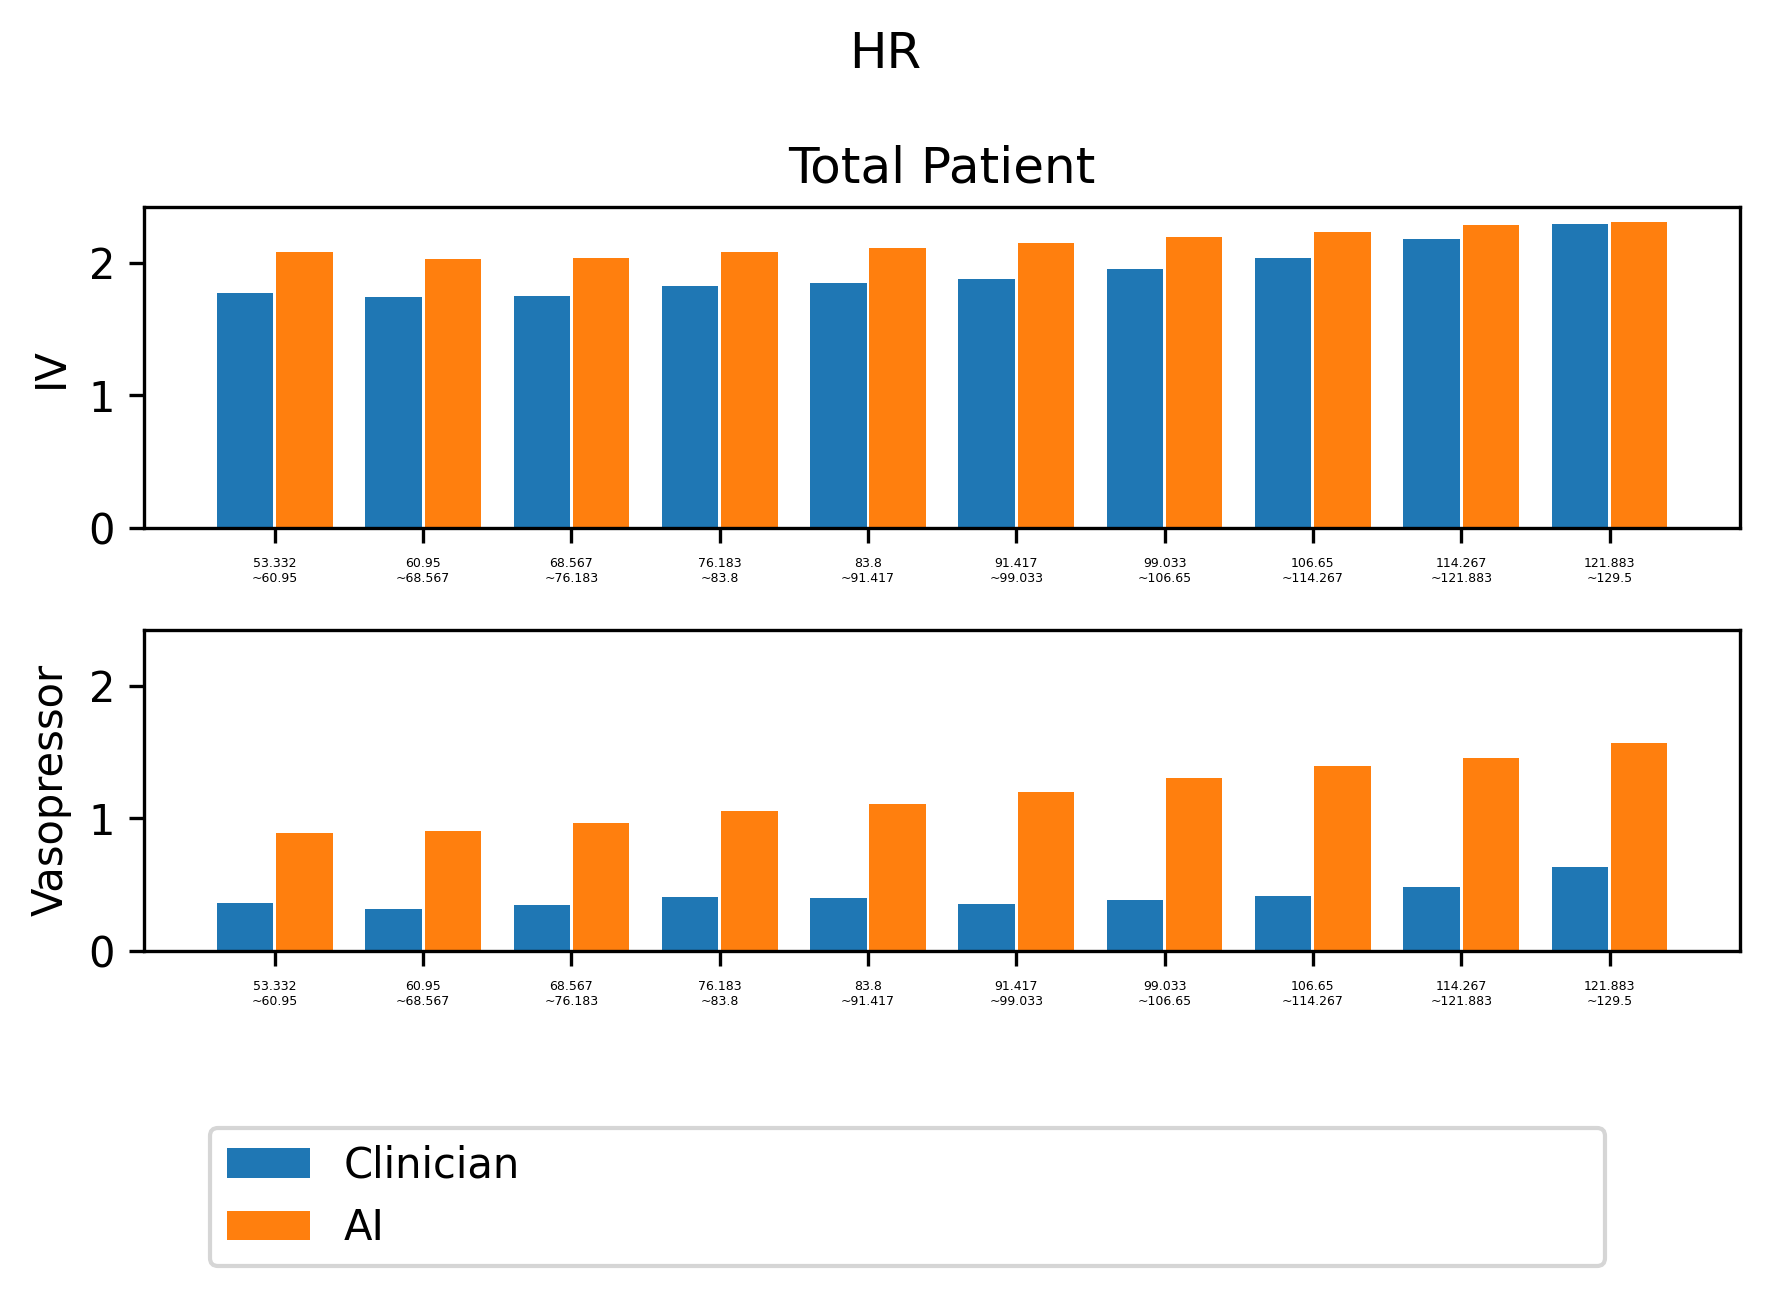

Shock_Index
q1: 0.39248991850769055		q3: 1.3094629156010231
count    257162.000000
mean          0.748039
std           0.195968
min           0.000000
25%           0.608696
50%           0.726786
75%           0.863188
max           1.712299
Name: Shock_Index, dtype: float64


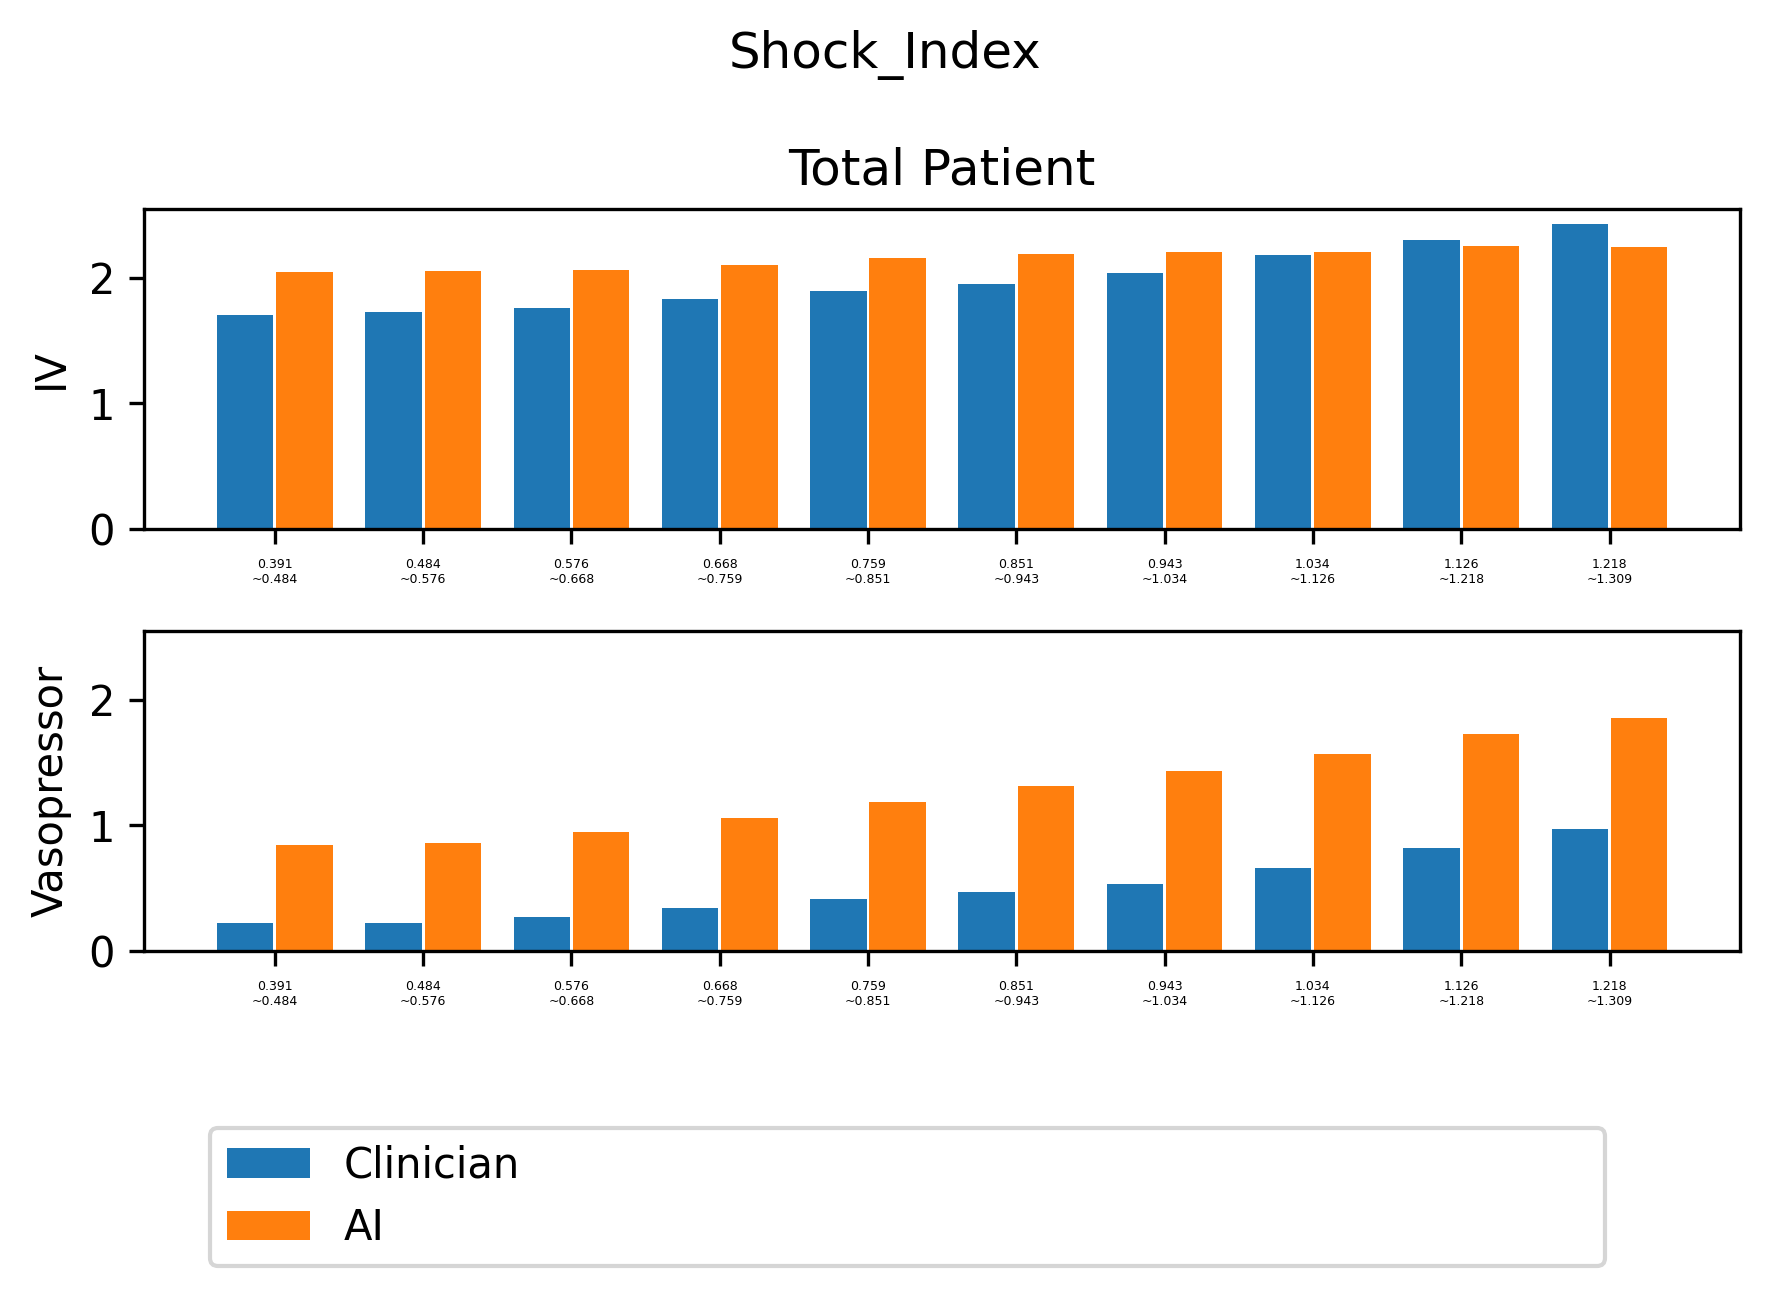

WBC_count
q1: 1.0		q3: 36.89999999999999
count    257162.000000
mean         12.246891
std           8.120646
min           0.000000
25%           7.800000
50%          10.900000
75%          14.900000
max         462.600000
Name: WBC_count, dtype: float64


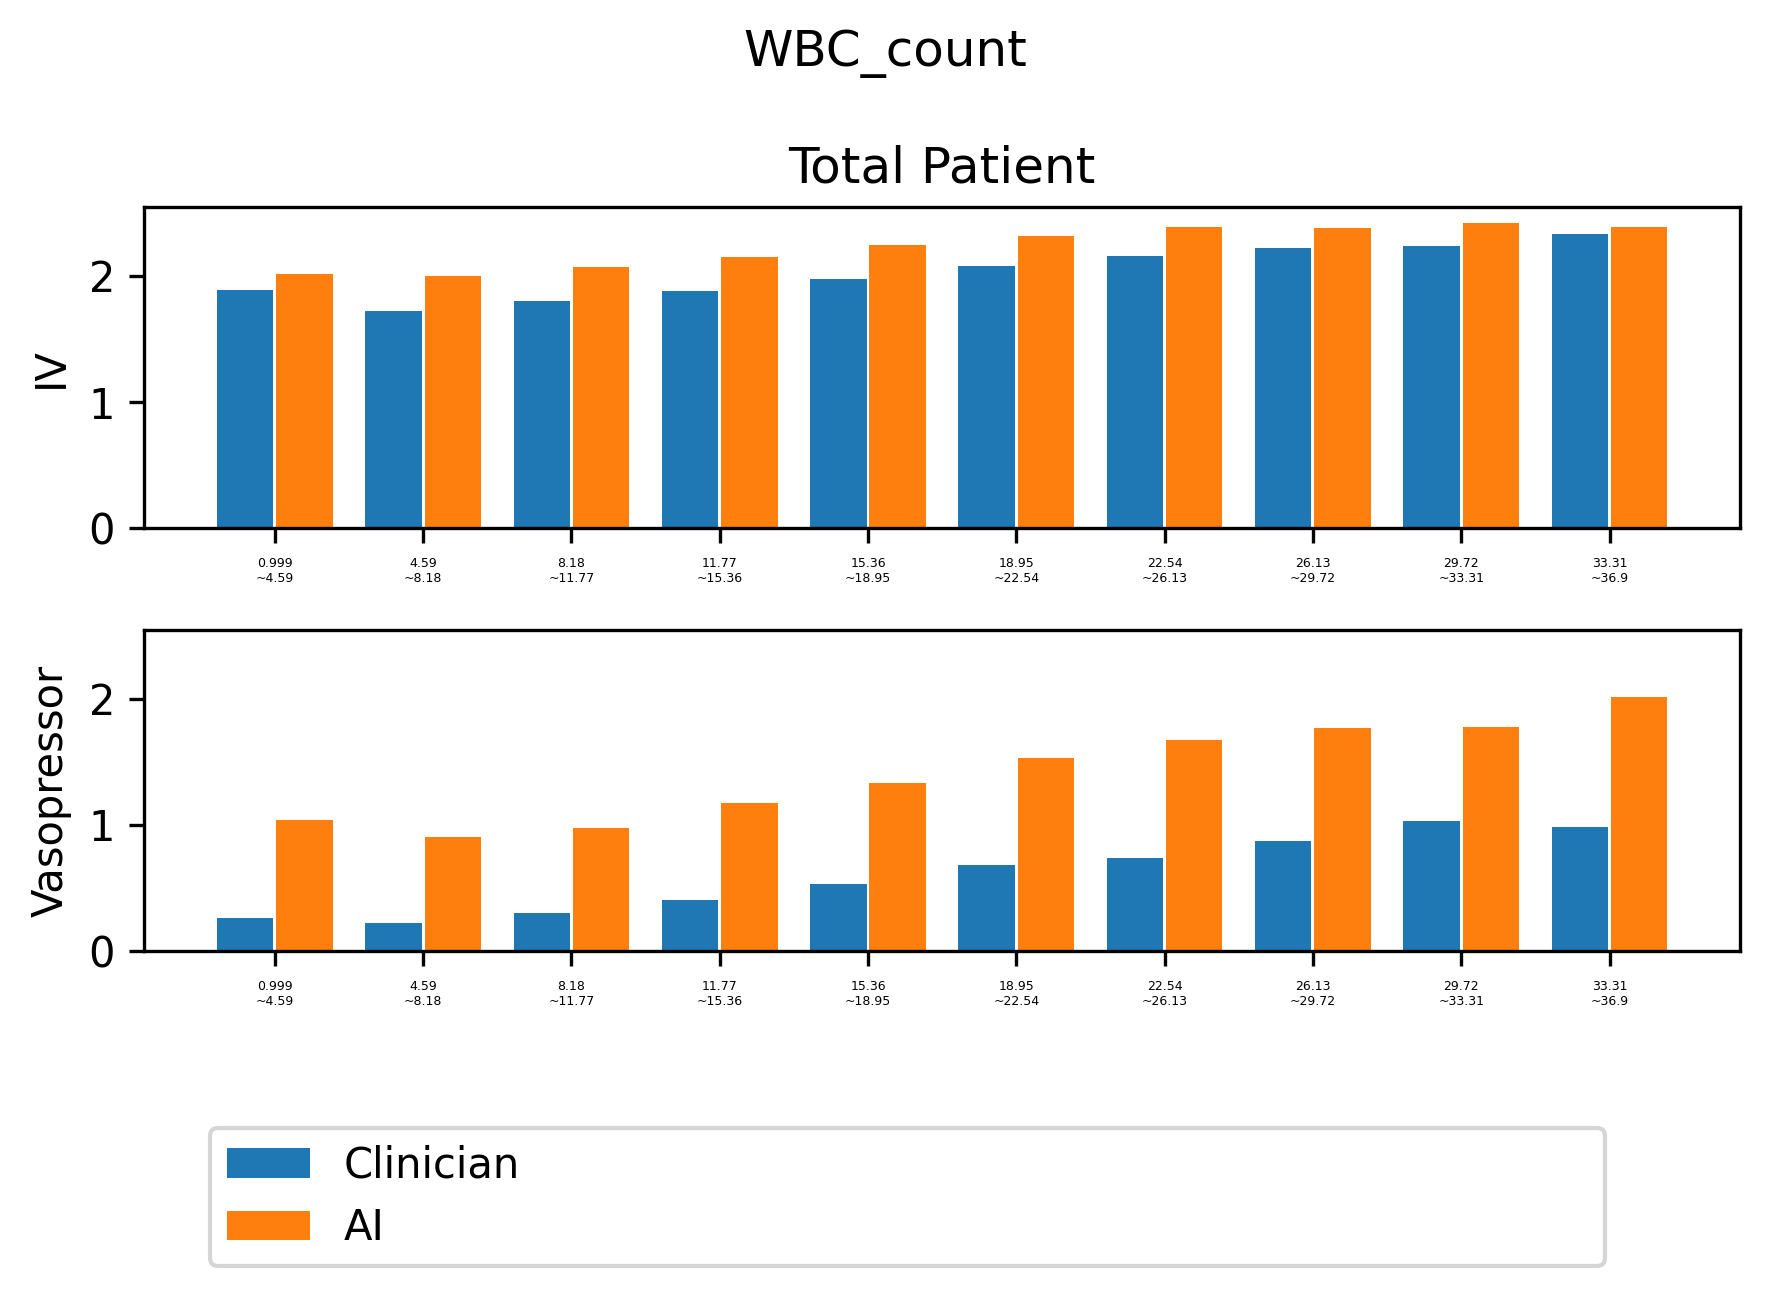

MeanBP
q1: 52.625		q3: 114.83333333333333
count    257162.000000
mean         78.092918
std          13.382012
min           0.000000
25%          68.611112
50%          76.500000
75%          86.000000
max         189.875000
Name: MeanBP, dtype: float64


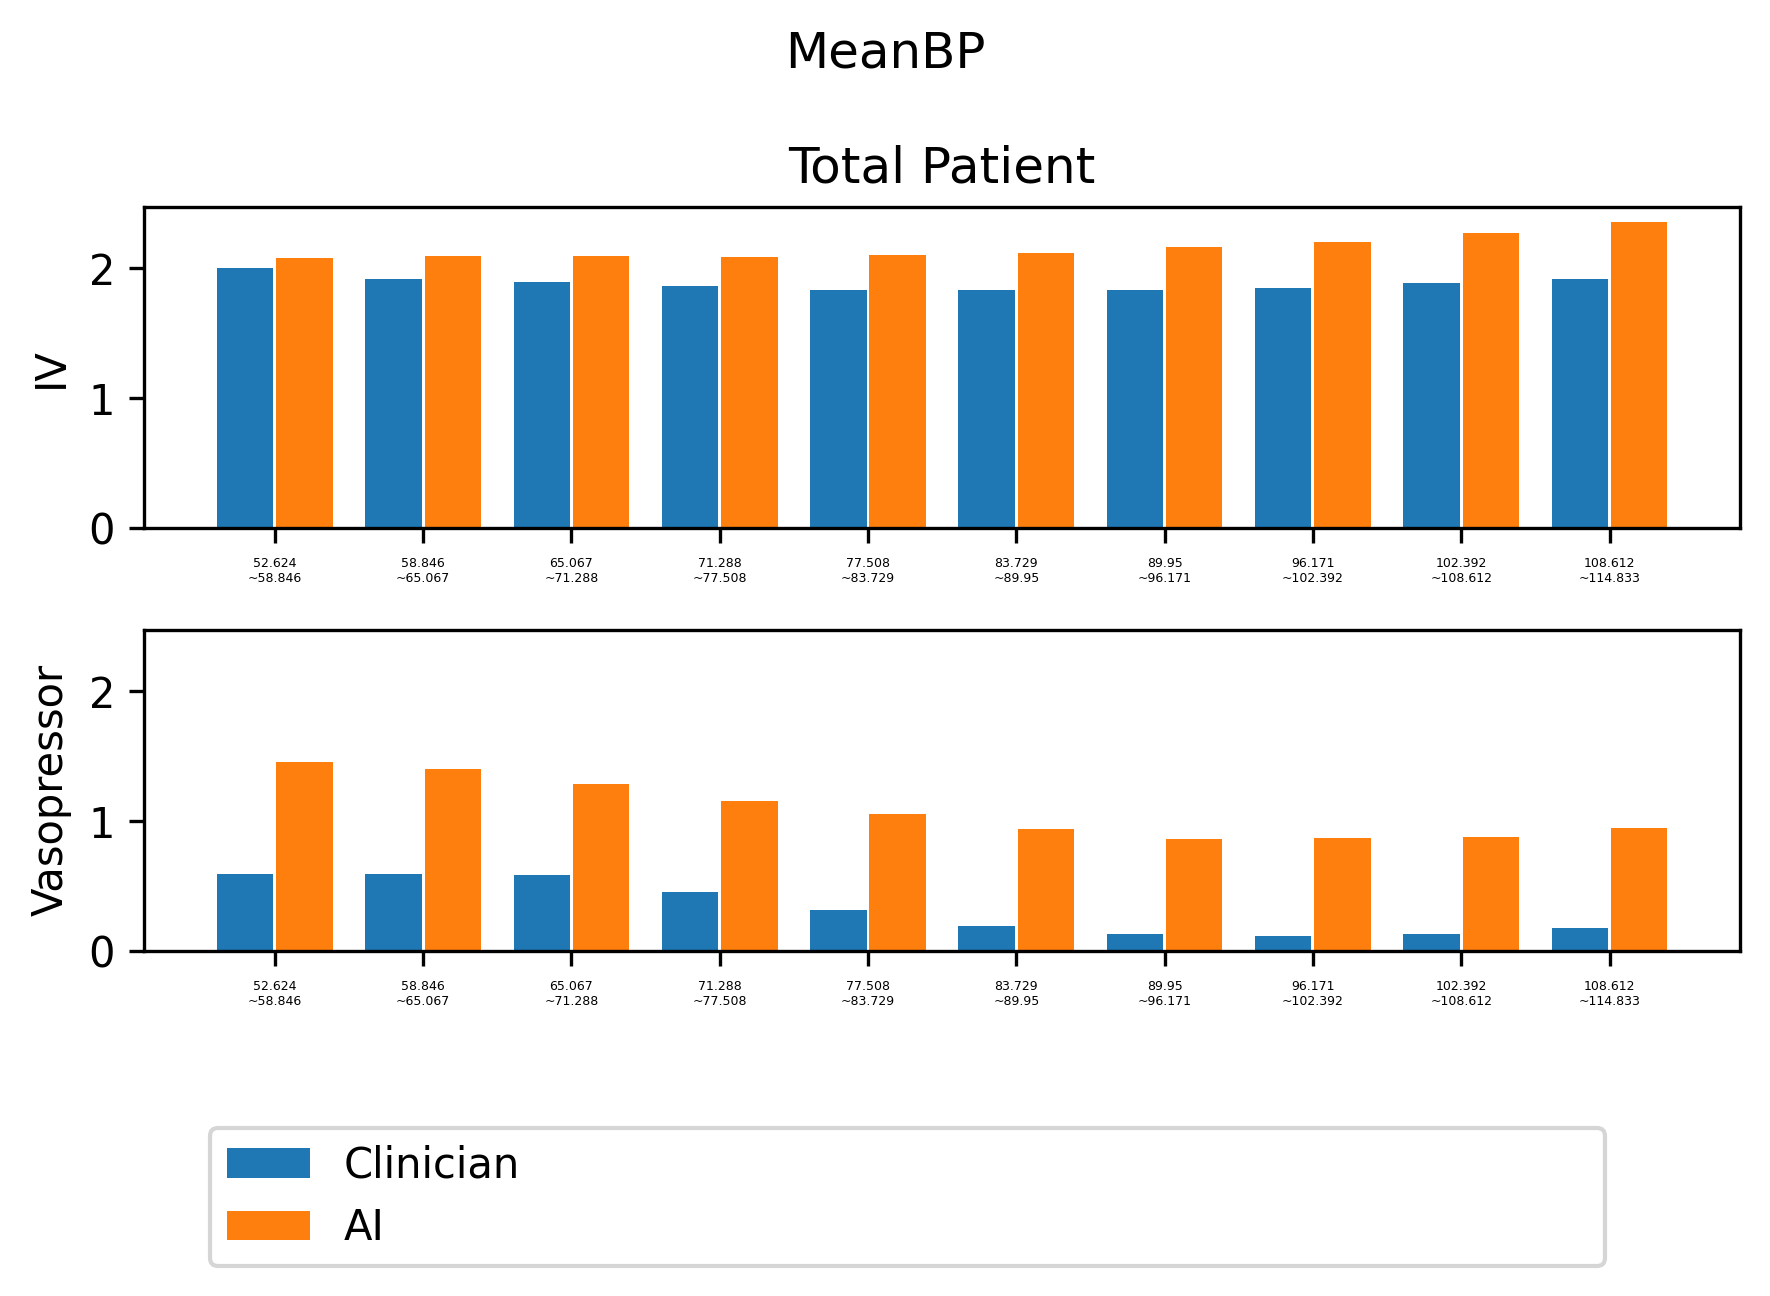

DiaBP
q1: 28.75677777777778		q3: 91.66666666666667
count    257162.000000
mean         57.034662
std          13.249530
min         -58.000000
25%          48.090909
50%          56.250000
75%          65.062500
max         214.071429
Name: DiaBP, dtype: float64


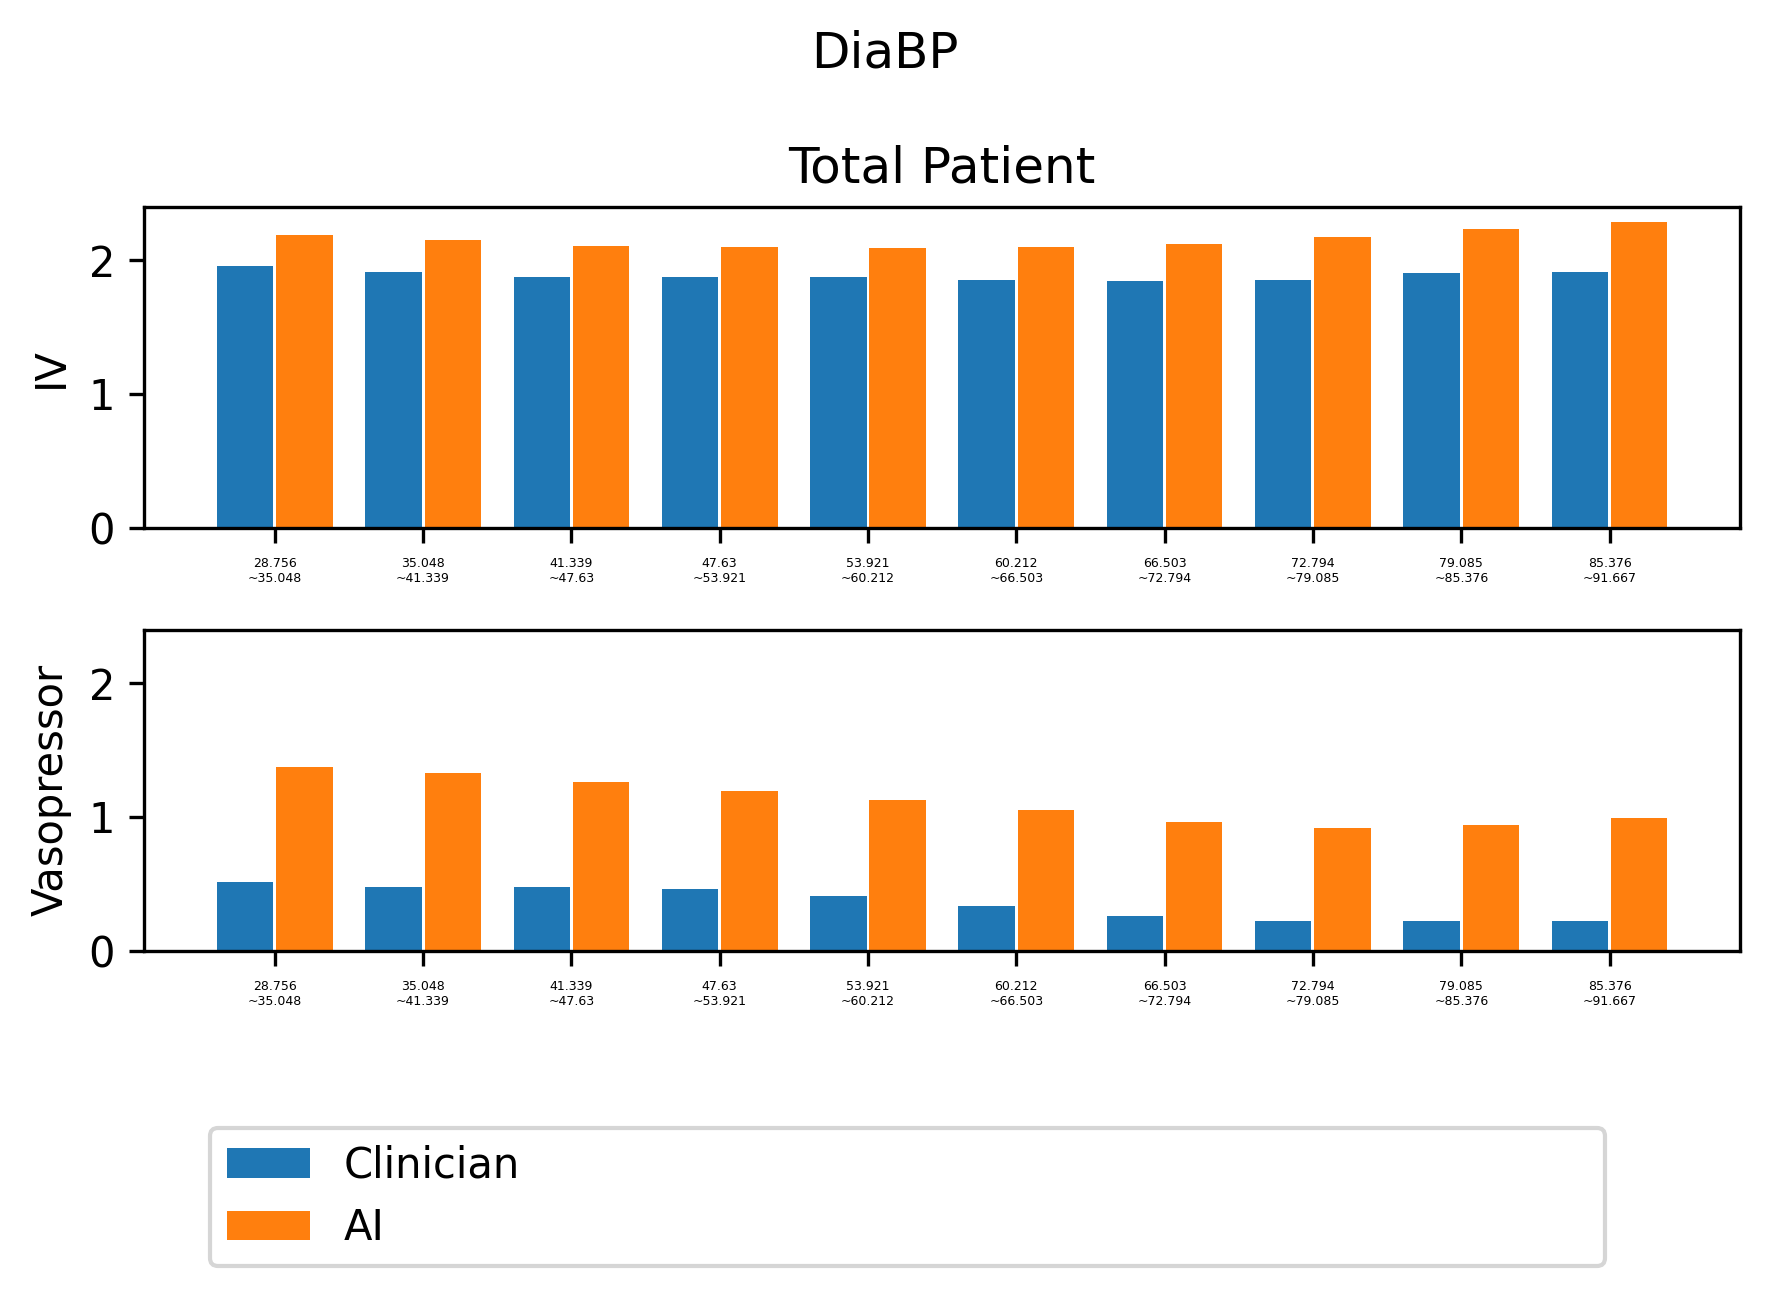

previous_dose
q1: 0.0		q3: 2712.0190339999654
count    257162.000000
mean        292.611587
std         564.822459
min           0.000000
25%           0.000000
50%          64.500000
75%         346.855375
max       20359.642000
Name: previous_dose, dtype: float64


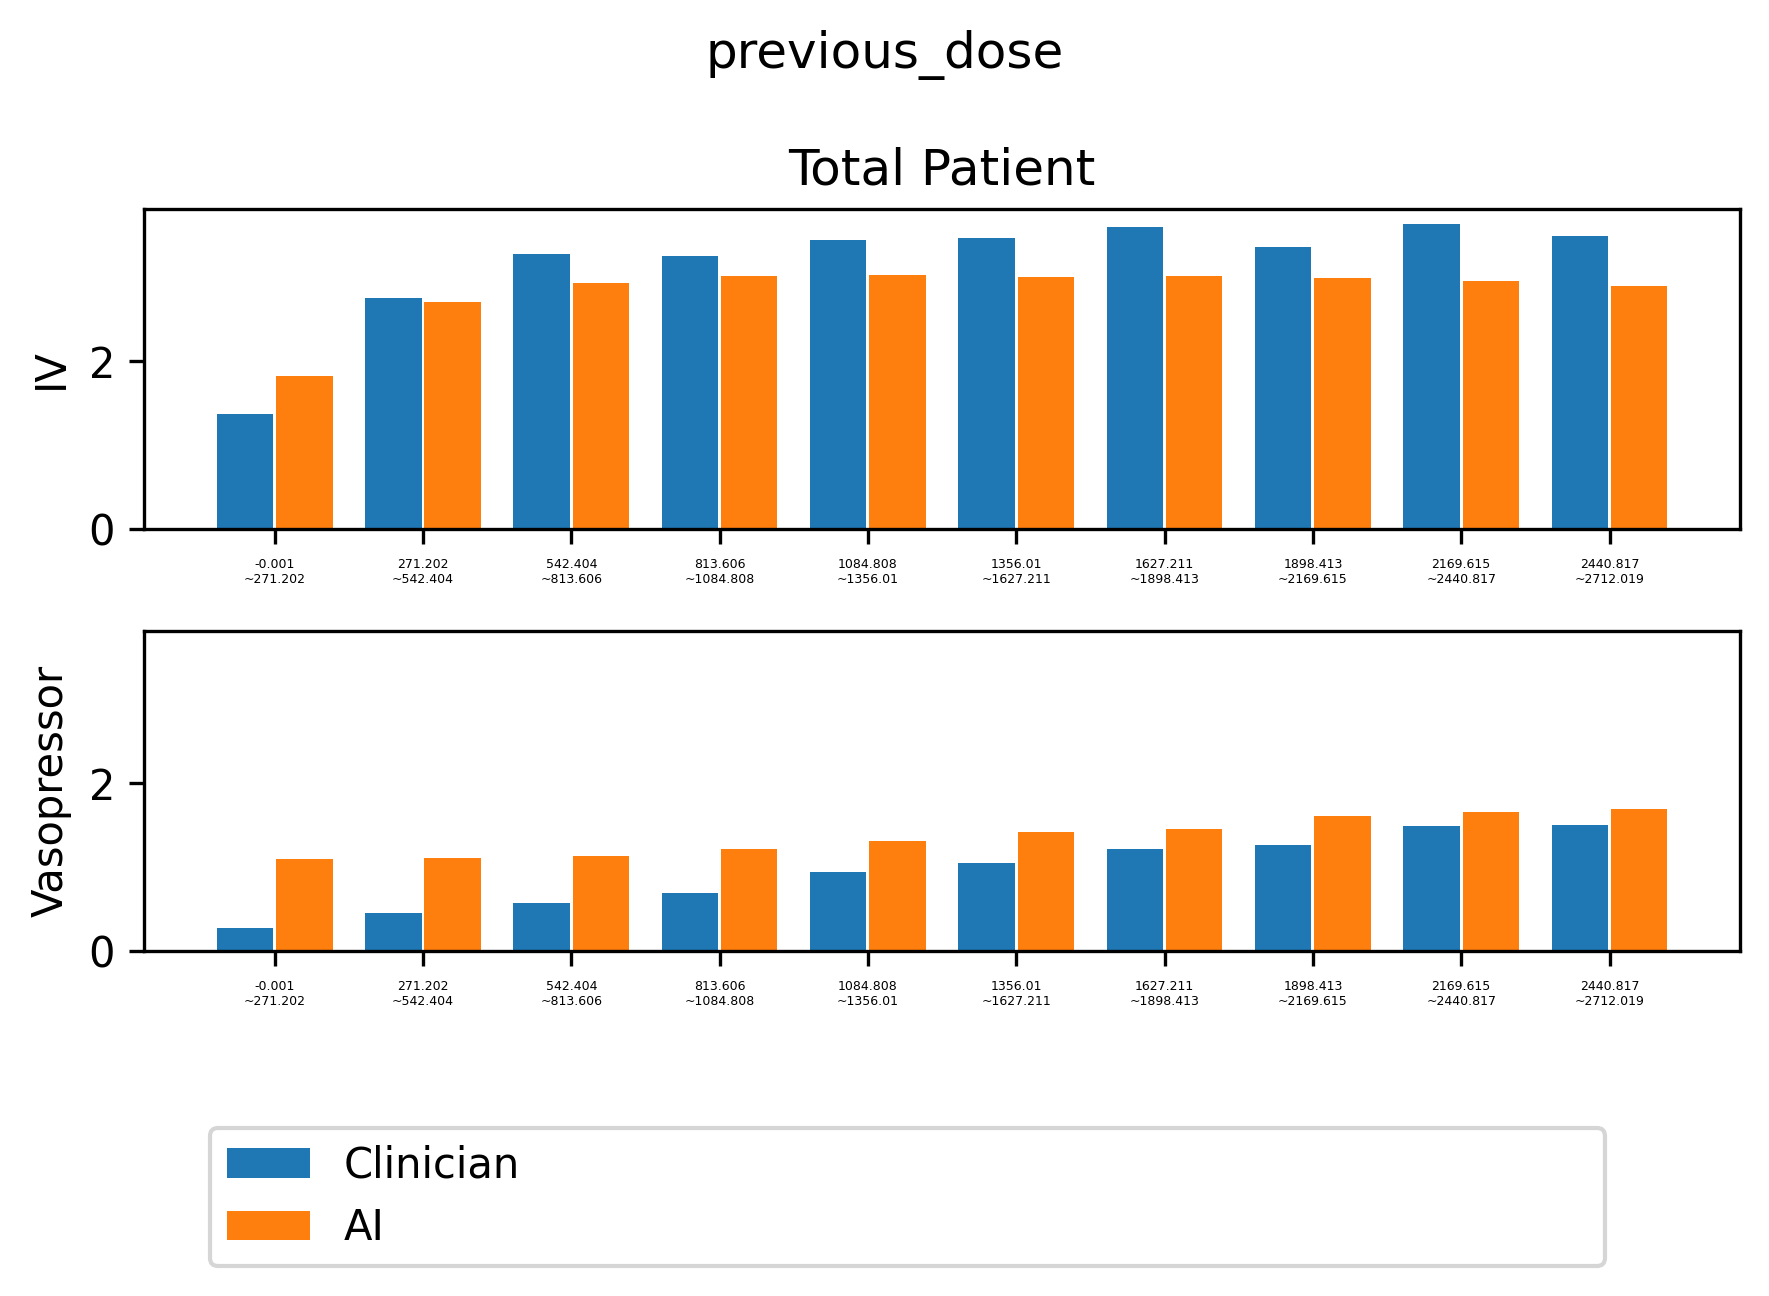

prev_dose_vaso
q1: 0.0		q3: 1.26
count    257162.000000
mean          0.060695
std           0.671397
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         189.076000
Name: prev_dose_vaso, dtype: float64


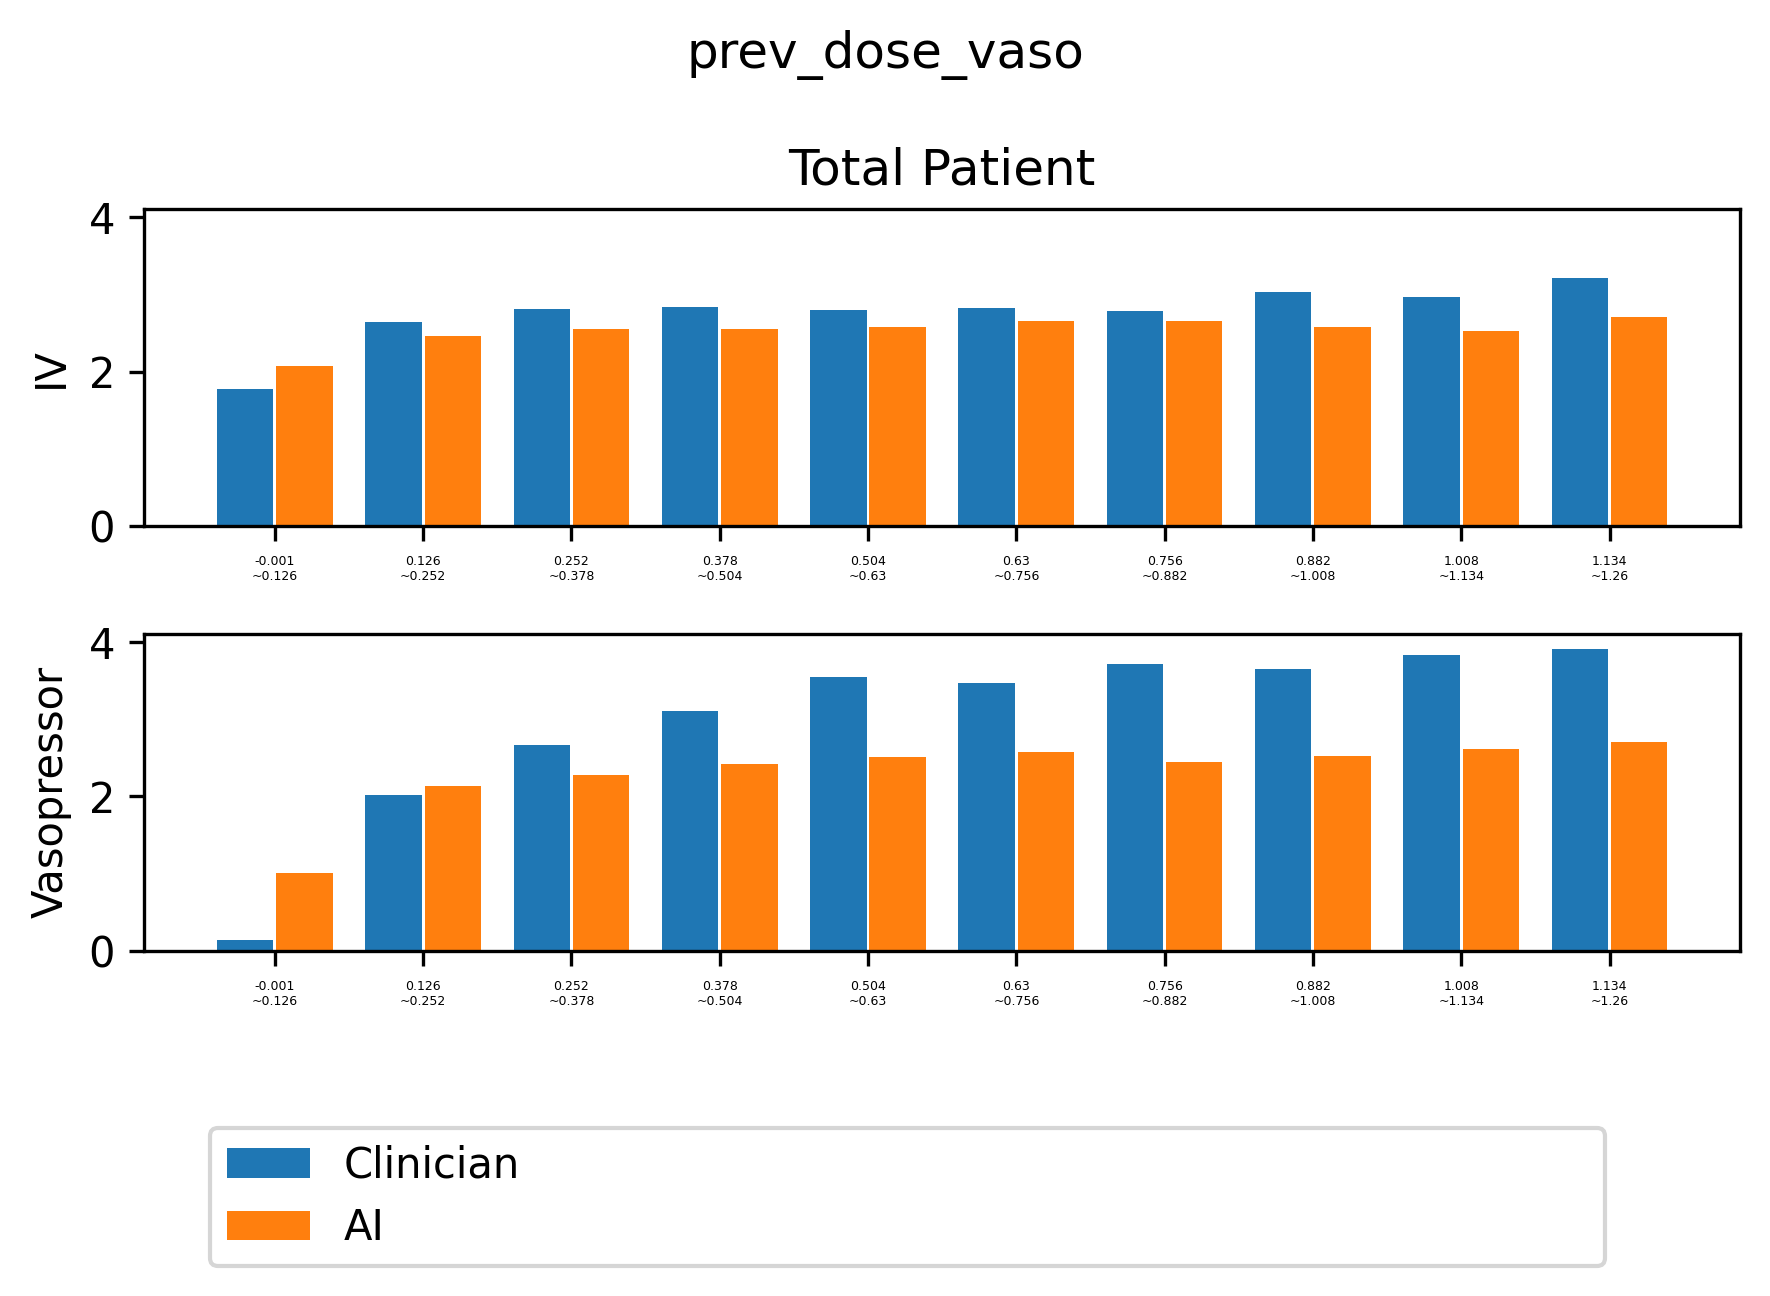

SOFA
q1: 0.0		q3: 16.0
count    257162.000000
mean          6.245876
std           3.510840
min           0.000000
25%           4.000000
50%           6.000000
75%           8.000000
max          24.000000
Name: SOFA, dtype: float64


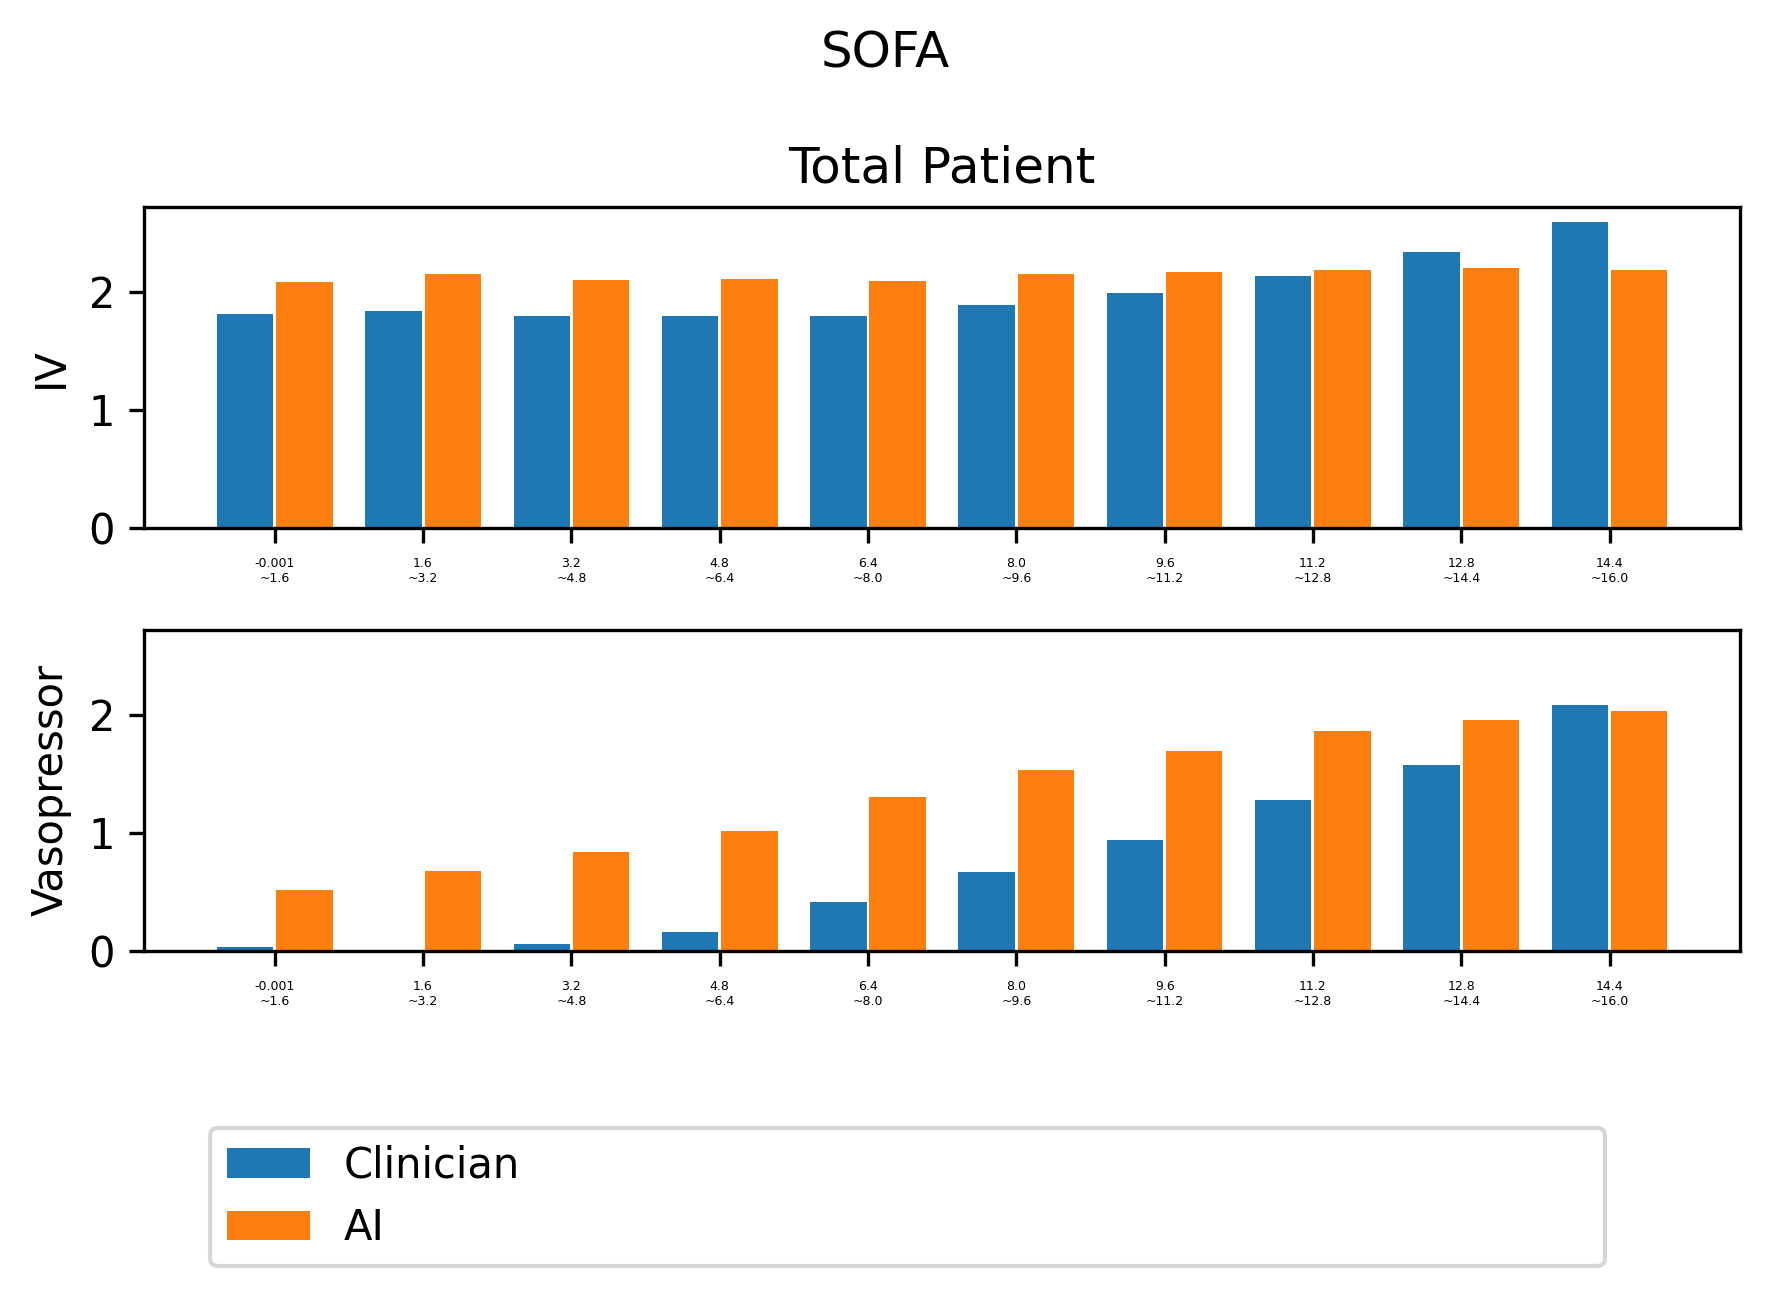

In [12]:
for attribute in query_attributes:
    dataframe = df_mimic
    dataframe_raw = df_mimic_raw_state

    fig, axes = plt.subplots(nrows=2, dpi=300, sharey=True)
    fig.suptitle(attribute)

    num_bins = 10
    q1, q3 = dataframe_raw[attribute].quantile(0.01), dataframe_raw[attribute].quantile(0.99)
    
    print('{}\nq1: {}\t\tq3: {}'.format(attribute, q1, q3))
    print(dataframe_raw[attribute].describe())
    
    dataframe = dataframe.loc[dataframe_raw[attribute].between(q1, q3, inclusive=True)]
    dataframe_raw = dataframe_raw.loc[dataframe_raw[attribute].between(q1, q3, inclusive=True)]
    
    bins_attribute = pd.cut(dataframe_raw[attribute], np.histogram_bin_edges([q1, q3], bins=num_bins), include_lowest=True, labels=False)
    xticks = ["{}\n~{}".format(x.left, x.right) for x in sorted(pd.cut(dataframe_raw[attribute], np.histogram_bin_edges([q1, q3], bins=num_bins), include_lowest=True).unique())]
    
    set_bins_ax(axes[0], dataframe, dataframe_raw, attribute, bins_attribute, 'phys', 'iv')
    set_bins_ax(axes[0], dataframe, dataframe_raw, attribute, bins_attribute, 'rein', 'iv')
#     set_bins_ax(axes[0][1], dataframe.loc[dataframe['death'] == 1], dataframe_raw, attribute, bins_attribute, 'phys', 'iv')
#     set_bins_ax(axes[0][1], dataframe.loc[dataframe['death'] == 1], dataframe_raw, attribute, bins_attribute, 'rein', 'iv')

    set_bins_ax(axes[1], dataframe, dataframe_raw, attribute, bins_attribute, 'phys', 'vaso')
    set_bins_ax(axes[1], dataframe, dataframe_raw, attribute, bins_attribute, 'rein', 'vaso')
#     set_bins_ax(axes[1][1], dataframe.loc[dataframe['death'] == 1], dataframe_raw, attribute, bins_attribute, 'phys', 'vaso')
#     set_bins_ax(axes[1][1], dataframe.loc[dataframe['death'] == 1], dataframe_raw, attribute, bins_attribute, 'rein', 'vaso')

    axes[0].set_xticks(ticks=range(len(xticks)))
    axes[0].set_xticklabels(xticks, fontsize=3)
#     axes[0][1].set_xticks(ticks=range(len(xticks)))
#     axes[0][1].set_xticklabels(xticks, fontsize=3)
    axes[1].set_xticks(ticks=range(len(xticks)))
    axes[1].set_xticklabels(xticks, fontsize=3)
#     axes[1][1].set_xticks(ticks=range(len(xticks)))
#     axes[1][1].set_xticklabels(xticks, fontsize=3)

    bbox = (fig.subplotpars.left, fig.subplotpars.bottom + 0.02,  fig.subplotpars.right - fig.subplotpars.left, -0.08)
    axes[1].legend(bbox_to_anchor=bbox, loc=9, ncol=1, mode="expand", borderaxespad=0., bbox_transform=fig.transFigure)

    axes[0].set_title('Total Patient')
#     axes[0][1].set_title('Death Patient Only')

    axes[0].set_ylabel('IV')
    axes[1].set_ylabel('Vasopressor')
    plt.tight_layout()

    os.makedirs("result/average_iv_vaso_dose_over_patient/", exist_ok=True)
    plt.savefig("result/average_iv_vaso_dose_over_patient/{}.png".format(attribute))
    plt.show()